In [1]:
## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

SyntaxError: invalid syntax (<ipython-input-1-505f186c0fce>, line 3)

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #print(objpoints, ', ', imgpoints)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

# Use cv2.calibrateCamera() and cv2.undistort()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
print(mtx, dist)
cv2.destroyAllWindows()

[[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128938e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[-0.24688775 -0.02373133 -0.00109842  0.00035108 -0.00258571]]


In [3]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # was the line detected in the last iteration?
        self.detectedCounter = 0  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #recent good average x values of the fitted line over the last n iterations
        self.recent_bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit_list = None  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #recent radius of curvature of the line in some units
        self.recent_curvature = None 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

In [4]:
# Define a class to receive the characteristics of each line detection
class globalVar():
    def __init__(self):
        # frame counter
        self.value = 0

In [5]:
#Functions for Pipline

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    undist = np.copy(img)  # Delete this line
    return undist

# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    undist = np.copy(img)  # Delete this line
    return undist

#undistort the input image with the known parameter mtx and dist
def undistortImg(img, mtx, dist):
    imgUndistort = cv2.undistort(img, mtx, dist, None, mtx)
    return imgUndistort

#warp the preprocessed binary image
def warpImg(img,X,Y):

    src = np.float32([[(1-X)/2*img.shape[1],Y*img.shape[0]],[0,img.shape[0]],
                      [img.shape[1],img.shape[0]],[(1+X)/2*img.shape[1],Y*img.shape[0]]])
    #print(img.shape)
    dst = np.float32([[0,0],[0,img.shape[0]],[img.shape[1],img.shape[0]],[img.shape[1],0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    #delete the next two lines
    return warped, M

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        if (len(good_left_inds)>minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if (len(good_right_inds)>minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fitx, right_fitx, left_fit, right_fit, ploty

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_fit_last, right_fit_last):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit_last[0]*nonzeroy**2 + left_fit_last[1]
    *nonzeroy + left_fit_last[2] - margin)) & (nonzerox < (left_fit_last[0]*nonzeroy
    **2 + left_fit_last[1]*nonzeroy + left_fit_last[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit_last[0]*nonzeroy**2 + right_fit_last[1]
    *nonzeroy + right_fit_last[2] - margin)) & (nonzerox < (right_fit_last[0]*nonzeroy
    **2 + right_fit_last[1]*nonzeroy + right_fit_last[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    if(len(leftx)<10000):
        left_fit = left_fit_last
        fLeftFound = False
    else:
        fLeftFound = True
        
    if(len(rightx)<10000):
        right_fit = right_fit_last
        fRightFound = False
    else:
        fRightFound = True
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, left_fit, right_fit, fLeftFound, fRightFound, ploty

In [6]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit[0]*y_eval+left_fit[1])**2)**1.5/2/np.abs(left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = (1+(2*right_fit[0]*y_eval+right_fit[1])**2)**1.5/2/np.abs(right_fit[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad


In [7]:
def lineSmooth(xlist, x, n):
    #print(xlist.shape)
    xlist = np.append(xlist, [x], axis=0)
    if(len(xlist) > n):
        xlist = np.delete(xlist, 0, axis=0)
    return xlist
        

In [8]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**1.5/np.abs(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = (1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**1.5/np.abs(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

In [9]:
#only used for harder project sanity check
def recentInfoProcess(nInit):
    if(zFrame<nInit):
        left_Line.recent_bestx = left_Line.bestx
        left_Line.recent_curvature = left_Line.radius_of_curvature

In [10]:
#compare two detected lane lines
def sanity_check(left_curverad, right_curverad, cur_threshold, left_fit, right_fit, fit_threshold_A, fit_threshold_B):
    cur_factor = left_curverad/right_curverad * 100
    fit_factor_A = left_fit[0]/right_fit[0] * 100
    fit_factor_B = left_fit[1]/right_fit[1] * 100
    print(zFrame.value)
    return cur_factor, fit_factor_A, fit_factor_B

In [11]:
def drawLines(undist, warped, left_fitx, right_fitx, ploty, X, Y):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    dst = np.float32([[(1-X)/2*img.shape[1],Y*img.shape[0]],[0,img.shape[0]],
                      [img.shape[1],img.shape[0]],[(1+X)/2*img.shape[1],Y*img.shape[0]]])

    src = np.float32([[0,0],[0,img.shape[0]],[img.shape[1],img.shape[0]],[img.shape[1],0]])
    
    Minv = cv2.getPerspectiveTransform(src, dst)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result


In [19]:
def process_image(image):

    warpX = 0.17
    warpY = 0.63
    result = pipeline(image, s_thresh=(170, 255), sx_thresh=(20, 100))
    warped, M = warpImg(result,warpX,warpY)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    warped = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    
    zLineLost = 10
    
    #print(left_Line.recent_xfitted)

    if(left_Line.detected and right_Line.detected):
        print('A')
        result, left_fitx, right_fitx, left_fit, right_fit, fLeftFound, fRightFound, ploty = search_around_poly(warped, 
        left_Line.best_fit, right_Line.best_fit)
        
        if(fLeftFound):
            left_Line.detectedCounter = 0
            left_Line.detected = True
        else:
            left_Line.detectedCounter += 1
            if(left_Line.detectedCounter>=zLineLost):
                left_Line.detected = False
        if(fRightFound):
            right_Line.detectedCounter = 0
            right_Line.detected = True
        else:
            right_Line.detectedCounter += 1
            if(right_Line.detectedCounter>=zLineLost):
                right_Line.detected = False

        
    else:
        print('B')
        result, left_fitx, right_fitx, left_fit, right_fit, ploty = fit_polynomial(warped)
        
        left_Line.detectedCounter = 0
        right_Line.detectedCounter = 0
        left_Line.detected = True
        right_Line.detected = True

    
    left_Line.recent_xfitted = left_fitx
    right_Line.recent_xfitted = right_fitx


    left_Line.best_x = np.mean(left_fitx)
    right_Line.best_x = np.mean(right_fitx)
    
    left_Line.best_fit_list = lineSmooth(left_Line.best_fit_list, left_fit, 50)
    left_Line.best_fit = np.mean(left_Line.best_fit_list, axis=0)
        
    right_Line.best_fit_list = lineSmooth(right_Line.best_fit_list, right_fit, 50)
    right_Line.best_fit = np.mean(right_Line.best_fit_list, axis=0)
    
    left_Line.radius_of_curvature, right_Line.radius_of_curvature = measure_curvature_pixels(ploty, 
        left_Line.best_fit, right_Line.best_fit)
    
    #calculate left and right curvature
    left_Line.radius_of_curvature, right_Line.radius_of_curvature = measure_curvature_real(ploty, left_fit, right_fit)
    
    #sanity check
    cur_factor, fit_factor_A, fit_factor_B = sanity_check(left_Line.radius_of_curvature, right_Line.radius_of_curvature,100, 
                                                          left_fit, right_fit, 100, 100)
    if (cur_factor>200 or fit_factor_A>200 or fit_factor_B>200):
        zMismatchCounter.value += 1
    #print(left_fit, left_Line.best_fit)
    #print(right_fit, right_Line.best_fit)
    #print(left_Line.detectedCounter, right_Line.detectedCounter)
    print('cur_factor', cur_factor, 'fit_factor_A', fit_factor_A, 'fit_factor_B', fit_factor_B)
    #print(zFrame.value)
    print(zMismatchCounter.value)
    cur_factor = round(cur_factor, 2)
    fit_factor_A = round(fit_factor_A, 2)
    fit_factor_B = round(fit_factor_B, 2)
    txt = str(cur_factor) +'    '+ str(fit_factor_A) +'    '+ str(fit_factor_B)
    #txt = str(left_Line.detectedCounter) +'    '+ str(right_Line.detectedCounter)
    #txt = str(left_Line.radius_of_curvature) +'    '+ str(right_Line.radius_of_curvature)
    
    
    org = (600, 700)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    color = (0,255,0)
    thickness = 2
    result = cv2.putText(result, txt, org, font,  
                   fontScale, color, thickness, cv2.LINE_AA) 
    
    result = drawLines(image, warped, left_Line.recent_xfitted, right_Line.recent_xfitted, ploty, warpX, warpY)

    #plt.imshow(out_img)
    zFrame.value += 1
    
    return result

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

B
0
cur_factor 74.48607704062313 fit_factor_A 74.41363123219732 fit_factor_B 33.63109946010971
0
Moviepy - Building video challenge_video_out.mp4.
Moviepy - Writing video challenge_video_out.mp4

A
1
cur_factor 72.96906642544472 fit_factor_A 76.06356191450692 fit_factor_B 33.48998054981479
0
A
2
cur_factor 

t:   0%|▎                                                                   | 5/1260 [00:00<01:08, 18.24it/s, now=None]

59.69969744234916 fit_factor_A 99.98055945310837 fit_factor_B 39.31657104057097
0
A
3
cur_factor 46.41988402864237 fit_factor_A 138.01107229140544 fit_factor_B 44.44346058212908
0
A
4
cur_factor 43.67112714480455 fit_factor_A 147.0963766900661 fit_factor_B 44.9291719031741
0
A
5

t:   1%|▍                                                                   | 7/1260 [00:00<01:12, 17.25it/s, now=None]


cur_factor 43.6925887568389 fit_factor_A 145.87136410714876 fit_factor_B 47.038781754570316
0
A
6
cur_factor 44.37356082656111 fit_factor_A 140.33726572844722 fit_factor_B 45.787092990524926
0
A
7
cur_factor 45.903005076994944 fit_factor_A 137.98665613317144 fit_factor_B 44.530772492080686
0
A
8
cur_factor 51.67019268606412 fit_factor_A 116.39628592311739 fit_factor_B 43.04338005196737


t:   1%|▌                                                                  | 11/1260 [00:00<01:15, 16.48it/s, now=None]

0
A
9
cur_factor 56.032306086963814 fit_factor_A 107.83929934962097 fit_factor_B 42.01582855024914
0
A
10
cur_factor 63.798531243959644 fit_factor_A 88.43867241564834 fit_factor_B 40.02287963812147
0
A
11
cur_factor 61.63976607631334 fit_factor_A 91.24167048359256 fit_factor_B 39.40470545340158
0
A

t:   1%|▊                                                                  | 15/1260 [00:00<01:16, 16.24it/s, now=None]


12
cur_factor 71.20641498155105 fit_factor_A 82.14482095422395 fit_factor_B 38.8145276174466
0
A
13
cur_factor 69.2439956514967 fit_factor_A 83.36072441428664 fit_factor_B 38.631032884925595
0
A
14
cur_factor 65.47530559377688 fit_factor_A 91.39740310791433 fit_factor_B 38.0226429187718
0
A

t:   1%|▉                                                                  | 17/1260 [00:01<01:16, 16.14it/s, now=None]


15
cur_factor 59.95280282995028 fit_factor_A 98.80366684509819 fit_factor_B 35.81258146973666
0
A
16
cur_factor 55.78317773602773 fit_factor_A 106.27499926452045 fit_factor_B 35.44573677850211
0
A
17
cur_factor 54.32992839521108 fit_factor_A 107.81462466382115 fit_factor_B 36.74077761231745
0
A

t:   2%|█                                                                  | 19/1260 [00:01<01:23, 14.93it/s, now=None]


18
cur_factor 56.21123758637818 fit_factor_A 102.8513408516343 fit_factor_B 35.193599067153606
0
A
19
cur_factor 57.903075803757865 fit_factor_A 101.8026230858109 fit_factor_B 36.050567253623164
0
A
20

t:   2%|█▏                                                                 | 23/1260 [00:01<01:25, 14.50it/s, now=None]


cur_factor 56.54073132756007 fit_factor_A 108.92394668813708 fit_factor_B 37.20659361506785
0
A
21
cur_factor 70.50529723810943 fit_factor_A 86.49442369356984 fit_factor_B 34.9339701574267
0
A
22
cur_factor 73.93291564935583 fit_factor_A 83.91886005247919 fit_factor_B 35.63897657849593
0
A

t:   2%|█▎                                                                 | 25/1260 [00:01<01:26, 14.26it/s, now=None]


23
cur_factor 79.66637580389366 fit_factor_A 77.71071546155808 fit_factor_B 35.086439604126255
0
A
24
cur_factor 93.42696366586165 fit_factor_A 56.69730499160826 fit_factor_B 30.640383480579935
0
A
25
cur_factor 81.93100105518621 fit_factor_A 65.66975886361845 fit_factor_B 32.36261231154772
0


t:   2%|█▌                                                                 | 29/1260 [00:01<01:22, 14.95it/s, now=None]

A
26
cur_factor 95.62021512049486 fit_factor_A 55.021700135385196 fit_factor_B 29.90745523110067
0
A
27
cur_factor 82.86538992735105 fit_factor_A 66.88758393101394 fit_factor_B 32.20742084672627
0
A
28
cur_factor 78.14803287010203 fit_factor_A 74.7019196029077 fit_factor_B 34.438394332021986
0
A

t:   2%|█▋                                                                 | 31/1260 [00:02<01:22, 14.92it/s, now=None]


29
cur_factor 65.97157207826284 fit_factor_A 91.83224272686905 fit_factor_B 36.72863707435796
0
A
30
cur_factor 51.91645135035836 fit_factor_A 121.81083432536974 fit_factor_B 40.264410160997215
0
A
31
cur_factor 53.33019305446863 fit_factor_A 111.54628504484192 fit_factor_B 40.52249045632523
0


t:   3%|█▊                                                                 | 33/1260 [00:02<01:23, 14.74it/s, now=None]

A
32
cur_factor 48.62153637416891 fit_factor_A 120.34248730660002 fit_factor_B 42.83321569133731
0
A
33
cur_factor 51.97354994441128 fit_factor_A 114.81681788946361 fit_factor_B 43.645816588182
0
A
34
cur_factor 60.68753818621032 fit_factor_A 88.59178833124557 fit_factor_B 39.37679309759177
0


t:   3%|█▉                                                                 | 37/1260 [00:02<01:29, 13.70it/s, now=None]

A
35
cur_factor 62.83047620353288 fit_factor_A 80.45006116893637 fit_factor_B 39.474286260979206
0
A
36
cur_factor 59.730077957931414 fit_factor_A 82.32061159624828 fit_factor_B 40.87534325250358
0
A
37

t:   3%|██                                                                 | 39/1260 [00:02<01:28, 13.76it/s, now=None]


cur_factor 54.28060169291743 fit_factor_A 96.0188084573708 fit_factor_B 44.01036289469855
0
A
38
cur_factor 52.32162523855413 fit_factor_A 101.73065726254946 fit_factor_B 45.56707182973972
0
A
39
cur_factor 47.004090535575685 fit_factor_A 118.27294740103764 fit_factor_B 48.456177771076106
0
A

t:   3%|██▎                                                                | 43/1260 [00:02<01:29, 13.63it/s, now=None]


40
cur_factor 47.26566895705768 fit_factor_A 118.65119825425528 fit_factor_B 48.82885096193326
0
A
41
cur_factor 47.3669250663421 fit_factor_A 118.17567030175995 fit_factor_B 49.53264189609985
0
A
42
cur_factor 48.81521781850037 fit_factor_A 113.7788002563495 fit_factor_B 47.705011066504056
0


t:   4%|██▍                                                                | 45/1260 [00:03<01:28, 13.72it/s, now=None]

A
43
cur_factor 47.39196328585303 fit_factor_A 121.66966392554403 fit_factor_B 49.16404062258407
0
A
44
cur_factor 48.88026021657373 fit_factor_A 121.32569766397894 fit_factor_B 49.12706985635303
0
A
45
cur_factor 49.65854160083171 fit_factor_A 121.97703897818005 fit_factor_B 51.0102014205904
0


t:   4%|██▌                                                                | 49/1260 [00:03<01:28, 13.66it/s, now=None]

A
46
cur_factor 55.69603419612806 fit_factor_A 105.47529197392815 fit_factor_B 48.848976765668716
0
A
47
cur_factor 60.56385511926382 fit_factor_A 94.2770126531041 fit_factor_B 46.478865243272104
0
A
48
cur_factor 67.0962701761238 fit_factor_A 74.8898826665797 fit_factor_B 41.781395109931495
0


t:   4%|██▋                                                                | 51/1260 [00:03<01:28, 13.71it/s, now=None]

A
49
cur_factor 72.77048432281929 fit_factor_A 68.71497195650859 fit_factor_B 40.49032761624969
0
A
50
cur_factor 71.75781208594195 fit_factor_A 70.49216881464284 fit_factor_B 39.995722061801345
0
A
51

t:   4%|██▊                                                                | 53/1260 [00:03<01:29, 13.44it/s, now=None]


cur_factor 73.4799445509933 fit_factor_A 69.28342463241131 fit_factor_B 39.09431046079897
0
A
52
cur_factor 67.71490445241616 fit_factor_A 78.49409276979185 fit_factor_B 39.278772602387896
0
A
53
cur_factor 66.95179349391948 fit_factor_A 80.62098700421568 fit_factor_B 37.92472683624574
0
A
54
cur_factor 68.28930181045844 fit_factor_A 76.77283511293777 fit_factor_B 36.20625518967923
0


t:   5%|███                                                                | 57/1260 [00:03<01:23, 14.32it/s, now=None]

A
55
cur_factor 66.85816640087502 fit_factor_A 79.7817616071394 fit_factor_B 36.26887841824139
0
A
56
cur_factor 66.83312533522539 fit_factor_A 82.44349434427461 fit_factor_B 36.5341138516921
0
A
57
cur_factor 65.74111547174219 fit_factor_A 84.25403801235906 fit_factor_B 35.615153083618154
0
A

t:   5%|███▏                                                               | 59/1260 [00:04<01:22, 14.51it/s, now=None]


58
cur_factor 73.5250221254343 fit_factor_A 73.69449675865778 fit_factor_B 34.45005205267272
0
A
59
cur_factor 77.98906170979055 fit_factor_A 61.77223100599441 fit_factor_B 32.01824878035616
0
A
60
cur_factor 67.05968763315752 fit_factor_A 74.17473945385196 fit_factor_B 33.1190191211969
0


t:   5%|███▎                                                               | 63/1260 [00:04<01:29, 13.39it/s, now=None]

A
61
cur_factor 56.650682147781296 fit_factor_A 92.84408718902601 fit_factor_B 34.290422044967144
0
A
62
cur_factor 52.659583392214515 fit_factor_A 100.2339011552563 fit_factor_B 34.26541860899495
0
A
63

t:   5%|███▍                                                               | 65/1260 [00:04<01:29, 13.36it/s, now=None]


cur_factor 54.90171230758995 fit_factor_A 97.94172335906629 fit_factor_B 35.11764388185393
0
A
64
cur_factor 55.18203764072464 fit_factor_A 95.65330752925848 fit_factor_B 33.986616483635274
0
A
65
cur_factor 61.40727023243415 fit_factor_A 86.43553071439472 fit_factor_B 31.08422309760519
0
A

t:   5%|███▌                                                               | 67/1260 [00:04<01:29, 13.31it/s, now=None]


66
cur_factor 55.739467023052626 fit_factor_A 96.68906711069225 fit_factor_B 32.620738616503296
0
A
67
cur_factor 64.09745523859378 fit_factor_A 80.85508542619621 fit_factor_B 29.26993748793498
0
A
68
cur_factor 61.415697483814604 fit_factor_A 86.74733753796144 fit_factor_B 30.020971356918068
0


t:   6%|███▊                                                               | 71/1260 [00:04<01:27, 13.61it/s, now=None]

A
69
cur_factor 65.33906406522524 fit_factor_A 76.00829998863541 fit_factor_B 28.053041779895914
0
A
70
cur_factor 69.70958367537742 fit_factor_A 73.56418682652 fit_factor_B 28.86106541129898
0
A
71
cur_factor 91.13180307638763 fit_factor_A 51.08135893145751

t:   6%|███▉                                                               | 73/1260 [00:05<01:27, 13.51it/s, now=None]

 fit_factor_B 24.599295117878125
0
A
72
cur_factor 95.0543419503301 fit_factor_A 49.02688016910612 fit_factor_B 24.544617122489655
0
A
73
cur_factor 88.90712977373893 fit_factor_A 55.149555683571485 fit_factor_B 26.032822038539514
0
A


t:   6%|████                                                               | 77/1260 [00:05<01:33, 12.69it/s, now=None]

74
cur_factor 87.87917196152806 fit_factor_A 58.164213923959586 fit_factor_B 25.80521283598901
0
A
75
cur_factor 89.5626081509154 fit_factor_A 59.13060717930847 fit_factor_B 26.00761091312679
0
A
76
cur_factor 108.20762578000564 fit_factor_A 48.00597834572716 fit_factor_B 21.54607303744832
0
A

t:   6%|████▏                                                              | 79/1260 [00:05<01:31, 12.86it/s, now=None]


77
cur_factor 117.60001180719534 fit_factor_A 46.23676891881731 fit_factor_B 21.445165857274333
0
A
78
cur_factor 119.92346633681348 fit_factor_A 47.158219890343304 fit_factor_B 20.59716419575004
0
A
79
cur_factor 125.02824767753802 fit_factor_A 45.65342207273884 fit_factor_B 19.324014528865078
0


t:   7%|████▍                                                              | 83/1260 [00:05<01:26, 13.58it/s, now=None]

A
80
cur_factor 105.3636157430004 fit_factor_A 56.544434974602794 fit_factor_B 20.59485600881881
0
A
81
cur_factor 101.47271930051976 fit_factor_A 56.82391865226093 fit_factor_B 20.2281072879241
0
A
82
cur_factor 102.68308154664409 fit_factor_A 56.57763351573764 fit_factor_B 19.32782078659681
0


t:   7%|████▌                                                              | 85/1260 [00:05<01:25, 13.80it/s, now=None]

A
83
cur_factor 90.46619792958019 fit_factor_A 65.15920840682851 fit_factor_B 21.285289472526824
0
A
84
cur_factor 98.09100070073526 fit_factor_A 63.1574628592956 fit_factor_B 19.958121750015703
0
A
85
cur_factor 90.88132762491263 fit_factor_A 67.10537012192987 fit_factor_B 21.29899990462569
0


t:   7%|████▋                                                              | 87/1260 [00:06<01:23, 14.01it/s, now=None]

A
86
cur_factor 90.52584063136624 fit_factor_A 63.88406212815354 fit_factor_B 22.87659649024029
0
A
87
cur_factor 83.92706410547571 fit_factor_A 63.09092312643484 fit_factor_B 22.523994444352574
0
A
88
cur_factor 65.6168602386201 fit_factor_A 83.75821418992471 fit_factor_B 27.092499626549625
0


t:   7%|████▊                                                              | 91/1260 [00:06<01:25, 13.60it/s, now=None]

A
89
cur_factor 54.752256165312915 fit_factor_A 104.66117696543249 fit_factor_B 28.995277599119568
0
A
90
cur_factor 52.278451951340635 fit_factor_A 106.24612317384478 fit_factor_B 29.754093018054594
0
A
91
cur_factor 53.482693447530686 fit_factor_A 106.26091051895877 fit_factor_B 30.377514957554254
0
A

t:   8%|█████                                                              | 95/1260 [00:06<01:23, 14.03it/s, now=None]


92
cur_factor 56.85155531010725 fit_factor_A 99.76971401725366 fit_factor_B 28.527386785169135
0
A
93
cur_factor 49.96887649675934 fit_factor_A 115.04902950252436 fit_factor_B 31.74105805151943
0
A
94
cur_factor 53.87446863544422 fit_factor_A 101.67709649124323 fit_factor_B 31.03460267027768
0
A

t:   8%|█████▏                                                             | 97/1260 [00:06<01:20, 14.49it/s, now=None]


95
cur_factor 54.3431043320045 fit_factor_A 105.38801367199389 fit_factor_B 32.53873860995159
0
A
96
cur_factor 77.19471654171927 fit_factor_A 65.98353236425024 fit_factor_B 28.23772908411589
0
A
97
cur_factor 75.8804074286914 fit_factor_A 67.2289944493634 fit_factor_B 28.499161473085348
0
A

t:   8%|█████▎                                                            | 101/1260 [00:07<01:18, 14.77it/s, now=None]


98
cur_factor 75.77047452800035 fit_factor_A 68.7805968933448 fit_factor_B 29.29851165592805
0
A
99
cur_factor 73.38743975232406 fit_factor_A 71.83102939106327 fit_factor_B 28.99982838176549
0
A
100
cur_factor 68.85163049503258 fit_factor_A 79.77353158457043 fit_factor_B 31.201081514828495
0
A

t:   8%|█████▍                                                            | 103/1260 [00:07<01:19, 14.57it/s, now=None]


101
cur_factor 63.311873973479734 fit_factor_A 89.3874568878846 fit_factor_B 33.74984511217373
0
A
102
cur_factor 60.67317071263339 fit_factor_A 94.77474268708852 fit_factor_B 33.96850512804733
0
A
103
cur_factor 61.78823100432553 fit_factor_A 94.0586201073523 fit_factor_B 32.44155515222496
0


t:   8%|█████▌                                                            | 107/1260 [00:07<01:18, 14.75it/s, now=None]

A
104
cur_factor 66.12194859020856 fit_factor_A 85.76898867006683 fit_factor_B 30.831599999019808
0
A
105
cur_factor 66.18435202178662 fit_factor_A 90.03846186087576 fit_factor_B 32.22548092995409
0
A
106
cur_factor 62.02277836662715 fit_factor_A 98.90218282948052 fit_factor_B 33.8663270820833
0
A

t:   9%|█████▋                                                            | 109/1260 [00:07<01:17, 14.81it/s, now=None]


107
cur_factor 64.40431086212722 fit_factor_A 95.97110068630477 fit_factor_B 33.355089933963
0
A
108
cur_factor 62.69384133873024 fit_factor_A 94.7780539258756 fit_factor_B 34.83408135214552
0
A
109
cur_factor 63.670217702814355 fit_factor_A 94.03079528975493 fit_factor_B 35.51383578834105
0
A

t:   9%|█████▉                                                            | 113/1260 [00:07<01:16, 14.98it/s, now=None]


110
cur_factor 73.91991093542384 fit_factor_A 74.42318431607409 fit_factor_B 33.03056850453696
0
A
111
cur_factor 73.39154021445201 fit_factor_A 71.69105863162845 fit_factor_B 32.19120518917561
0
A
112
cur_factor 77.7859726366901 fit_factor_A 69.23777189144685 fit_factor_B 32.44916428764144
0
A

t:   9%|██████                                                            | 115/1260 [00:08<01:19, 14.39it/s, now=None]


113
cur_factor 69.34594791813709 fit_factor_A 76.75452441138285 fit_factor_B 34.02340970587673
0
A
114
cur_factor 70.12337622238505 fit_factor_A 75.54162776200326 fit_factor_B 33.572002808486715
0
A
115
cur_factor 60.06282404942781 fit_factor_A 91.29361833534074 fit_factor_B 36.68611031593084
0


t:   9%|██████▏                                                           | 117/1260 [00:08<01:21, 14.07it/s, now=None]

A
116
cur_factor 59.39969636499889 fit_factor_A 90.12945122882017 fit_factor_B 36.34201523728645
0
A
117
cur_factor 57.14416490718196 fit_factor_A 95.52678047278445 fit_factor_B 37.486291397763544
0
A
118
cur_factor 56.480538025961714 fit_factor_A 97.69717288752447 fit_factor_B 37.79189701684455

t:  10%|██████▎                                                           | 121/1260 [00:08<01:19, 14.26it/s, now=None]


0
A
119
cur_factor 56.667222259192805 fit_factor_A 95.05651246955587 fit_factor_B 37.938286444590446
0
A
120
cur_factor 56.16002218876969 fit_factor_A 89.6318384703168 fit_factor_B 37.5326181055028
0
A
121

t:  10%|██████▍                                                           | 123/1260 [00:08<01:20, 14.13it/s, now=None]


cur_factor 63.08820314014992 fit_factor_A 75.85856451246813 fit_factor_B 36.25435138663261
0
A
122
cur_factor 67.98951633839064 fit_factor_A 65.24025649525935 fit_factor_B 33.73336203101405
0
A
123
cur_factor 59.08513469548373 fit_factor_A 80.93068210946164 fit_factor_B 37.83524519151113
0
A
124
cur_factor 54.25304707825502 fit_factor_A 92.65162790799918 fit_factor_B 39.86914527478404
0


t:  10%|██████▋                                                           | 127/1260 [00:08<01:20, 14.05it/s, now=None]

A
125
cur_factor 50.983598254796725 fit_factor_A 100.64064709689926 fit_factor_B 41.17910839615457
0
A
126
cur_factor 56.58241709322307 fit_factor_A 92.14368920490153 fit_factor_B 39.38941505643468
0
A
127
cur_factor 49.39220298456281

t:  10%|██████▊                                                           | 129/1260 [00:09<01:19, 14.25it/s, now=None]

 fit_factor_A 110.2343496033527 fit_factor_B 42.63093632288664
0
A
128
cur_factor 52.11616095860504 fit_factor_A 104.86933700376986 fit_factor_B 42.19850296761728
0
A
129
cur_factor 51.06234930913356 fit_factor_A 101.73400033643544 fit_factor_B 41.39857185008233
0
A

t:  11%|██████▉                                                           | 133/1260 [00:09<01:21, 13.88it/s, now=None]


130
cur_factor 51.767963513330386 fit_factor_A 102.14241088879035 fit_factor_B 40.737980623447626
0
A
131
cur_factor 54.73754091265219 fit_factor_A 94.33583319979417 fit_factor_B 38.679370173907756
0
A
132
cur_factor 57.1972209383827 fit_factor_A 86.0518130094149 fit_factor_B 37.11719765360329
0


t:  11%|███████                                                           | 135/1260 [00:09<01:20, 13.89it/s, now=None]

A
133
cur_factor 61.25286256730988 fit_factor_A 79.22708704133711 fit_factor_B 35.30512586607656
0
A
134
cur_factor 64.44741886809014 fit_factor_A 74.54540311250348 fit_factor_B 34.876584923504254
0
A
135
cur_factor 64.55421998253449 fit_factor_A 76.30447839523119 fit_factor_B 34.815234467864315
0
A

t:  11%|███████▎                                                          | 139/1260 [00:09<01:19, 14.19it/s, now=None]


136
cur_factor 62.558921534716774 fit_factor_A 82.51386456945869 fit_factor_B 35.66957565926662
0
A
137
cur_factor 62.67627652214771 fit_factor_A 85.2133287815978 fit_factor_B 36.160598111958855
0
A
138
cur_factor 60.98549669593689 fit_factor_A 91.99293103426645 fit_factor_B 37.13797242799648
0
A

t:  11%|███████▍                                                          | 141/1260 [00:09<01:18, 14.20it/s, now=None]


139
cur_factor 62.04659177515528 fit_factor_A 92.89103769103238 fit_factor_B 36.01886611160646
0
A
140
cur_factor 59.27510919894501 fit_factor_A 102.29316386124987 fit_factor_B 36.4544419791809
0
A
141
cur_factor 54.58561599541558 fit_factor_A 113.11375371821477 fit_factor_B 37.33300481885095
0


t:  12%|███████▌                                                          | 145/1260 [00:10<01:19, 14.02it/s, now=None]

A
142
cur_factor 55.065598537640994 fit_factor_A 113.08589365962602 fit_factor_B 34.63640206295199
0
A
143
cur_factor 58.25876060909457 fit_factor_A 101.26231927750852 fit_factor_B 32.795078000939995
0
A
144
cur_factor 60.17989261492084 fit_factor_A 95.75535006106396 fit_factor_B 32.812019205556055
0


t:  12%|███████▋                                                          | 147/1260 [00:10<01:22, 13.48it/s, now=None]

A
145
cur_factor 65.1544752845349 fit_factor_A 86.95640882718432 fit_factor_B 30.94377695722849
0
A
146
cur_factor 74.05341808672506 fit_factor_A 69.66067125617936 fit_factor_B 29.091412855972155
0
A
147

t:  12%|███████▊                                                          | 149/1260 [00:10<01:22, 13.45it/s, now=None]


cur_factor 89.78755065098593 fit_factor_A 54.82600478410912 fit_factor_B 27.342007546463126
0
A
148
cur_factor 68.19603466229441 fit_factor_A 73.49719181265233 fit_factor_B 30.02074802525838
0
A
149
cur_factor 63.419062373011506 fit_factor_A 82.18859475872986 fit_factor_B 30.854941554588816
0
A

t:  12%|███████▉                                                          | 151/1260 [00:10<01:22, 13.37it/s, now=None]


150
cur_factor 59.922419701659024 fit_factor_A 92.26841746077535 fit_factor_B 32.8643259205389
0
A
151
cur_factor 70.08630637531718 fit_factor_A 77.6895523917031 fit_factor_B 29.68416831311625
0
A
152

t:  12%|████████                                                          | 155/1260 [00:10<01:23, 13.17it/s, now=None]


cur_factor 70.89474708217321 fit_factor_A 79.1507283763997 fit_factor_B 29.25565122203102
0
A
153
cur_factor 65.14575540947449 fit_factor_A 84.64411241582758 fit_factor_B 30.24850273947251
0
A
154
cur_factor 65.37099358082543 fit_factor_A 87.42942813907086 fit_factor_B 31.23885653379716
0
A

t:  12%|████████▏                                                         | 157/1260 [00:11<01:24, 13.13it/s, now=None]


155
cur_factor 62.994803421975334 fit_factor_A 94.40299609309133 fit_factor_B 31.917828965991497
0
A
156
cur_factor 61.75662106494221 fit_factor_A 96.17368839720046 fit_factor_B 32.56519466533069
0
A
157

t:  13%|████████▎                                                         | 159/1260 [00:11<01:23, 13.15it/s, now=None]


cur_factor 58.8708781704984 fit_factor_A 100.63688153530452 fit_factor_B 34.81912789487862
0
A
158
cur_factor 66.17204994243289 fit_factor_A 78.79401647372343 fit_factor_B 31.202168460197843
0
A
159
cur_factor 72.73640526561064 fit_factor_A 70.03912617618936 fit_factor_B 32.07427492272604
0


t:  13%|████████▌                                                         | 163/1260 [00:11<01:21, 13.40it/s, now=None]

A
160
cur_factor 67.56755569062088 fit_factor_A 75.32242923252957 fit_factor_B 33.299551601798136
0
A
161
cur_factor 68.71675655855363 fit_factor_A 76.37212895664226 fit_factor_B 34.41171692894708
0
A
162
cur_factor 63.86400863413715 fit_factor_A 85.35537621793938 fit_factor_B 35.94997597535185
0


t:  13%|████████▋                                                         | 165/1260 [00:11<01:19, 13.78it/s, now=None]

A
163
cur_factor 59.83846312953652 fit_factor_A 95.76006709510098 fit_factor_B 38.29305032311691
0
A
164
cur_factor 56.36357404937642 fit_factor_A 101.6247873173916 fit_factor_B 37.950139018682044
0
A
165
cur_factor 63.60836399399884 fit_factor_A 81.58442594147577 fit_factor_B 33.574478060025555
0


t:  13%|████████▋                                                         | 167/1260 [00:11<01:22, 13.25it/s, now=None]

A
166
cur_factor 58.34863845610594 fit_factor_A 93.67413403858754 fit_factor_B 35.46133134408995
0
A
167
cur_factor 59.01048998635146 fit_factor_A 84.27119955162442 fit_factor_B 34.54840070241539
0
A

t:  13%|████████▊                                                         | 169/1260 [00:12<01:26, 12.68it/s, now=None]


168
cur_factor 58.90699113105972 fit_factor_A 91.81254338378146 fit_factor_B 36.31750020767622
0
A
169
cur_factor 62.310973994742035 fit_factor_A 86.20716183205357 fit_factor_B 35.90933959067651
0
A
170

t:  14%|█████████                                                         | 173/1260 [00:12<01:26, 12.54it/s, now=None]


cur_factor 64.21270783380164 fit_factor_A 86.66908863597381 fit_factor_B 36.01734363021222
0
A
171
cur_factor 84.52249894499855 fit_factor_A 59.26348608072114 fit_factor_B 30.815000682227573
0
A
172
cur_factor 92.4138186811127 fit_factor_A 46.94453897960706 fit_factor_B 28.82619190061369
0


t:  14%|█████████▏                                                        | 175/1260 [00:12<01:27, 12.33it/s, now=None]

A
173
cur_factor 86.63394722037735 fit_factor_A 47.608266502592365 fit_factor_B 29.48618708924827
0
A
174
cur_factor 78.03266503065674 fit_factor_A 53.77836670411943 fit_factor_B 29.956253842821056
0
A
175
cur_factor 73.55939679568323 fit_factor_A 57.005725333724456 fit_factor_B 30.01843087744377
0


t:  14%|█████████▎                                                        | 177/1260 [00:12<01:25, 12.60it/s, now=None]

A
176
cur_factor 72.68209481120034 fit_factor_A 55.728571656502055 fit_factor_B 28.973382662498558
0
A
177
cur_factor 80.67496451761805 fit_factor_A 52.7018842115749 fit_factor_B 27.91345111108886
0
A
178

t:  14%|█████████▍                                                        | 181/1260 [00:13<01:25, 12.55it/s, now=None]


cur_factor 78.46124938036611 fit_factor_A 54.35218825458181 fit_factor_B 28.801979347619277
0
A
179
cur_factor 75.88610990863374 fit_factor_A 55.23811301256231 fit_factor_B 28.867998455315043
0
A
180
cur_factor 69.42779892063274 fit_factor_A 64.71090294983864 fit_factor_B 30.922478720811174
0


t:  15%|█████████▌                                                        | 183/1260 [00:13<01:27, 12.27it/s, now=None]

A
181
cur_factor 63.908945976210966 fit_factor_A 67.71819202223278 fit_factor_B 31.81679740116089
0
A
182
cur_factor 63.184369364689694 fit_factor_A 71.7579579673996 fit_factor_B 32.33626995261013
0
A
183

t:  15%|█████████▋                                                        | 185/1260 [00:13<01:29, 12.04it/s, now=None]


cur_factor 58.237246266727816 fit_factor_A 70.86876500125945 fit_factor_B 32.81708405410825
0
A
184
cur_factor 54.44867904911133 fit_factor_A 74.85075921258614 fit_factor_B 34.47960938874056
0
A
185
cur_factor 46.34554399599122 fit_factor_A 96.4701801258875 fit_factor_B 38.66665114046757
0
A


t:  15%|█████████▉                                                        | 189/1260 [00:13<01:25, 12.60it/s, now=None]

186
cur_factor 40.58592534322596 fit_factor_A 112.19669284899318 fit_factor_B 41.30487753548561
0
A
187
cur_factor 40.18362329229191 fit_factor_A 116.07942280690162 fit_factor_B 42.004078537292315
0
A
188
cur_factor 38.60125589511405 fit_factor_A 122.72665916985697 fit_factor_B 43.43943632362029
0
A

t:  15%|██████████                                                        | 191/1260 [00:13<01:26, 12.37it/s, now=None]


189
cur_factor 39.96993404166189 fit_factor_A 117.34430698525054 fit_factor_B 43.10682082366431
0
A
190
cur_factor 40.27346277995303 fit_factor_A 117.31278394468818 fit_factor_B 43.17889181654845
0


t:  15%|██████████                                                        | 193/1260 [00:13<01:25, 12.51it/s, now=None]

A
191
cur_factor 40.316933652586684 fit_factor_A 117.34612338147379 fit_factor_B 43.39872141938953
0
A
192
cur_factor 42.51777305389729 fit_factor_A 109.33427558321169 fit_factor_B 41.67785169168282
0
A
193
cur_factor 42.00931455092845 fit_factor_A 109.63224245277767 fit_factor_B 42.06451111493369
0


t:  15%|██████████▏                                                       | 195/1260 [00:14<01:22, 12.85it/s, now=None]

A
194
cur_factor 44.69363628228698 fit_factor_A 102.41880304587437 fit_factor_B 40.81491275688185
0
A
195
cur_factor 45.35376303430345 fit_factor_A 101.8831165504476 fit_factor_B 41.50303347724822
0
A
196

t:  16%|██████████▍                                                       | 199/1260 [00:14<01:23, 12.78it/s, now=None]


cur_factor 64.89490284278631 fit_factor_A 66.50015559175169 fit_factor_B 35.2345907377722
0
A
197
cur_factor 68.98785198030683 fit_factor_A 70.51234967907452 fit_factor_B 36.280238177348856
0
A
198
cur_factor 72.1095052391708 fit_factor_A 75.69942422649586 fit_factor_B 37.87537670685299
0
A

t:  16%|██████████▌                                                       | 201/1260 [00:14<01:20, 13.23it/s, now=None]


199
cur_factor 73.45248471373584 fit_factor_A 81.43750215312706 fit_factor_B 39.6307210406534
0
A
200
cur_factor 82.72390877908725 fit_factor_A 63.753483601244085 fit_factor_B 35.03792800894346
0
A
201
cur_factor 86.3577342795741 fit_factor_A 61.004712147850846 fit_factor_B 34.39369512883716
0


t:  16%|██████████▋                                                       | 203/1260 [00:14<01:19, 13.30it/s, now=None]

A
202
cur_factor 74.61868228731976 fit_factor_A 71.1017062786898 fit_factor_B 35.336591445616314
0
A
203
cur_factor 64.41219148013502 fit_factor_A 85.42554851974262 fit_factor_B 36.762084056013045
0
A
204
cur_factor 58.315673982339234 fit_factor_A

t:  16%|██████████▊                                                       | 207/1260 [00:15<01:19, 13.26it/s, now=None]

 97.29838711003637 fit_factor_B 38.27202642320407
0
A
205
cur_factor 57.797124947603194 fit_factor_A 92.10374483884415 fit_factor_B 36.9702599356516
0
A
206
cur_factor 53.686943851674854 fit_factor_A 100.63009543659483 fit_factor_B 38.632159167643096
0
A
207
cur_factor 55.5060917734993 fit_factor_A 84.53960271392322 fit_factor_B 35.768967170608185
0


t:  17%|██████████▉                                                       | 209/1260 [00:15<01:18, 13.34it/s, now=None]

A
208
cur_factor 59.760180639529594 fit_factor_A 72.97352393554164 fit_factor_B 34.848967852830285
0
A
209
cur_factor 63.21256671270541 fit_factor_A 70.09453983340967 fit_factor_B 34.632398536480885
0
A

t:  17%|███████████                                                       | 211/1260 [00:15<01:21, 12.84it/s, now=None]


210
cur_factor 61.3228903836608 fit_factor_A 77.08191163543985 fit_factor_B 36.89186131430104
0
A
211
cur_factor 68.94864674378492 fit_factor_A 70.67066019807868 fit_factor_B 36.63888940750629
0
A
212
cur_factor 62.13268486180377 fit_factor_A 80.88453485374244 fit_factor_B 38.71001380233849
0


t:  17%|███████████▎                                                      | 215/1260 [00:15<01:18, 13.35it/s, now=None]

A
213
cur_factor 57.34333648356351 fit_factor_A 93.60650515699666 fit_factor_B 40.911096246104876
0
A
214
cur_factor 47.37133153774094 fit_factor_A 121.6361744906024 fit_factor_B 44.62076158752538
0
A
215
cur_factor 45.014567718779496 fit_factor_A 130.3611624351878 fit_factor_B 45.468279373927224
0


t:  17%|███████████▍                                                      | 219/1260 [00:15<01:20, 12.91it/s, now=None]

A
216
cur_factor 44.059048063220715 fit_factor_A 134.50108054465798 fit_factor_B 46.739447970079354
0
A
217
cur_factor 42.088980522003936 fit_factor_A 142.04693272485503 fit_factor_B 47.84927497870344
0
A
218
cur_factor 43.999669997766205 fit_factor_A 140.50524410610498 fit_factor_B 48.44605359285124
0


t:  18%|███████████▌                                                      | 221/1260 [00:16<01:19, 12.99it/s, now=None]

A
219
cur_factor 46.66537033668138 fit_factor_A 122.96149109236359 fit_factor_B 45.521753295361776
0
A
220
cur_factor 45.47743782043939 fit_factor_A 138.73619164484592 fit_factor_B 49.318948239427066
0
A
221

t:  18%|███████████▋                                                      | 223/1260 [00:16<01:20, 12.80it/s, now=None]


cur_factor 62.07034770156233 fit_factor_A 92.3017875385556 fit_factor_B 43.92087014273622
0
A
222
cur_factor 72.2532690783111 fit_factor_A 72.87123277692196 fit_factor_B 39.593513825653694
0
A
223
cur_factor 72.83361976801343 fit_factor_A 71.81100092105503 fit_factor_B 38.480739273736155
0
A

t:  18%|███████████▉                                                      | 227/1260 [00:16<01:17, 13.36it/s, now=None]


224
cur_factor 62.02018744924366 fit_factor_A 86.92530593642631 fit_factor_B 39.41257770040848
0
A
225
cur_factor 62.318365625090976 fit_factor_A 89.70220230981974 fit_factor_B 40.100841210299635
0
A
226
cur_factor 57.53569916946386 fit_factor_A 97.84714469337034 fit_factor_B 39.24924570572426
0
A

t:  18%|███████████▉                                                      | 229/1260 [00:16<01:15, 13.58it/s, now=None]


227
cur_factor 59.253968694608496 fit_factor_A 95.19404923980193 fit_factor_B 37.88096882464113
0
A
228
cur_factor 59.428276799560386 fit_factor_A 97.96201555133538 fit_factor_B 37.979388167169276
0
A
229
cur_factor 58.78991126638857 fit_factor_A 98.95773927978546 fit_factor_B 38.11166601685393
0


t:  18%|████████████▏                                                     | 233/1260 [00:16<01:14, 13.75it/s, now=None]

A
230
cur_factor 61.68481388413176 fit_factor_A 97.34404153250937 fit_factor_B 38.3979459124226
0
A
231
cur_factor 66.30931562218404 fit_factor_A 84.94212042811458 fit_factor_B 36.61565460589976
0
A
232
cur_factor 78.41269024335057 fit_factor_A 70.35671952172174 fit_factor_B 33.86852733631043
0


t:  19%|████████████▎                                                     | 235/1260 [00:17<01:13, 13.86it/s, now=None]

A
233
cur_factor 101.151565905474 fit_factor_A 48.73037351555702 fit_factor_B 29.55873590358819
0
A
234
cur_factor 103.86514120414685 fit_factor_A 44.46996535124331 fit_factor_B 28.14171350827643
0
A
235
cur_factor 98.67128445994715 fit_factor_A 46.352974585976625 fit_factor_B 28.182589852446142
0


t:  19%|████████████▌                                                     | 239/1260 [00:17<01:13, 13.91it/s, now=None]

A
236
cur_factor 84.37275390522095 fit_factor_A 54.99415775093224 fit_factor_B 28.98965138317641
0
A
237
cur_factor 82.60174837981252 fit_factor_A 56.71387616009562 fit_factor_B 29.57634008010087
0
A
238
cur_factor 78.21652118150507 fit_factor_A 57.86673082306956 fit_factor_B 29.48337876102562
0


t:  19%|████████████▌                                                     | 241/1260 [00:17<01:12, 14.09it/s, now=None]

A
239
cur_factor 73.85877806830116 fit_factor_A 60.86031708377392 fit_factor_B 29.70365466523568
0
A
240
cur_factor 72.64090666800915 fit_factor_A 62.39091673944892 fit_factor_B 29.496262184293954
0
A
241
cur_factor 69.68638678072772 fit_factor_A 65.77406280152329 fit_factor_B 29.9369746327749
0


t:  19%|████████████▊                                                     | 245/1260 [00:17<01:11, 14.21it/s, now=None]

A
242
cur_factor 71.46260680751007 fit_factor_A 67.92235774360546 fit_factor_B 30.035905599060754
0
A
243
cur_factor 66.60959301896852 fit_factor_A 65.90178389288762 fit_factor_B 29.76453048267194
0
A
244
cur_factor 68.74127319212846 fit_factor_A 66.36263117974302 fit_factor_B 29.840027232927003
0


t:  20%|████████████▉                                                     | 247/1260 [00:17<01:11, 14.12it/s, now=None]

A
245
cur_factor 72.75834606776658 fit_factor_A 58.54187828710322 fit_factor_B 28.389736006549654
0
A
246
cur_factor 64.23815089780011 fit_factor_A 70.43986960012502 fit_factor_B 30.382177419786842
0
A
247
cur_factor 67.12605538711635 fit_factor_A 68.10998915167714 fit_factor_B 30.02943547677319
0


t:  20%|█████████████                                                     | 249/1260 [00:18<01:12, 13.86it/s, now=None]

A
248
cur_factor 64.96242055994455 fit_factor_A 67.28244159400518 fit_factor_B 29.87772669183909
0
A
249
cur_factor 70.80595947029717 fit_factor_A 63.407141547776234 fit_factor_B 28.58502114752547
0
A
250
cur_factor 67.52012084305231 fit_factor_A 67.71895565088961 fit_factor_B 

t:  20%|█████████████▎                                                    | 253/1260 [00:18<01:12, 13.83it/s, now=None]

29.641500093522733
0
A
251
cur_factor 73.67940325063378 fit_factor_A 61.28297791592997 fit_factor_B 27.169393258759715
0
A
252
cur_factor 71.96108815637545 fit_factor_A 66.03793614556997 fit_factor_B 27.749277018110096
0
A
253
cur_factor 66.73683055991582 fit_factor_A 71.86636069966958 fit_factor_B 28.729377741007163
0
A

t:  20%|█████████████▍                                                    | 257/1260 [00:18<01:10, 14.17it/s, now=None]


254
cur_factor 69.66356156907081 fit_factor_A 71.41444859615015 fit_factor_B 28.16701798197267
0
A
255
cur_factor 71.32514454411456 fit_factor_A 65.41803140256843 fit_factor_B 26.26860245540868
0
A
256
cur_factor 75.04075153021134 fit_factor_A 62.09759109643066 fit_factor_B 25.943715489044628
0


t:  21%|█████████████▌                                                    | 259/1260 [00:18<01:09, 14.34it/s, now=None]

A
257
cur_factor 88.04839175229287 fit_factor_A 48.53633362091187 fit_factor_B 23.776989528034754
0
A
258
cur_factor 83.65385819536114 fit_factor_A 52.83293119668483 fit_factor_B 24.103006252359314
0
A
259
cur_factor 83.86198356354426 fit_factor_A 54.634694529383474 fit_factor_B 24.51758408225987
0


t:  21%|█████████████▋                                                    | 261/1260 [00:18<01:10, 14.12it/s, now=None]

A
260
cur_factor 79.84149588365122 fit_factor_A 58.22527327346633 fit_factor_B 23.917489913608524
0
A
261
cur_factor 83.74183783089126 fit_factor_A 60.68107503793681 fit_factor_B 23.84467614539066
0
A
262

t:  21%|█████████████▉                                                    | 265/1260 [00:19<01:13, 13.56it/s, now=None]


cur_factor 86.6590184747461 fit_factor_A 57.31262979473666 fit_factor_B 22.288420486758387
0
A
263
cur_factor 90.21785999871825 fit_factor_A 55.62610168881277 fit_factor_B 20.732733054976617
0
A
264
cur_factor 87.1731018216932 fit_factor_A 59.10220506725767 fit_factor_B 20.76687501322351
0
A

t:  21%|█████████████▉                                                    | 267/1260 [00:19<01:13, 13.45it/s, now=None]


265
cur_factor 78.56679772547375 fit_factor_A 68.05522632343082 fit_factor_B 22.17582592479544
0
A
266
cur_factor 77.91764036780313 fit_factor_A 73.01398630219009 fit_factor_B 22.143283210167887
0
A
267
cur_factor 73.02656569415564 fit_factor_A 74.12438825252447 fit_factor_B 23.4602062643132
0
A

t:  21%|██████████████                                                    | 269/1260 [00:19<01:12, 13.70it/s, now=None]


268
cur_factor 73.46681189735544 fit_factor_A 75.0243597845725 fit_factor_B 23.069398257407318
0
A
269
cur_factor 78.69568836545912 fit_factor_A 70.08774454184014 fit_factor_B 23.125567713812657
0
A
270
cur_factor 94.33507954113465 fit_factor_A 53.076296226320274 fit_factor_B 21.315784933921393
0


t:  22%|██████████████▎                                                   | 273/1260 [00:19<01:11, 13.88it/s, now=None]

A
271
cur_factor 87.99321878731425 fit_factor_A 56.5537817556152 fit_factor_B 21.54436963457778
0
A
272
cur_factor 72.415943774711 fit_factor_A 73.29835424903418 fit_factor_B 22.599207371180256
0
A
273
cur_factor 69.18492745942282 fit_factor_A 78.72375127100416 fit_factor_B 22.556634474679868
0


t:  22%|██████████████▍                                                   | 275/1260 [00:20<01:10, 13.92it/s, now=None]

A
274
cur_factor 63.13847901717167 fit_factor_A 85.94673540770805 fit_factor_B 22.41071629705762
0
A
275
cur_factor 66.59057678184128 fit_factor_A 82.62933122831161 fit_factor_B 21.346522521723177
0
A
276

t:  22%|██████████████▌                                                   | 279/1260 [00:20<01:15, 12.98it/s, now=None]


cur_factor 68.98050220615872 fit_factor_A 84.31921861900923 fit_factor_B 19.983148268813867
0
A
277
cur_factor 68.20112492389153 fit_factor_A 86.34663938021342 fit_factor_B 19.936018083943694
0
A
278
cur_factor 67.21821584232683 fit_factor_A 91.33498066063738 fit_factor_B 20.09161310768445
0


t:  22%|██████████████▋                                                   | 281/1260 [00:20<01:14, 13.22it/s, now=None]

A
279
cur_factor 76.45467485397187 fit_factor_A 74.7845151470765 fit_factor_B 17.70551515613488
0
A
280
cur_factor 82.93021018029482 fit_factor_A 68.05605106880456 fit_factor_B 16.317953345197342
0
A
281
cur_factor 115.94953757436855 fit_factor_A 44.41118319395225 fit_factor_B 12.860899076986776
0
A

t:  23%|██████████████▉                                                   | 285/1260 [00:20<01:12, 13.43it/s, now=None]


282
cur_factor 106.79540795517475 fit_factor_A 49.564746696151374 fit_factor_B 12.94161689613146
0
A
283
cur_factor 110.1055217114495 fit_factor_A 49.52966050963858 fit_factor_B 12.47553718112471
0
A
284
cur_factor 97.53442319271932 fit_factor_A 57.87283842926298 fit_factor_B 13.224564272241496
0


t:  23%|███████████████                                                   | 287/1260 [00:20<01:11, 13.55it/s, now=None]

A
285
cur_factor 104.64745614979745 fit_factor_A 54.04131071257022 fit_factor_B 12.532183687100448
0
A
286
cur_factor 110.68758163288115 fit_factor_A 50.63881997643528 fit_factor_B 11.766389701439193
0
A
287
cur_factor 121.46743207808473 fit_factor_A 47.01577783662451 fit_factor_B 8.481419928267483
0


t:  23%|███████████████▏                                                  | 289/1260 [00:21<01:12, 13.39it/s, now=None]

A
288
cur_factor 114.75029840020224 fit_factor_A 50.28137476128579 fit_factor_B 8.980291028953989
0
A
289
cur_factor 113.90588376021005 fit_factor_A 52.54544481310796 fit_factor_B 6.372468550823611
0
A
290
cur_factor 116.27681978946238 fit_factor_A 51.84105731929562 fit_factor_B 5.4710774755500315
0


t:  23%|███████████████▎                                                  | 293/1260 [00:21<01:14, 13.00it/s, now=None]

A
291
cur_factor 112.48980095592573 fit_factor_A 53.35880104157086 fit_factor_B 4.134324403825072
0
A
292
cur_factor 107.65044697199795 fit_factor_A 55.445579437017344 fit_factor_B 4.965655057414464
0
A
293
cur_factor 153.15420450672238 fit_factor_A 35.901929280089334 fit_factor_B 3.3165855909120983
0


t:  23%|███████████████▍                                                  | 295/1260 [00:21<01:13, 13.11it/s, now=None]

A
294
cur_factor 149.84161958224908 fit_factor_A 37.028665625892415 fit_factor_B 2.6477628183617057
0
A
295
cur_factor 140.46792339648718 fit_factor_A 40.78319098087283 fit_factor_B 3.18890821451705
0
A
296
cur_factor 115.23318461186187 fit_factor_A 52.14267166667017 fit_factor_B 4.0016552995208805
0


t:  24%|███████████████▋                                                  | 299/1260 [00:21<01:11, 13.44it/s, now=None]

A
297
cur_factor 124.821105776007 fit_factor_A 49.198808555024726 fit_factor_B 1.9627168883923634
0
A
298
cur_factor 119.69728100343599 fit_factor_A 53.300983086167776 fit_factor_B 1.3155379380051178
0
A
299
cur_factor 123.19338998935491 fit_factor_A 52.139535974480864 fit_factor_B 0.8255474596721155
0
A


t:  24%|███████████████▊                                                  | 303/1260 [00:22<01:12, 13.25it/s, now=None]

300
cur_factor 119.90481360301612 fit_factor_A 54.28451866819491 fit_factor_B 0.9396607512470772
0
A
301
cur_factor 107.6982347596053 fit_factor_A 63.72313280196352 fit_factor_B -1.5028976658597977
0
A
302
cur_factor 141.35691300014093 fit_factor_A 48.75414367757073 fit_factor_B -2.8979650674909916
0


t:  24%|███████████████▉                                                  | 305/1260 [00:22<01:12, 13.18it/s, now=None]

A
303
cur_factor 103.79510778805819 fit_factor_A 67.90702506636262 fit_factor_B -1.6351917513054557
0
A
304
cur_factor 110.56788911373268 fit_factor_A 63.25383925090501 fit_factor_B -2.017058218898608
0
A
305
cur_factor 134.76934815585432 fit_factor_A 52.10397801272163 fit_factor_B -2.7862710735909877
0


t:  24%|████████████████                                                  | 307/1260 [00:22<01:10, 13.61it/s, now=None]

A
306
cur_factor 140.03405069246512 fit_factor_A 49.17433636846798 fit_factor_B -6.34519279598803
0
A
307
cur_factor 135.17243513318468 fit_factor_A 52.488185325817405 fit_factor_B -5.2533270518600474
0
A
308
cur_factor 57.99004955966698 fit_factor_A 128.78393937627493 fit_factor_B -8.459326061465603
0


t:  25%|████████████████▎                                                 | 311/1260 [00:22<01:09, 13.72it/s, now=None]

A
309
cur_factor 68.3669765668657 fit_factor_A 111.95197650505932 fit_factor_B -14.706127779984742
0
A
310
cur_factor 63.08979801822204 fit_factor_A 121.98609670608829 fit_factor_B -16.21775358408896
0
A
311
cur_factor 113.45201094899382 fit_factor_A 67.06255228491304 fit_factor_B -20.306301636739693
0
A

t:  25%|████████████████▌                                                 | 315/1260 [00:23<01:07, 13.99it/s, now=None]


312
cur_factor 107.94249208870839 fit_factor_A 71.0557836678195 fit_factor_B -21.583892147089347
0
A
313
cur_factor 109.978429644063 fit_factor_A 67.02990736918626 fit_factor_B -20.01670066413706
0
A
314
cur_factor 167.28522265160774 fit_factor_A 45.75194777711506 fit_factor_B -25.64302875168492
0
A

t:  25%|████████████████▌                                                 | 317/1260 [00:23<01:08, 13.80it/s, now=None]


315
cur_factor 298.8066189836388 fit_factor_A 25.347529501130072 fit_factor_B -27.074095453412873
1
A
316
cur_factor 892.3861722128847 fit_factor_A 8.786451002006698 fit_factor_B -31.889562237598245
2
A
317

t:  25%|████████████████▋                                                 | 319/1260 [00:23<01:11, 13.16it/s, now=None]


cur_factor 3610.05310361968 fit_factor_A 2.08797825010767 fit_factor_B -29.591600611103686
3
A
318
cur_factor 887.9746168957896 fit_factor_A 8.423474552380167 fit_factor_B -29.904629966555568
4
A
319
cur_factor 1536.4895514446123 fit_factor_A 4.986270247015303 fit_factor_B -32.287327216764155
5


t:  25%|████████████████▊                                                 | 321/1260 [00:23<01:12, 12.99it/s, now=None]

A
320
cur_factor 595.7223127887254 fit_factor_A 13.019060966688262 fit_factor_B -33.121943762251284
6
A
321
cur_factor 6727.469106329103 fit_factor_A -1.1717619158604773 fit_factor_B -37.09289484407938
7
A
322
cur_factor 657.9620654189627 fit_factor_A -12.01880941948886 fit_factor_B -40.53139357955173
8


t:  26%|█████████████████                                                 | 325/1260 [00:23<01:07, 13.77it/s, now=None]

A
323
cur_factor 824.7438395758758 fit_factor_A -9.624914189328777 fit_factor_B -40.38619368901363
9
A
324
cur_factor 861.6985386614131 fit_factor_A -9.577761576444509 fit_factor_B -42.25528090336543
10
A
325
cur_factor 321.42380486991067 fit_factor_A -26.01147971138981 fit_factor_B -47.13137529362418
11
A

t:  26%|█████████████████▏                                                | 327/1260 [00:23<01:06, 13.99it/s, now=None]


326
cur_factor 210.86499193126699 fit_factor_A -39.85531591274726 fit_factor_B -50.00109890960312
12
A
327
cur_factor 251.04326110069434 fit_factor_A -33.400119208218314 fit_factor_B -48.83953029790372
13
A
328
cur_factor 245.9354160232565 fit_factor_A -34.172429348976294 fit_factor_B -49.17055357054093
14


t:  26%|█████████████████▎                                                | 331/1260 [00:24<01:09, 13.46it/s, now=None]

A
329
cur_factor 444.58841471424773 fit_factor_A -18.308197274751763 fit_factor_B -43.693880403404705
15
A
330
cur_factor 675.4637170312384 fit_factor_A -11.998744643688546 fit_factor_B -42.91462999794706
16
A
331
cur_factor 577.5756443544537 fit_factor_A -14.50605424955235 fit_factor_B -47.59318670251672
17


t:  27%|█████████████████▌                                                | 335/1260 [00:24<01:09, 13.40it/s, now=None]

A
332
cur_factor 393.15873801511805 fit_factor_A -21.490747400232344 fit_factor_B -52.004905864502405
18
A
333
cur_factor 1316.7398763041854 fit_factor_A -6.382075377611842 fit_factor_B -50.56494351243905
19
A
334
cur_factor 1231.0785039467123 fit_factor_A -6.868871219791944 fit_factor_B -51.00810447324914
20
A

t:  27%|█████████████████▋                                                | 337/1260 [00:24<01:07, 13.72it/s, now=None]


335
cur_factor 649.6709496543415 fit_factor_A -13.023013768355945 fit_factor_B -51.08314799074277
21
A
336
cur_factor 426.8954552442853 fit_factor_A -20.91605207349437 fit_factor_B -55.69409725150104
22
A
337
cur_factor 207.8079528015977 fit_factor_A -43.135057832401934 fit_factor_B -57.28782155354381
23
A

t:  27%|█████████████████▊                                                | 341/1260 [00:24<01:06, 13.88it/s, now=None]


338
cur_factor 60.20090773561046 fit_factor_A -150.8254902787829 fit_factor_B -61.97619976279205
23
A
339
cur_factor 73.54295517811885 fit_factor_A -123.11090157038271 fit_factor_B -62.765457602965405
23
A
340
cur_factor 139.46922705096938 fit_factor_A -63.10501055162131 fit_factor_B -59.02542005220235
23
A

t:  27%|█████████████████▉                                                | 343/1260 [00:25<01:06, 13.75it/s, now=None]


341
cur_factor 243.72555433112856 fit_factor_A -35.98731651591159 fit_factor_B -57.1693110295148
24
A
342
cur_factor 114.53486917900034 fit_factor_A -78.27060605973224 fit_factor_B -62.745258235659975
24
A
343
cur_factor 351.54928477965683 fit_factor_A -25.237492516634507 fit_factor_B -58.02861310740963
25


t:  27%|██████████████████                                                | 345/1260 [00:25<01:05, 13.89it/s, now=None]

A
344
cur_factor 201.73901066658667 fit_factor_A -44.47173755491598 fit_factor_B -59.49668584054747
26
A
345
cur_factor 281.56985067678056 fit_factor_A -32.02503039400733 fit_factor_B -58.23080236998638
27
A
346
cur_factor 194.79471907653553 fit_factor_A -46.74861904783064 fit_factor_B -59.961421035047955
27


t:  28%|██████████████████▎                                               | 349/1260 [00:25<01:08, 13.28it/s, now=None]

A
347
cur_factor 570.212217505391 fit_factor_A 15.813834796557472 fit_factor_B -55.00571559017465
28
A
348
cur_factor 819.9121352290613 fit_factor_A -11.134806551901665 fit_factor_B -57.03901694379005
29
A
349
cur_factor 186.17658599237677 fit_factor_A 48.07066887611715 fit_factor_B -51.4477890203429
29


t:  28%|██████████████████▍                                               | 351/1260 [00:25<01:08, 13.23it/s, now=None]

A
350
cur_factor 636.3351975492203 fit_factor_A 14.347206389101466 fit_factor_B -55.63349036308431
30
A
351
cur_factor 375.2814331049758 fit_factor_A 23.94984593259797 fit_factor_B -51.996143772885276
31
A
352
cur_factor 264.2793828357064 fit_factor_A 33.17857097054978 fit_factor_B -45.689217497577516
32


t:  28%|██████████████████▌                                               | 355/1260 [00:25<01:05, 13.78it/s, now=None]

A
353
cur_factor 160.81581946896486 fit_factor_A 54.454712932919804 fit_factor_B -38.87443695001405
32
A
354
cur_factor 309.6590524140107 fit_factor_A 26.941618161232594 fit_factor_B -34.778078507633445
33
A
355
cur_factor 301.06589264611665 fit_factor_A 27.886061327804136 fit_factor_B -35.59408367765929
34


t:  28%|██████████████████▋                                               | 357/1260 [00:26<01:05, 13.85it/s, now=None]

A
356
cur_factor 233.15568845126649 fit_factor_A 36.22648081101388 fit_factor_B -35.75867543141981
35
A
357
cur_factor 307.230745861071 fit_factor_A 28.653855718664207 fit_factor_B -48.075077161964366
36
A
358
cur_factor 403.7504056008297 fit_factor_A 21.99210764099964 fit_factor_B -49.111976893815886
37


t:  29%|██████████████████▉                                               | 361/1260 [00:26<01:05, 13.69it/s, now=None]

A
359
cur_factor 178.2864869167571 fit_factor_A -50.54306064810946 fit_factor_B -59.16365915236758
37
A
360
cur_factor 261.5399226199354 fit_factor_A -34.427147088294795 fit_factor_B -57.87615835630455
38
A
361
cur_factor 103.96618995507596 fit_factor_A -87.29554931311047 fit_factor_B -63.96677301194927
38


t:  29%|███████████████████                                               | 365/1260 [00:26<01:03, 14.20it/s, now=None]

A
362
cur_factor 68.33705609948143 fit_factor_A -133.93875112337497 fit_factor_B -71.07559843342457
38
A
363
cur_factor 65.65043037754825 fit_factor_A -139.9036483057385 fit_factor_B -73.57727908380531
38
A
364
cur_factor 51.68405824504606 fit_factor_A -179.6924898533873 fit_factor_B -79.90301678686389
38
A

t:  29%|███████████████████▏                                              | 367/1260 [00:26<01:03, 14.12it/s, now=None]


365
cur_factor 59.051756972810644 fit_factor_A -158.17290116313117 fit_factor_B -80.75959097675153
38
A
366
cur_factor 39.39054268775442 fit_factor_A -242.552372289686 fit_factor_B -87.5100991902006
38
A
367
cur_factor 21.265324494762062 fit_factor_A -462.29491655493354 fit_factor_B -96.55152063680961
38


t:  29%|███████████████████▎                                              | 369/1260 [00:26<01:03, 14.12it/s, now=None]

A
368
cur_factor 15.41485595459923 fit_factor_A -650.0314707053062 fit_factor_B -103.67924251759757
38
A
369
cur_factor 4.556182026161638 fit_factor_A 2227.9519565001315 fit_factor_B -109.1737992390358
39
A
370
cur_factor 20.57440586522675 fit_factor_A 498.354593892809 fit_factor_B -114.73859065073808
40


t:  30%|███████████████████▌                                              | 373/1260 [00:27<01:03, 13.89it/s, now=None]

A
371
cur_factor 4.619804230177294 fit_factor_A 2204.045231815304 fit_factor_B -110.41662977802702
41
A
372
cur_factor 20.179225816281168 fit_factor_A 515.0552956104184 fit_factor_B -121.99076985746404
42
A
373
cur_factor 10.098099824586473 fit_factor_A 1013.4285048517894 fit_factor_B -113.7796130253367
43


t:  30%|███████████████████▋                                              | 377/1260 [00:27<01:02, 14.15it/s, now=None]

A
374
cur_factor 10.461991892006132 fit_factor_A 966.6317859142478 fit_factor_B -107.67472140397291
44
A
375
cur_factor 31.4191234370882 fit_factor_A -307.47955976407485 fit_factor_B -88.379247518067
44
A
376
cur_factor 50.47947273501858 fit_factor_A -187.90243574435007 fit_factor_B -81.980542706912
44
A

t:  30%|███████████████████▊                                              | 379/1260 [00:27<01:02, 13.99it/s, now=None]


377
cur_factor 48.673038564432694 fit_factor_A -196.9191248749307 fit_factor_B -84.291017390738
44
A
378
cur_factor 266.74001007641095 fit_factor_A -35.39839752620867 fit_factor_B -77.30459095446669
45
A
379
cur_factor 105.35739771374877 fit_factor_A 88.84051401677799 fit_factor_B -70.88962283939442
45


t:  30%|████████████████████                                              | 383/1260 [00:27<01:01, 14.24it/s, now=None]

A
380
cur_factor 86.87857747309063 fit_factor_A 107.13703051126235 fit_factor_B -67.56594034703289
45
A
381
cur_factor 31.224032227498373 fit_factor_A 297.9902849268405 fit_factor_B -63.9761454882716
46
A
382
cur_factor 43.06463480577502 fit_factor_A -220.15262307473145 fit_factor_B -68.59992251050416
46
A

t:  31%|████████████████████▏                                             | 385/1260 [00:28<01:00, 14.45it/s, now=None]


383
cur_factor 41.45996556916607 fit_factor_A -228.22313624155743 fit_factor_B -69.16989469751968
46
A
384
cur_factor 8.067654853660244 fit_factor_A 1156.0022342678187 fit_factor_B -63.29738560069929
47
A
385
cur_factor 19.54535106048204 fit_factor_A -476.2129049955531 fit_factor_B

t:  31%|████████████████████▎                                             | 387/1260 [00:28<01:04, 13.54it/s, now=None]

 -59.364989681104454
47
A
386
cur_factor 23.039318342466036 fit_factor_A -405.1972494330334 fit_factor_B -61.576334539910526
47
A
387
cur_factor 20.31349244220782 fit_factor_A -460.8708320307255 fit_factor_B -61.14574436885599
47
A

t:  31%|████████████████████▍                                             | 389/1260 [00:28<01:06, 13.11it/s, now=None]


388
cur_factor 56.39263483219587 fit_factor_A -166.10656207410898 fit_factor_B -60.04266032975283
47
A
389
cur_factor 20.093004330555793 fit_factor_A 466.62026749926184 fit_factor_B -62.758402265399184
48
A
390
cur_factor 0.24258192335233167 fit_factor_A -38475.146647816306 fit_factor_B -54.50090315954197
48


t:  31%|████████████████████▌                                             | 393/1260 [00:28<01:03, 13.61it/s, now=None]

A
391
cur_factor 95.12182606448543 fit_factor_A 96.51304401598499 fit_factor_B -52.590041206532845
48
A
392
cur_factor 185.52906266666136 fit_factor_A 48.50447867387834 fit_factor_B -45.63249213678703
48
A
393
cur_factor 139.54631915113035 fit_factor_A 64.74530234498054 fit_factor_B -49.06990539967407
48


t:  31%|████████████████████▋                                             | 395/1260 [00:28<01:04, 13.38it/s, now=None]

A
394
cur_factor 10.809206577899753 fit_factor_A -848.1472508113335 fit_factor_B -46.774802071771646
48
A
395
cur_factor 122.59610682163522 fit_factor_A -76.0186237646259 fit_factor_B -53.68957071596447
48
A
396
cur_factor 161.6377102732744 fit_factor_A -58.14773303780283 fit_factor_B -55.040852523845295
48


t:  32%|████████████████████▉                                             | 399/1260 [00:29<01:04, 13.43it/s, now=None]

A
397
cur_factor 164.3242655443756 fit_factor_A -57.766193443600145 fit_factor_B -54.69400344361532
48
A
398
cur_factor 181.84184463329726 fit_factor_A -52.26260137000175 fit_factor_B -55.59334085471433
48
A
399

t:  32%|█████████████████████                                             | 401/1260 [00:29<01:05, 13.12it/s, now=None]


cur_factor 149.6765026986484 fit_factor_A -63.69507991903451 fit_factor_B -53.11277455572021
48
A
400
cur_factor 118.71978146363918 fit_factor_A -79.83787920513802 fit_factor_B -50.601338255300774
48
A
401
cur_factor 94.7584246882438 fit_factor_A -99.4068343442004 fit_factor_B -47.34892436803206
48
A

t:  32%|█████████████████████                                             | 403/1260 [00:29<01:19, 10.72it/s, now=None]


402
cur_factor 179.82766830068323 fit_factor_A -53.08557455004262 fit_factor_B -56.13875735317212
48
A

t:  32%|█████████████████████▏                                            | 405/1260 [00:29<01:14, 11.53it/s, now=None]


403
cur_factor 372.34275354431674 fit_factor_A -25.72657694911536 fit_factor_B -63.76700633690234
49
A
404
cur_factor 343.28230241204795 fit_factor_A -27.63711003873276 fit_factor_B -59.04841510463798
50
A
405
cur_factor 876.8597876177939 fit_factor_A -10.46867481554785 fit_factor_B -53.441048320291586
51
A

t:  32%|█████████████████████▎                                            | 407/1260 [00:29<01:08, 12.53it/s, now=None]


406
cur_factor 193.84902958575472 fit_factor_A -47.5422078408098 fit_factor_B -55.19312352496699
51
A
407
cur_factor 34.543910536562194 fit_factor_A -270.33957405968124 fit_factor_B -59.84414184213113
51
A
408
cur_factor 70.77178044255673 fit_factor_A 133.6230400355626 fit_factor_B -63.513537846565896
51


t:  33%|█████████████████████▌                                            | 411/1260 [00:30<01:03, 13.42it/s, now=None]

A
409
cur_factor 73.34637829858674 fit_factor_A 130.12491391479819 fit_factor_B -69.3461743409573
51
A
410
cur_factor 377.5393953040921 fit_factor_A 25.674807638163237 fit_factor_B -76.35335954261946
52
A
411
cur_factor 273.8042546411568 fit_factor_A 35.45761537179259 fit_factor_B -77.84105410087712
53


t:  33%|█████████████████████▋                                            | 413/1260 [00:30<01:04, 13.07it/s, now=None]

A
412
cur_factor 714.3896683513635 fit_factor_A 13.495279061256241 fit_factor_B -72.54303199166846
54
A
413
cur_factor 13911.810843311318 fit_factor_A -0.6887557233625129 fit_factor_B -68.43137292616068
55
A
414

t:  33%|█████████████████████▊                                            | 417/1260 [00:30<01:06, 12.58it/s, now=None]


cur_factor 504.94974574101724 fit_factor_A -19.153376550920733 fit_factor_B -70.84868344432724
56
A
415
cur_factor 83.08493112593645 fit_factor_A -112.85027466788094 fit_factor_B -58.007123092979796
56
A
416
cur_factor 42.61094653920636 fit_factor_A -219.82548334166364 fit_factor_B -53.50091752782254
56
A

t:  33%|█████████████████████▉                                            | 419/1260 [00:30<01:06, 12.74it/s, now=None]


417
cur_factor 97.12814897789075 fit_factor_A 93.59559641823242 fit_factor_B -48.39310145736501
56
A
418
cur_factor 23.454579547009462 fit_factor_A 391.7860662328809 fit_factor_B -48.695261165436285
57
A
419

t:  33%|██████████████████████                                            | 421/1260 [00:30<01:05, 12.80it/s, now=None]


cur_factor 5.877111361290406 fit_factor_A 1573.6085430494036 fit_factor_B -49.48787810772578
58
A
420
cur_factor 77.0476970285948 fit_factor_A -121.9084345217369 fit_factor_B -54.32947138728854
58
A
421
cur_factor 287.6182792852119 fit_factor_A -33.41448372676717 fit_factor_B -67.38888642491135
59
A

t:  34%|██████████████████████▏                                           | 423/1260 [00:31<01:05, 12.72it/s, now=None]


422
cur_factor 129.8071985417722 fit_factor_A -72.78425656105945 fit_factor_B -58.727743427836955
59
A
423
cur_factor 68.60394591607523 fit_factor_A -137.0638374101152 fit_factor_B -53.0199467996096
59
A


t:  34%|██████████████████████▎                                           | 427/1260 [00:31<01:06, 12.55it/s, now=None]

424
cur_factor 85.65832758228858 fit_factor_A -110.19956964239867 fit_factor_B -55.69900101987745
59
A
425
cur_factor 142.96874896065407 fit_factor_A -66.79555283101817 fit_factor_B -58.97292452674646
59
A
426
cur_factor 140.22809144346007 fit_factor_A -68.30327996137258 fit_factor_B -56.862667741563634
59
A

t:  34%|██████████████████████▍                                           | 429/1260 [00:31<01:05, 12.76it/s, now=None]


427
cur_factor 36.54425383126774 fit_factor_A -257.0223413225173 fit_factor_B -48.95137319137901
59
A
428
cur_factor 122.60157868063692 fit_factor_A 74.25149408619416 fit_factor_B -44.58912325213149
59
A
429
cur_factor 484.40701214029076 fit_factor_A 19.003890175952883 fit_factor_B -53.674437970887425
60


t:  34%|██████████████████████▋                                           | 433/1260 [00:31<01:01, 13.46it/s, now=None]

A
430
cur_factor 260.6340247418251 fit_factor_A 35.359740085069035 fit_factor_B -52.7035903537222
61
A
431
cur_factor 586.8897426836489 fit_factor_A 15.742983285918111 fit_factor_B -52.148285042079266
62
A
432
cur_factor 22.12516722630598 fit_factor_A -428.3384638418487 fit_factor_B -66.51411446068327
62
A

t:  35%|██████████████████████▊                                           | 435/1260 [00:31<00:59, 13.82it/s, now=None]


433
cur_factor 22.630679267364894 fit_factor_A -420.5244510800336 fit_factor_B -65.34814715420177
62
A
434
cur_factor 19.423131347400048 fit_factor_A 493.3021891170835 fit_factor_B -71.73128007551126
63
A
435
cur_factor 19.011128436554607 fit_factor_A 509.9600334534359 fit_factor_B -80.53138862730071
64


t:  35%|██████████████████████▉                                           | 439/1260 [00:32<00:58, 13.94it/s, now=None]

A
436
cur_factor 21.80658966886005 fit_factor_A 448.0621669385305 fit_factor_B -86.73156005506726
65
A
437
cur_factor 36.27610234728122 fit_factor_A -264.42190271674195 fit_factor_B -80.32814592346965
65
A
438
cur_factor 167.17926309278894 fit_factor_A -55.748724626111446 fit_factor_B -69.34188624219733
65
A

t:  35%|███████████████████████                                           | 441/1260 [00:32<00:58, 14.02it/s, now=None]


439
cur_factor 160.387079322742 fit_factor_A -57.03143632013777 fit_factor_B -69.00367933690778
65
A
440
cur_factor 88.60138718393584 fit_factor_A -106.62533469659901 fit_factor_B -79.69171181613194
65
A
441
cur_factor 80.46366673960902 fit_factor_A -118.10508380850757 fit_factor_B -81.64346002881763
65


t:  35%|███████████████████████▎                                          | 445/1260 [00:32<00:57, 14.13it/s, now=None]

A
442
cur_factor 52.54380964255 fit_factor_A -184.56705546622743 fit_factor_B -88.51539264834408
65
A
443
cur_factor 75.59600240291947 fit_factor_A -127.24824608862617 fit_factor_B -84.04053009543729
65
A
444
cur_factor 32.741533798267156 fit_factor_A -301.04437386800856 fit_factor_B -94.55813212756276
65
A

t:  35%|███████████████████████▍                                          | 447/1260 [00:32<00:57, 14.13it/s, now=None]


445
cur_factor 4.133414615668123 fit_factor_A -2434.9423033154585 fit_factor_B -105.93793062408794
65
A
446
cur_factor 35.70870835257067 fit_factor_A -276.7349933541594 fit_factor_B -95.74938773612145
65
A
447
cur_factor 43.40450603748086 fit_factor_A -227.00556145916133 fit_factor_B -95.00145582000091
65
A

t:  36%|███████████████████████▌                                          | 451/1260 [00:33<00:56, 14.24it/s, now=None]


448
cur_factor 75.82637493701415 fit_factor_A -128.74483462757522 fit_factor_B -90.5938484535317
65
A
449
cur_factor 177.96679964249734 fit_factor_A -52.562468681851 fit_factor_B -78.21535621501639
65
A
450
cur_factor 305.8990527409235 fit_factor_A -29.70062424721604 fit_factor_B -70.11887095128378
66


t:  36%|███████████████████████▋                                          | 453/1260 [00:33<00:57, 14.03it/s, now=None]

A
451
cur_factor 206.3126060801054 fit_factor_A -44.90347621591707 fit_factor_B -76.09353451963615
67
A
452
cur_factor 187.71990183015814 fit_factor_A -50.53067504823855 fit_factor_B -80.6074395542812
67
A
453
cur_factor 168.95461201999495 fit_factor_A -56.571613032987344 fit_factor_B -82.59965427157286
67


t:  36%|███████████████████████▉                                          | 457/1260 [00:33<00:56, 14.29it/s, now=None]

A
454
cur_factor 58.97495411824346 fit_factor_A -166.38119419768088 fit_factor_B -91.59454036578693
67
A
455
cur_factor 112.37374794337897 fit_factor_A 89.0240031854066 fit_factor_B -101.10908963119405
67
A
456
cur_factor 40.80214867966935 fit_factor_A 241.61065094016573 fit_factor_B -92.93661004133914
68
A

t:  36%|████████████████████████                                          | 459/1260 [00:33<00:55, 14.42it/s, now=None]


457
cur_factor 108.43802986175828 fit_factor_A -90.5927939551897 fit_factor_B -91.41306504389594
68
A
458
cur_factor 189.77856595135586 fit_factor_A 51.779582958652504 fit_factor_B -90.74355499797956
68
A
459
cur_factor 7.450295460415026 fit_factor_A 1312.9930660636116 fit_factor_B -88.29625941062385
69
A

t:  37%|████████████████████████▎                                         | 463/1260 [00:33<00:53, 14.85it/s, now=None]


460
cur_factor 33.29028469840826 fit_factor_A -296.0557878018625 fit_factor_B -91.31276537661275
69
A
461
cur_factor 26.6890562562979 fit_factor_A 365.441930418694 fit_factor_B -85.1190586764941
70
A
462
cur_factor 89.26071916123408 fit_factor_A 107.72082242457275 fit_factor_B -76.14981966245973
70
A

t:  37%|████████████████████████▎                                         | 465/1260 [00:34<00:52, 15.12it/s, now=None]


463
cur_factor 23.10839788558603 fit_factor_A 420.0625661629859 fit_factor_B -78.19006266804196
71
A
464
cur_factor 14.877497640662906 fit_factor_A 647.1288791479037 fit_factor_B -73.81649557776319
72
A
465
cur_factor 53.035302243563734 fit_factor_A -184.82831534150444 fit_factor_B -82.04731473265736
72
A

t:  37%|████████████████████████▌                                         | 469/1260 [00:34<00:53, 14.78it/s, now=None]


466
cur_factor 108.965961286644 fit_factor_A -91.45509005177126 fit_factor_B -96.94492331570072
72
A
467
cur_factor 144.8454902892363 fit_factor_A -69.47750195831478 fit_factor_B -108.55834842335274
72
A
468
cur_factor 165.39827731660404 fit_factor_A -61.087755848775046 fit_factor_B -114.78750696914659
72
A

t:  37%|████████████████████████▋                                         | 471/1260 [00:34<00:54, 14.51it/s, now=None]


469
cur_factor 192.94815273467444 fit_factor_A -52.43635238078631 fit_factor_B -115.93014809736096
72
A
470
cur_factor 174.8927696436199 fit_factor_A -57.78925022924483 fit_factor_B -118.4489492062306
72
A
471
cur_factor 228.82159890278194 fit_factor_A -44.25051186034417 fit_factor_B -117.54132595697331
73
A

t:  38%|████████████████████████▉                                         | 475/1260 [00:34<00:52, 15.07it/s, now=None]


472
cur_factor 244.91473566076482 fit_factor_A -41.3957732499636 fit_factor_B -120.6865343589233
74
A
473
cur_factor 77.5532314622423 fit_factor_A -128.75476610792208 fit_factor_B -98.47058596653623
74
A
474
cur_factor 206.5476196118519 fit_factor_A 47.743973346613636 fit_factor_B -89.07700162408621
75
A

t:  38%|████████████████████████▉                                         | 477/1260 [00:34<00:51, 15.14it/s, now=None]


475
cur_factor 246.66832550270033 fit_factor_A 39.843492708501145 fit_factor_B -85.33910033613044
76
A
476
cur_factor 567.8602251556698 fit_factor_A 17.159180653635048 fit_factor_B -80.97174097802747
77
A
477
cur_factor 434.07632142967446 fit_factor_A -22.52083854902223 fit_factor_B -83.69545319104404
78
A

t:  38%|█████████████████████████▏                                        | 481/1260 [00:35<00:51, 15.26it/s, now=None]


478
cur_factor 240.2882261976993 fit_factor_A -40.778241228580264 fit_factor_B -85.69167274615215
79
A
479
cur_factor 91.25792778861812 fit_factor_A -109.15293008155305 fit_factor_B -97.33192812175875
79
A
480
cur_factor 77.70600320162751 fit_factor_A -128.59707391229344 fit_factor_B -99.67096374771612
79
A

t:  38%|█████████████████████████▎                                        | 483/1260 [00:35<00:52, 14.73it/s, now=None]


481
cur_factor 20.844289115514325 fit_factor_A 485.0903681075482 fit_factor_B -111.54663921670496
80
A
482
cur_factor 29.28856303229026 fit_factor_A 350.65064879562533 fit_factor_B -130.30106070832085
81
A
483
cur_factor 43.682698100547555 fit_factor_A 235.78041582417057 fit_factor_B -135.6541117771545


t:  38%|█████████████████████████▍                                        | 485/1260 [00:35<00:53, 14.51it/s, now=None]

82
A
484
cur_factor 38.95032996041638 fit_factor_A -260.24670311943373 fit_factor_B -111.65006662266701
82
A
485
cur_factor 94.31606799126956 fit_factor_A -106.45782414999007 fit_factor_B -103.05373125883692
82
A
486
cur_factor 41.92680345115682 fit_factor_A -240.87432087577253 fit_factor_B -107.83910337940182
82


t:  39%|█████████████████████████▌                                        | 489/1260 [00:35<00:51, 14.87it/s, now=None]

A
487
cur_factor 611.4745085028585 fit_factor_A -15.955928579249576 fit_factor_B -84.28402313243602
83
A
488
cur_factor 496.9175491127855 fit_factor_A -19.334293082815183 fit_factor_B -79.96234866087562
84
A
489
cur_factor 4449.113578325515 fit_factor_A 2.1432795461520198 fit_factor_B -76.21306032827695
85
A

t:  39%|█████████████████████████▋                                        | 491/1260 [00:35<00:52, 14.77it/s, now=None]


490
cur_factor 457.0888503335432 fit_factor_A -21.324448784360232 fit_factor_B -85.86037144481608
86
A
491
cur_factor 104.09507667835798 fit_factor_A -95.3428516843396 fit_factor_B -95.78699931910585
86
A
492
cur_factor 561.0169133774264 fit_factor_A -17.57536861878236 fit_factor_B -90.72218033929035
87


t:  39%|█████████████████████████▉                                        | 495/1260 [00:36<00:52, 14.61it/s, now=None]

A
493
cur_factor 433.496239253466 fit_factor_A 22.633188202984684 fit_factor_B -87.61471707530951
88
A
494
cur_factor 59.90370528351908 fit_factor_A -165.80343367589876 fit_factor_B -95.8222919191341
88
A
495
cur_factor 118.29714644449281 fit_factor_A -83.44624990456327 fit_factor_B -91.69266649105471
88


t:  40%|██████████████████████████▏                                       | 499/1260 [00:36<00:53, 14.36it/s, now=None]

A
496
cur_factor 235.61566594528514 fit_factor_A -41.442957865148784 fit_factor_B -85.60294475285735
89
A
497
cur_factor 320.70418901075914 fit_factor_A -30.56757180241923 fit_factor_B -86.79638251358358
90
A
498
cur_factor 4961.307946462598 fit_factor_A 1.926223927207355 fit_factor_B -74.55690197330289
91


t:  40%|██████████████████████████▏                                       | 501/1260 [00:36<00:52, 14.57it/s, now=None]

A
499
cur_factor 504.0817069230848 fit_factor_A 18.94446911207634 fit_factor_B -72.363516061169
92
A
500
cur_factor 156.68487663072094 fit_factor_A 61.01819946431238 fit_factor_B -68.65656256539914
92
A
501
cur_factor 234.523933389871 fit_factor_A 40.207362291150964 fit_factor_B -60.54737531113058
93
A

t:  40%|██████████████████████████▎                                       | 503/1260 [00:36<00:52, 14.52it/s, now=None]


502
cur_factor 266.06494368855545 fit_factor_A 35.80532456455873 fit_factor_B -63.93300706013649
94
A
503
cur_factor 272.19404644659375 fit_factor_A 34.77138321502419 fit_factor_B -64.29712658048904
95
A
504
cur_factor 127.29765172653148 fit_factor_A 74.71300933443614 fit_factor_B -64.05762981280267
95


t:  40%|██████████████████████████▌                                       | 507/1260 [00:36<00:52, 14.37it/s, now=None]

A
505
cur_factor 25.620037091105175 fit_factor_A 376.97229389351025 fit_factor_B -72.34019455923682
96
A
506
cur_factor 121.66616520334345 fit_factor_A -80.3032166746656 fit_factor_B -79.02376544504472
96
A
507
cur_factor 200.95432827232025 fit_factor_A -48.87341235598926 fit_factor_B -82.66868756729706
97
A

t:  40%|██████████████████████████▋                                       | 509/1260 [00:37<00:53, 14.11it/s, now=None]


508
cur_factor 315.24682628627926 fit_factor_A -31.337463101889394 fit_factor_B -88.41479871620766
98
A
509
cur_factor 192.8690128752059 fit_factor_A -51.10026578327215 fit_factor_B -85.51983170274869
98
A
510
cur_factor 226.41341468862555 fit_factor_A 42.20481853474023 fit_factor_B -66.25108609592576
99


t:  41%|██████████████████████████▊                                       | 513/1260 [00:37<00:55, 13.45it/s, now=None]

A
511
cur_factor 43.74175425879379 fit_factor_A 219.4595812185491 fit_factor_B -65.15744763549452
100
A
512
cur_factor 207.526498587859 fit_factor_A 45.69165076246504 fit_factor_B -62.88857464929896
101
A
513
cur_factor 3926.047120963252 fit_factor_A -2.2828549221052237 fit_factor_B -54.38565803625072
102


t:  41%|███████████████████████████                                       | 517/1260 [00:37<00:52, 14.04it/s, now=None]

A
514
cur_factor 859.7078859150985 fit_factor_A -10.502514677882159 fit_factor_B -55.67449450612095
103
A
515
cur_factor 233.34131155563313 fit_factor_A -39.58130875693844 fit_factor_B -65.07019247600358
104
A
516
cur_factor 340.4346067542902 fit_factor_A -27.30839074607371 fit_factor_B -62.46412069918128
105


t:  41%|███████████████████████████▏                                      | 519/1260 [00:37<00:52, 14.00it/s, now=None]

A
517
cur_factor 144.13671872765093 fit_factor_A -65.4749203168196 fit_factor_B -69.29972833518143
105
A
518
cur_factor 137.85059761576215 fit_factor_A -69.26646890391429 fit_factor_B -72.36782043816412
105
A
519
cur_factor 95.18515279633962 fit_factor_A -101.35271871451872 fit_factor_B -76.51315089202691
105
A

t:  42%|███████████████████████████▍                                      | 523/1260 [00:38<00:50, 14.52it/s, now=None]


520
cur_factor 79.9008089943256 fit_factor_A -121.4239612042372 fit_factor_B -81.27349747885701
105
A
521
cur_factor 131.68544304536618 fit_factor_A -73.41064395604987 fit_factor_B -80.15209658424652
105
A
522
cur_factor 189.27640959929045 fit_factor_A -50.62478939456878 fit_factor_B -76.15217345506431
105
A

t:  42%|███████████████████████████▌                                      | 525/1260 [00:38<00:51, 14.33it/s, now=None]


523
cur_factor 346.2644101146323 fit_factor_A -27.48001959412305 fit_factor_B -72.99488058365885
106
A
524
cur_factor 176.50597290680312 fit_factor_A -55.22404574225088 fit_factor_B -84.35078720146376
106
A
525
cur_factor 11.173051508575437 fit_factor_A 860.17229828852 fit_factor_B -70.81447688685368
107


t:  42%|███████████████████████████▋                                      | 529/1260 [00:38<00:50, 14.39it/s, now=None]

A
526
cur_factor 780.4264091414851 fit_factor_A -12.469027969402353 fit_factor_B -81.84502512127482
108
A
527
cur_factor 3822.8957805505124 fit_factor_A -2.4953170223742753 fit_factor_B -71.69989336520071
109
A
528
cur_factor 786.6346692914587 fit_factor_A -12.202471116964238 fit_factor_B -72.41077175700956
110


t:  42%|███████████████████████████▊                                      | 531/1260 [00:38<00:51, 14.22it/s, now=None]

A
529
cur_factor 2296.0786865786913 fit_factor_A 3.9692429548488826 fit_factor_B -55.86222488846529
111
A
530
cur_factor 56.31415854753118 fit_factor_A -180.83316607145068 fit_factor_B -109.25288496851209
111
A
531
cur_factor 56.68341796610561 fit_factor_A -181.2250757406254 fit_factor_B -112.3892227526954
111
A

t:  42%|████████████████████████████                                      | 535/1260 [00:38<00:50, 14.42it/s, now=None]


532
cur_factor 57.31714994316213 fit_factor_A -173.12196941623338 fit_factor_B -96.08258524715404
111
A
533
cur_factor 42.93369044522433 fit_factor_A -244.83650430323226 fit_factor_B -123.90817599633375
111
A
534
cur_factor 17.666922070274737 fit_factor_A -645.0877666950337 fit_factor_B -160.48535044202586
111
A

t:  43%|████████████████████████████▏                                     | 537/1260 [00:39<00:50, 14.39it/s, now=None]


535
cur_factor 21.98597091774317 fit_factor_A -518.8122131847615 fit_factor_B -160.0069271600869
111
A
536
cur_factor 0.7222500600365293 fit_factor_A 17559.563845610846 fit_factor_B -219.72261454548115
112
A
537
cur_factor 20.584595374087566 fit_factor_A 570.751513546647 fit_factor_B -209.41857118137358
113
A

t:  43%|████████████████████████████▎                                     | 541/1260 [00:39<00:50, 14.25it/s, now=None]


538
cur_factor 8.789286086972867 fit_factor_A 1447.5877301084456 fit_factor_B -252.7473355260674
114
A
539
cur_factor 23.261861958887554 fit_factor_A 449.9225384270436 fit_factor_B -138.42380044462843
115
A
540
cur_factor 23.15620972841517 fit_factor_A -477.2020489933682 fit_factor_B -154.7949617203519
115
A

t:  43%|████████████████████████████▍                                     | 543/1260 [00:39<00:49, 14.52it/s, now=None]


541
cur_factor 80.8579708948957 fit_factor_A -124.18054633818937 fit_factor_B -102.63362350162055
115
A
542
cur_factor 279.8755440386538 fit_factor_A 34.55109802635328 fit_factor_B -77.7412666919607
116
A
543
cur_factor 87.66726614793662 fit_factor_A -114.35981606270494 fit_factor_B -101.54777329113807
116
A

t:  43%|████████████████████████████▋                                     | 547/1260 [00:39<00:48, 14.69it/s, now=None]


544
cur_factor 75.07108024263782 fit_factor_A -132.20342148486245 fit_factor_B -96.58543843791547
116
A
545
cur_factor 35.923008786488104 fit_factor_A -307.43672408335755 fit_factor_B -145.12898847951627
116
A
546
cur_factor 12.889001674296846 fit_factor_A -883.8595077968153 fit_factor_B -165.35352339871375
116


t:  44%|████████████████████████████▊                                     | 549/1260 [00:39<00:47, 14.94it/s, now=None]

A
547
cur_factor 110.21559416983094 fit_factor_A -89.30450118866567 fit_factor_B -83.88986112872361
116
A
548
cur_factor 177.81659341625354 fit_factor_A -55.89772531005948 fit_factor_B -92.7708996071412
116
A
549
cur_factor 64.28876887388286 fit_factor_A -152.15381603727874 fit_factor_B -19.47451313218735
116
A

t:  44%|████████████████████████████▉                                     | 553/1260 [00:40<00:48, 14.72it/s, now=None]


550
cur_factor 66.75549529137204 fit_factor_A -147.21418672191052 fit_factor_B -37.29031758531464
116
A
551
cur_factor 84.0736380621307 fit_factor_A -118.07245987756869 fit_factor_B -6.335412375540256
116
A
552
cur_factor 112.04776460871867 fit_factor_A -89.1735611217009 fit_factor_B -80.50715026706852
116


t:  44%|█████████████████████████████                                     | 555/1260 [00:40<00:48, 14.67it/s, now=None]

A
553
cur_factor 110.36073610298918 fit_factor_A -90.5807135030892 fit_factor_B -84.86413455192262
116
A
554
cur_factor 59.29381461374687 fit_factor_A -167.82077697479764 fit_factor_B 53.53882684998664
116
A
555
cur_factor 30.344741631096174 fit_factor_A -325.5601611407636 fit_factor_B 24.51919642627817
116
A

t:  44%|█████████████████████████████▎                                    | 559/1260 [00:40<00:48, 14.40it/s, now=None]


556
cur_factor 259.9465491404118 fit_factor_A -39.17858775537157 fit_factor_B -338.00389764492473
117
A
557
cur_factor 37.722472758618814 fit_factor_A 281.5598256066136 fit_factor_B -198.30238176612133
118
A
558
cur_factor 13.319888692022227 fit_factor_A -841.889300003589 fit_factor_B -225.03344276023495
118
A

t:  45%|█████████████████████████████▍                                    | 561/1260 [00:40<00:47, 14.83it/s, now=None]


559
cur_factor 9.383804503347495 fit_factor_A 1165.9733619185758 fit_factor_B -324.31140877173686
119
A
560
cur_factor 208.93353764677389 fit_factor_A -43.75963981297018 fit_factor_B -61.985069698889596
120
A
561
cur_factor 172.0754364907651 fit_factor_A -56.78512989471237 fit_factor_B -76.54085944270255
120


t:  45%|█████████████████████████████▌                                    | 565/1260 [00:40<00:45, 15.24it/s, now=None]

A
562
cur_factor 24.5332410737927 fit_factor_A 414.5735008655447 fit_factor_B -228.65450533178216
121
A
563
cur_factor 101.50980495142177 fit_factor_A -100.5339939488882 fit_factor_B -131.0403079165143
121
A
564
cur_factor 1077.3528774487509 fit_factor_A 9.306921680184228 fit_factor_B -101.88776672796405
122
A

t:  45%|█████████████████████████████▋                                    | 567/1260 [00:41<00:44, 15.65it/s, now=None]


565
cur_factor 102.20945868300726 fit_factor_A -99.06872525211504 fit_factor_B -110.58082800046063
122
A
566
cur_factor 481.7024001915632 fit_factor_A -18.07672837584923 fit_factor_B -55.05672955291332
123
A
567
cur_factor 405.79501920511296 fit_factor_A -21.683209403828908 fit_factor_B -56.97855355692886
124
A

t:  45%|█████████████████████████████▉                                    | 571/1260 [00:41<00:45, 15.03it/s, now=None]


568
cur_factor 381.03108960565186 fit_factor_A -23.101200245692187 fit_factor_B -57.218632487736976
125
A
569
cur_factor 532.4851915256431 fit_factor_A -15.85587938346545 fit_factor_B -51.253379077183325
126
A
570
cur_factor 526.8325663196646 fit_factor_A -16.253312842426606 fit_factor_B -53.039196125189015
127
A

t:  45%|██████████████████████████████                                    | 573/1260 [00:41<00:45, 15.08it/s, now=None]


571
cur_factor 127.76420394221904 fit_factor_A -76.96427228205987 fit_factor_B -93.64344375640653
127
A
572
cur_factor 346.2650410725975 fit_factor_A -26.672791538677238 fit_factor_B -66.82275341153299
128
A
573
cur_factor 377.0207534819666 fit_factor_A -24.519890916796243 fit_factor_B -66.89702876412025
129
A

t:  46%|██████████████████████████████▏                                   | 577/1260 [00:41<00:45, 14.89it/s, now=None]


574
cur_factor 301.65936500328814 fit_factor_A -30.793207964831176 fit_factor_B -68.51723795927403
130
A
575
cur_factor 317.51908360268646 fit_factor_A -28.707397645105324 fit_factor_B -64.28423155414418
131
A
576
cur_factor 290.9383413763724 fit_factor_A -30.9150721180305 fit_factor_B -62.01385174398588
132


t:  46%|██████████████████████████████▎                                   | 579/1260 [00:41<00:45, 15.11it/s, now=None]

A
577
cur_factor 249.27396060487524 fit_factor_A -36.11136210428185 fit_factor_B -62.4510849823134
133
A
578
cur_factor 112.7760908669826 fit_factor_A -81.85774931063321 fit_factor_B -68.57336964535486
133
A
579
cur_factor 160.92565768552862 fit_factor_A -56.51235860186091 fit_factor_B -65.15328551462855
133


t:  46%|██████████████████████████████▌                                   | 583/1260 [00:42<00:44, 15.24it/s, now=None]

A
580
cur_factor 105.12235253775168 fit_factor_A -88.1947632342218 fit_factor_B -69.91200081969433
133
A
581
cur_factor 12.291936142317198 fit_factor_A 780.6823756664862 fit_factor_B -80.82438076105329
134
B
582
cur_factor 152.44172854263618 fit_factor_A 65.78209564215047 fit_factor_B -104.69709183091919
134


t:  46%|██████████████████████████████▋                                   | 585/1260 [00:42<00:45, 14.85it/s, now=None]

A
583
cur_factor 346.8387020165099 fit_factor_A 29.652594624087307 fit_factor_B -137.6428253711993
135
A
584
cur_factor 362.2651799246862 fit_factor_A 28.25035689106446 fit_factor_B -130.9150789728055
136
A
585
cur_factor 441.1881543215505 fit_factor_A 23.558920337858126 fit_factor_B -166.16888018928887
137


t:  47%|██████████████████████████████▊                                   | 589/1260 [00:42<00:45, 14.73it/s, now=None]

A
586
cur_factor 505.988202956211 fit_factor_A 20.374785622773427 fit_factor_B -149.1389604603989
138
A
587
cur_factor 672.2246759105809 fit_factor_A 15.478789361780645 fit_factor_B -185.6830306177794
139
A
588
cur_factor 1108.3603216817587 fit_factor_A 9.523820502284517 fit_factor_B -410.2735940416608
140
A

t:  47%|██████████████████████████████▉                                   | 591/1260 [00:42<00:43, 15.27it/s, now=None]


589
cur_factor 1985.8577253536534 fit_factor_A 5.334030977267079 fit_factor_B 369.0443524355348
141
A
590
cur_factor 1626.1676586092208 fit_factor_A 6.514677489821692 fit_factor_B 982.4570210541585
142
A
591
cur_factor 1711.0585862706291 fit_factor_A 6.178604113914559 fit_factor_B 547.82795873696
143
A
592

t:  47%|███████████████████████████████▏                                  | 595/1260 [00:42<00:41, 16.15it/s, now=None]


cur_factor 1335.8500330126942 fit_factor_A 7.9045192837526885 fit_factor_B -2609.079417264861
144
B
593
cur_factor 127.37161272132953 fit_factor_A -73.29597151084427 fit_factor_B 4.747343130518869
144
A
594
cur_factor 846.3177842102858 fit_factor_A 12.380759248736998 fit_factor_B -386.068124457981
145
A
595

t:  47%|███████████████████████████████▎                                  | 597/1260 [00:43<00:41, 15.93it/s, now=None]


cur_factor 704.5615816060438 fit_factor_A 14.759592549182207 fit_factor_B -230.88908134146627
146
A
596
cur_factor 688.8713699982625 fit_factor_A 15.044508559883205 fit_factor_B -209.59400190979505
147
A
597
cur_factor 918.4115116445753 fit_factor_A 11.285736139197185 fit_factor_B -228.46266152195219
148
A
598
cur_factor 681.4444758926825 fit_factor_A -15.215068090378029 fit_factor_B

t:  48%|███████████████████████████████▍                                  | 601/1260 [00:43<00:41, 15.76it/s, now=None]

 -200.82375760987907
149
A
599
cur_factor 136.93542132587694 fit_factor_A -74.00223263999905 fit_factor_B -141.70186332396463
149
A
600
cur_factor 127.66504200738692 fit_factor_A -78.78507755148084 fit_factor_B -124.71450521391183
149
A
601
cur_factor 30.958280182582605 fit_factor_A 331.29232268692664 fit_factor_B -138.31567757624
150
A

t:  48%|███████████████████████████████▋                                  | 605/1260 [00:43<00:40, 16.00it/s, now=None]


602
cur_factor 14.29579855219322 fit_factor_A -698.7295934873094 fit_factor_B -96.01019951464488
150
A
603
cur_factor 86.96472622757739 fit_factor_A -116.10708122079359 fit_factor_B -135.49926361691053
150
A
604
cur_factor 171.02702123506506 fit_factor_A 64.56840516276175 fit_factor_B -1643.3893790547024
150
A

t:  48%|███████████████████████████████▊                                  | 607/1260 [00:43<00:41, 15.86it/s, now=None]


605
cur_factor 113.08256795048162 fit_factor_A 116.88995467755228 fit_factor_B 985.5051825133612
151
A
606
cur_factor 158.92896202235454 fit_factor_A 89.13337399603671 fit_factor_B 431.48382441577394
152
A
607
cur_factor 168.93222731900207 fit_factor_A 86.29588196187369 fit_factor_B 437.05165130694087
153
A

t:  48%|████████████████████████████████                                  | 611/1260 [00:43<00:41, 15.46it/s, now=None]


608
cur_factor 144.85835806923964 fit_factor_A 102.80992231402513 fit_factor_B 509.1616175440865
154
A
609
cur_factor 163.79248420905284 fit_factor_A 87.01104028243651 fit_factor_B 404.5194153148777
155
A
610
cur_factor 154.09099817930908 fit_factor_A 91.64943245599608 fit_factor_B 412.46832702455987
156
A

t:  49%|████████████████████████████████                                  | 613/1260 [00:44<00:41, 15.59it/s, now=None]


611
cur_factor 168.4024307469269 fit_factor_A 82.65134918008103 fit_factor_B 320.8988140698079
157
A
612
cur_factor 178.19194822870045 fit_factor_A 82.62937259111173 fit_factor_B 288.0890763430314
158
A
613
cur_factor 208.07471637539635 fit_factor_A 69.50028448711345 fit_factor_B 227.77727503385665
159
A

t:  49%|████████████████████████████████▏                                 | 615/1260 [00:44<00:41, 15.36it/s, now=None]


614
cur_factor 205.2145657890318 fit_factor_A 73.49022917824803 fit_factor_B 240.09690143690298
160
A
615
cur_factor 199.43795779847062 fit_factor_A 76.26783405283906 fit_factor_B 235.25580344354094
161
A
616
cur_factor 179.590568357672 fit_factor_A 88.95009873523816 fit_factor_B 282.70333492028294
162


t:  49%|████████████████████████████████▍                                 | 619/1260 [00:44<00:43, 14.85it/s, now=None]

A
617
cur_factor 113.04193257619575 fit_factor_A 151.0033068383827 fit_factor_B 464.544886513448
163
A
618
cur_factor 115.904729177539 fit_factor_A 147.85770620413007 fit_factor_B 444.2397639696571
164
A
619
cur_factor 133.2129321370356 fit_factor_A 132.83105668857226 fit_factor_B 418.7009635108338
165
A

t:  49%|████████████████████████████████▋                                 | 623/1260 [00:44<00:42, 14.94it/s, now=None]


620
cur_factor 142.8619034290244 fit_factor_A 118.79995630376573 fit_factor_B 387.513501291572
166
A
621
cur_factor 157.55905891551487 fit_factor_A 105.54370966326385 fit_factor_B 396.48402662470204
167
A
622
cur_factor 170.84767129788602 fit_factor_A 92.60434113269585 fit_factor_B 361.44550214521934
168


t:  50%|████████████████████████████████▋                                 | 625/1260 [00:44<00:42, 14.85it/s, now=None]

A
623
cur_factor 151.18711032502452 fit_factor_A 104.95580733328597 fit_factor_B 399.1347821163906
169
A
624
cur_factor 146.67599665788987 fit_factor_A 109.23084889306193 fit_factor_B 378.8946987519442
170
A
625
cur_factor 187.05644464380725 fit_factor_A 88.81067571401529 fit_factor_B 341.03168471506694
171
A

t:  50%|████████████████████████████████▉                                 | 629/1260 [00:45<00:41, 15.18it/s, now=None]


626
cur_factor 165.82678982145708 fit_factor_A 103.72759018185742 fit_factor_B 367.520492257119
172
A
627
cur_factor 157.50689667748964 fit_factor_A 113.85920027260585 fit_factor_B 358.59918587228054
173
A
628
cur_factor 217.36273623986494 fit_factor_A 79.50012550762267 fit_factor_B 294.19462222459526
174
A

t:  50%|█████████████████████████████████                                 | 631/1260 [00:45<00:44, 14.07it/s, now=None]


629
cur_factor 278.6665907506272 fit_factor_A 57.467133350369906 fit_factor_B 254.81450501188988
175
A
630
cur_factor 246.07377644905583 fit_factor_A 60.38818453653434 fit_factor_B 319.249847556934
176
A
631

t:  50%|█████████████████████████████████▏                                | 633/1260 [00:45<00:44, 14.23it/s, now=None]


cur_factor 220.41965634668804 fit_factor_A 66.52808496904557 fit_factor_B 317.11394995010335
177
A
632
cur_factor 131.4121044513434 fit_factor_A 115.2785551730827 fit_factor_B 429.37356157423415
178
A
633
cur_factor 115.1295187523827 fit_factor_A 132.9188726350315 fit_factor_B 434.5907443464836
179
A
634
cur_factor 199.4061562641532 fit_factor_A 74.55908339699361 

t:  51%|█████████████████████████████████▎                                | 637/1260 [00:45<00:43, 14.45it/s, now=None]

fit_factor_B 323.156917397671
180
A
635
cur_factor 370.55299982572024 fit_factor_A 38.086261465140694 fit_factor_B 227.5654426271911
181
A
636
cur_factor 577.1931847941702 fit_factor_A 23.56902622410095 fit_factor_B 195.53288625284327
182
A
637
cur_factor 2041.3036635141984 fit_factor_A 6.185781416325644 fit_factor_B 166.64268568188652
183


t:  51%|█████████████████████████████████▌                                | 641/1260 [00:45<00:42, 14.53it/s, now=None]

A
638
cur_factor 10380.052498947263 fit_factor_A -1.1659272177657805 fit_factor_B 154.9438567262488
184
A
639
cur_factor 11660.79530651452 fit_factor_A 1.052622722424161 fit_factor_B 168.81619615837315
185
A
640
cur_factor 647.7130534348464 fit_factor_A 20.3816041733346 fit_factor_B 218.99538574218886
186
A

t:  51%|█████████████████████████████████▋                                | 643/1260 [00:46<00:42, 14.56it/s, now=None]


641
cur_factor 344.91462755875557 fit_factor_A 39.155671687404606 fit_factor_B 226.69316217525548
187
A
642
cur_factor 325.87244434692803 fit_factor_A 41.43326047946075 fit_factor_B 220.8645803711385
188
A
643
cur_factor 380.9617292867099 fit_factor_A 34.91050634377512 fit_factor_B 206.6094361431631
189


t:  51%|█████████████████████████████████▉                                | 647/1260 [00:46<00:42, 14.26it/s, now=None]

A
644
cur_factor 398.0222114013069 fit_factor_A 33.68392703486759 fit_factor_B 230.31357256892608
190
A
645
cur_factor 380.7292333553594 fit_factor_A 35.28891982322048 fit_factor_B 229.0697216842131
191
A
646
cur_factor 453.64224880550904 fit_factor_A 29.152297842712954 fit_factor_B 200.3388574219539
192


t:  52%|█████████████████████████████████▉                                | 649/1260 [00:46<00:43, 14.04it/s, now=None]

A
647
cur_factor 409.50454241378793 fit_factor_A 32.53279399096595 fit_factor_B 204.7723589241774
193
A
648
cur_factor 373.60701009929994 fit_factor_A 36.05048832484954 fit_factor_B 218.21177124134618
194
A
649
cur_factor 321.8740153623618 fit_factor_A 42.77623401479666 fit_factor_B 253.286186844184
195
A

t:  52%|██████████████████████████████████▏                               | 653/1260 [00:46<00:40, 14.91it/s, now=None]


650
cur_factor 277.99109473540426 fit_factor_A 50.02628958408479 fit_factor_B 255.70164382606487
196
A
651
cur_factor 236.79083381168223 fit_factor_A 60.441843221469846 fit_factor_B 277.0532709596177
197
A
652
cur_factor 210.9188192600112 fit_factor_A 69.54689760073259 fit_factor_B 292.8476693755479
198
A

t:  52%|██████████████████████████████████▎                               | 655/1260 [00:46<00:41, 14.73it/s, now=None]


653
cur_factor 197.08093277486682 fit_factor_A 76.34352209137188 fit_factor_B 314.55882368277867
199
A
654
cur_factor 167.55538655266528 fit_factor_A 93.03434249351861 fit_factor_B 341.39867278592135
200
A
655
cur_factor 145.04325947846317 fit_factor_A 112.20575836265152 fit_factor_B 390.196304767916
201


t:  52%|██████████████████████████████████▌                               | 659/1260 [00:47<00:40, 14.89it/s, now=None]

A
656
cur_factor 147.44706640313996 fit_factor_A 111.95797194111077 fit_factor_B 382.773633764029
202
A
657
cur_factor 152.4077037615904 fit_factor_A 108.33914600630217 fit_factor_B 358.3503855287685
203
A
658
cur_factor 145.46136791418436 fit_factor_A 116.06003505866929 fit_factor_B 387.16614164208573
204
A

t:  52%|██████████████████████████████████▌                               | 661/1260 [00:47<00:40, 14.68it/s, now=None]


659
cur_factor 139.60426249197576 fit_factor_A 122.21056296974197 fit_factor_B 380.42325484369724
205
A
660
cur_factor 134.62303890847556 fit_factor_A 128.08961382461527 fit_factor_B 404.33324859705425
206
A
661
cur_factor 136.91610858244044 fit_factor_A 123.26109907801958 fit_factor_B 377.3480783000901
207
A

t:  53%|██████████████████████████████████▊                               | 665/1260 [00:47<00:39, 15.00it/s, now=None]


662
cur_factor 119.26858531015854 fit_factor_A 138.0370157271995 fit_factor_B 467.5341496138529
208
A
663
cur_factor 117.72640490584192 fit_factor_A 138.939467604143 fit_factor_B 494.0378106872382
209
A
664
cur_factor 122.70638518590677 fit_factor_A 131.73874267070727 fit_factor_B 503.1868422781337
210
A

t:  53%|██████████████████████████████████▉                               | 667/1260 [00:47<00:39, 15.09it/s, now=None]


665
cur_factor 127.95801152759623 fit_factor_A 128.1400409356877 fit_factor_B 502.55238470822417
211
A
666
cur_factor 127.10873245654035 fit_factor_A 130.3797307961952 fit_factor_B 543.5485308783929
212
A
667
cur_factor 138.9612228650694 fit_factor_A 118.8724370516259 fit_factor_B 533.2158244865581
213


t:  53%|███████████████████████████████████▏                              | 671/1260 [00:48<00:39, 14.75it/s, now=None]

A
668
cur_factor 113.22787612515934 fit_factor_A 144.29698307928646 fit_factor_B 667.9537190226165
214
A
669
cur_factor 132.31095164550163 fit_factor_A 120.16732267186853 fit_factor_B 582.5443531049548
215
A
670
cur_factor 143.76042091286897 fit_factor_A 109.08733463896878 fit_factor_B 511.33717010961755
216
A

t:  53%|███████████████████████████████████▎                              | 673/1260 [00:48<00:40, 14.56it/s, now=None]


671
cur_factor 157.97836950153376 fit_factor_A 98.41141514393018 fit_factor_B 447.5240231206685
217
A
672
cur_factor 172.9151878903408 fit_factor_A 90.05289611104187 fit_factor_B 428.4642020624788
218
A
673
cur_factor 184.54277719035238 fit_factor_A 82.18235175147271 fit_factor_B 379.9711205548514
219


t:  54%|███████████████████████████████████▍                              | 677/1260 [00:48<00:40, 14.32it/s, now=None]

A
674
cur_factor 198.4799995239953 fit_factor_A 75.86008341760288 fit_factor_B 373.93107670285315
220
A
675
cur_factor 184.84366696764235 fit_factor_A 81.64334630170714 fit_factor_B 439.6771366054514
221
A
676
cur_factor 188.84069968454605 fit_factor_A 79.6607475108896 fit_factor_B 453.89556250747677
222


t:  54%|███████████████████████████████████▌                              | 679/1260 [00:48<00:39, 14.57it/s, now=None]

A
677
cur_factor 191.3418189764906 fit_factor_A 78.70413414721266 fit_factor_B 442.3449983581671
223
A
678
cur_factor 195.52359008343126 fit_factor_A 75.4248861877657 fit_factor_B 432.10008128496565
224
A
679
cur_factor 219.629338391158 fit_factor_A 66.99528915956866 fit_factor_B 380.1899049796767
225
A

t:  54%|███████████████████████████████████▊                              | 683/1260 [00:48<00:38, 15.05it/s, now=None]


680
cur_factor 204.95557663468725 fit_factor_A 71.58805468526245 fit_factor_B 405.0241710285118
226
A
681
cur_factor 173.0765148138358 fit_factor_A 86.93010519318356 fit_factor_B 500.12824877202127
227
A
682
cur_factor 203.04480890097443 fit_factor_A 71.48428884292271 fit_factor_B 407.482989117703
228
A

t:  54%|███████████████████████████████████▉                              | 685/1260 [00:48<00:38, 14.92it/s, now=None]


683
cur_factor 188.23865212775576 fit_factor_A 77.76947799332123 fit_factor_B 426.72467372248883
229
A
684
cur_factor 204.01049688899792 fit_factor_A 70.47512715106156 fit_factor_B 364.3365193199772
230
A
685
cur_factor 185.02366554667114 fit_factor_A 79.22767527944453 fit_factor_B 400.09809004960266
231
A

t:  55%|████████████████████████████████████                              | 689/1260 [00:49<00:38, 14.81it/s, now=None]


686
cur_factor 179.38369238230987 fit_factor_A 83.63110509269437 fit_factor_B 419.6606563122027
232
A
687
cur_factor 171.01238727431416 fit_factor_A 87.81781268146689 fit_factor_B 446.9456658238973
233
A
688
cur_factor 163.5204298642902 fit_factor_A 92.54715237145096 fit_factor_B 417.65641198193555
234


t:  55%|████████████████████████████████████▏                             | 691/1260 [00:49<00:39, 14.57it/s, now=None]

A
689
cur_factor 149.52332999511856 fit_factor_A 99.07987707353882 fit_factor_B 457.19552252365776
235
A
690
cur_factor 157.76134351486076 fit_factor_A 94.3219358344932 fit_factor_B 408.994713576941
236
A
691
cur_factor 145.29506152698985 fit_factor_A 106.76976594182285 fit_factor_B 417.0353749360727
237


t:  55%|████████████████████████████████████▎                             | 693/1260 [00:49<00:40, 14.13it/s, now=None]

A
692
cur_factor 131.9251537631158 fit_factor_A 121.69460978446133 fit_factor_B 502.75729297468945
238
A
693
cur_factor 123.4054602324475 fit_factor_A 133.21704214201958 fit_factor_B 535.3954559535937
239
A
694

t:  55%|████████████████████████████████████▌                             | 697/1260 [00:49<00:41, 13.50it/s, now=None]


cur_factor 124.82985904754 fit_factor_A 130.90162238362174 fit_factor_B 521.2944259346134
240
A
695
cur_factor 136.2652031755743 fit_factor_A 120.74142524816567 fit_factor_B 462.8527636162696
241
A
696
cur_factor 134.1385541725073 fit_factor_A 124.3917382335927 fit_factor_B 465.8722226276099
242
A

t:  55%|████████████████████████████████████▌                             | 699/1260 [00:49<00:39, 14.05it/s, now=None]


697
cur_factor 142.5980677104501 fit_factor_A 118.32905161969802 fit_factor_B 442.0216002296295
243
A
698
cur_factor 145.1115130335984 fit_factor_A 118.50117101487594 fit_factor_B 434.23100873382754
244
A
699
cur_factor 141.39011755118332 fit_factor_A 120.98755418967475 fit_factor_B 481.3887163024539
245
A

t:  56%|████████████████████████████████████▊                             | 703/1260 [00:50<00:38, 14.34it/s, now=None]


700
cur_factor 152.73507321262798 fit_factor_A 114.88005191156407 fit_factor_B 442.75917873992177
246
A
701
cur_factor 149.91625453506308 fit_factor_A 117.41120462148835 fit_factor_B 477.116586403862
247
A
702
cur_factor 148.03471015254516 fit_factor_A 116.71351031180572 fit_factor_B 471.35293523846514
248


t:  56%|████████████████████████████████████▉                             | 705/1260 [00:50<00:39, 14.18it/s, now=None]

A
703
cur_factor 154.01509193653905 fit_factor_A 112.059798099522 fit_factor_B 438.48032717454043
249
A
704
cur_factor 179.29423069016445 fit_factor_A 95.58827179988508 fit_factor_B 384.6802578930658
250
A
705
cur_factor 187.75765393197509 fit_factor_A 91.1596320049656 fit_factor_B 366.5597952489418
251
A

t:  56%|█████████████████████████████████████▏                            | 709/1260 [00:50<00:37, 14.75it/s, now=None]


706
cur_factor 181.84174322634436 fit_factor_A 92.66142746136569 fit_factor_B 384.00113134229247
252
A
707
cur_factor 191.57909731629988 fit_factor_A 86.52699158977993 fit_factor_B 347.3324668287139
253
A
708
cur_factor 202.31891429590087 fit_factor_A 79.95216517104508 fit_factor_B 327.91953119636156
254
A

t:  56%|█████████████████████████████████████▏                            | 711/1260 [00:50<00:36, 14.98it/s, now=None]


709
cur_factor 202.69911954739487 fit_factor_A 80.67009071112406 fit_factor_B 320.3103093437194
255
A
710
cur_factor 205.02882793297115 fit_factor_A 79.30278473854004 fit_factor_B 320.04994129157274
256
A
711
cur_factor 196.4114944411869 fit_factor_A 81.70551673092154 fit_factor_B 328.8833978721082
257
A

t:  57%|█████████████████████████████████████▍                            | 715/1260 [00:51<00:36, 15.12it/s, now=None]


712
cur_factor 181.9587182831548 fit_factor_A 87.73998994364135 fit_factor_B 345.5426814029365
258
A
713
cur_factor 177.54061971979925 fit_factor_A 90.0422670093546 fit_factor_B 329.6397037043893
259
A
714
cur_factor 172.52880397951802 fit_factor_A 94.64923280250643 fit_factor_B 349.36197296331557
260
A

t:  57%|█████████████████████████████████████▌                            | 717/1260 [00:51<00:36, 14.84it/s, now=None]


715
cur_factor 173.9564852062174 fit_factor_A 95.44984203953419 fit_factor_B 354.66390488434877
261
A
716
cur_factor 198.19623608082455 fit_factor_A 82.15892361251753 fit_factor_B 317.61272495249074
262
A
717
cur_factor 191.81599260615388 fit_factor_A 83.01512259581008 fit_factor_B 312.0343226408371
263
A

t:  57%|█████████████████████████████████████▊                            | 721/1260 [00:51<00:35, 15.05it/s, now=None]


718
cur_factor 182.56477888737098 fit_factor_A 86.18211554890507 fit_factor_B 328.4743347402572
264
A
719
cur_factor 186.5069256389835 fit_factor_A 83.5977740685509 fit_factor_B 312.34199507996163
265
A
720
cur_factor 177.0568457984035 fit_factor_A 89.0789888206018 fit_factor_B 317.38767037145556
266
A

t:  57%|█████████████████████████████████████▊                            | 723/1260 [00:51<00:35, 15.30it/s, now=None]


721
cur_factor 187.7309030791956 fit_factor_A 82.71909571875294 fit_factor_B 289.16950402322317
267
A
722
cur_factor 179.08100189304204 fit_factor_A 86.4790547790694 fit_factor_B 290.8045642658151
268
A
723
cur_factor 169.143201578925 fit_factor_A 91.83968057226078 fit_factor_B 312.46846498451856
269
A

t:  58%|██████████████████████████████████████                            | 727/1260 [00:51<00:34, 15.50it/s, now=None]


724
cur_factor 162.94237509011882 fit_factor_A 95.25335273821474 fit_factor_B 322.19921679741066
270
A
725
cur_factor 147.5883074427009 fit_factor_A 104.92088229134735 fit_factor_B 338.00544391124885
271
A
726
cur_factor 142.01729495940745 fit_factor_A 112.56871104418347 fit_factor_B 346.8710414326791
272
A

t:  58%|██████████████████████████████████████▏                           | 729/1260 [00:51<00:34, 15.55it/s, now=None]


727
cur_factor 148.8065809268035 fit_factor_A 109.05526444717711 fit_factor_B 329.6847001422325
273
A
728
cur_factor 158.66639980022526 fit_factor_A 102.30038051929915 fit_factor_B 324.0595347538435
274
A
729
cur_factor 133.01613079361175 fit_factor_A 126.57494946674895 fit_factor_B 400.6943352483532
275
A

t:  58%|██████████████████████████████████████▍                           | 733/1260 [00:52<00:35, 14.88it/s, now=None]


730
cur_factor 135.76837628678632 fit_factor_A 122.76577576895609 fit_factor_B 380.9147855760391
276
A
731
cur_factor 134.72109107477544 fit_factor_A 125.63669332556049 fit_factor_B 392.5223234023843
277
A
732
cur_factor 156.57664610466773 fit_factor_A 108.33825322975107 fit_factor_B 349.384922201426
278


t:  58%|██████████████████████████████████████▌                           | 735/1260 [00:52<00:36, 14.55it/s, now=None]

A
733
cur_factor 168.14338221123688 fit_factor_A 104.2471906909271 fit_factor_B 331.54523038527134
279
A
734
cur_factor 167.43210495543715 fit_factor_A 102.77004636402387 fit_factor_B 332.2978184244369
280
A
735
cur_factor 163.32724036100467 fit_factor_A 106.09751810226047 fit_factor_B 330.55097536082144
281


t:  59%|██████████████████████████████████████▋                           | 739/1260 [00:52<00:35, 14.81it/s, now=None]

A
736
cur_factor 160.5005627926093 fit_factor_A 107.07201831533698 fit_factor_B 337.57911466834514
282
A
737
cur_factor 162.25880417649356 fit_factor_A 104.16558197254788 fit_factor_B 321.93186903438914
283
A
738
cur_factor 167.12614365889948 fit_factor_A 101.69654153008254 fit_factor_B 321.7499402328866
284
A

t:  59%|██████████████████████████████████████▊                           | 741/1260 [00:52<00:35, 14.73it/s, now=None]


739
cur_factor 158.9634779892448 fit_factor_A 105.92367630566648 fit_factor_B 332.8022842223358
285
A
740
cur_factor 182.50210503673557 fit_factor_A 92.49593333565521 fit_factor_B 310.0263717054535
286
A
741
cur_factor 182.05264752718074 fit_factor_A 92.24458543457195 fit_factor_B 307.2371395960776
287


t:  59%|███████████████████████████████████████                           | 745/1260 [00:53<00:35, 14.62it/s, now=None]

A
742
cur_factor 197.49805044401018 fit_factor_A 84.51463688079909 fit_factor_B 287.0259777217204
288
A
743
cur_factor 186.5164646077974 fit_factor_A 90.31336869918877 fit_factor_B 283.8752759828317
289
A
744
cur_factor 196.13603384191975 fit_factor_A 85.65274267862287 fit_factor_B 270.41929345659435
290


t:  59%|███████████████████████████████████████▏                          | 747/1260 [00:53<00:36, 14.10it/s, now=None]

A
745
cur_factor 194.28105775262813 fit_factor_A 83.96707685443974 fit_factor_B 266.7213607450763
291
A
746
cur_factor 192.43418502795103 fit_factor_A 83.80212759286572 fit_factor_B 271.87654303927894
292
A
747
cur_factor 197.21581470479862 fit_factor_A 79.72611680479437 fit_factor_B 264.50727164910165
293


t:  60%|███████████████████████████████████████▎                          | 751/1260 [00:53<00:34, 14.70it/s, now=None]

A
748
cur_factor 210.25761586293478 fit_factor_A 72.22179196853573 fit_factor_B 246.80078084766973
294
A
749
cur_factor 197.2747011175401 fit_factor_A 76.48972874293142 fit_factor_B 251.21328894864158
295
A
750
cur_factor 219.73726873257138 fit_factor_A 66.86513740881821 fit_factor_B 236.71350651485974
296
A

t:  60%|███████████████████████████████████████▍                          | 753/1260 [00:53<00:33, 15.04it/s, now=None]


751
cur_factor 197.8305797600968 fit_factor_A 75.54293498738144 fit_factor_B 246.73341579339288
297
A
752
cur_factor 168.31514917716123 fit_factor_A 89.3757233952859 fit_factor_B 275.7266768988397
298
A
753
cur_factor 182.75951802683804 fit_factor_A 82.95976980146567 fit_factor_B 266.83852543160947
299
A

t:  60%|███████████████████████████████████████▋                          | 757/1260 [00:53<00:34, 14.49it/s, now=None]


754
cur_factor 181.21850606041954 fit_factor_A 86.92335756355014 fit_factor_B 278.56786105634
300
A
755
cur_factor 167.54171142513064 fit_factor_A 96.67741035688091 fit_factor_B 290.51536603561357
301
A
756
cur_factor 169.67108295686967 fit_factor_A 92.31422175218972 fit_factor_B 278.6498117011985
302
A

t:  60%|███████████████████████████████████████▊                          | 759/1260 [00:54<00:34, 14.69it/s, now=None]


757
cur_factor 173.0815898886914 fit_factor_A 88.27934664611504 fit_factor_B 271.6693366897494
303
A
758
cur_factor 160.62240792144277 fit_factor_A 95.72186627074932 fit_factor_B 273.91453779025665
304
A
759
cur_factor 151.07011483897543 fit_factor_A 102.41744109253708 fit_factor_B 290.8535467557248
305


t:  60%|███████████████████████████████████████▊                          | 761/1260 [00:54<00:34, 14.30it/s, now=None]

A
760
cur_factor 141.41919191869073 fit_factor_A 110.01907885455398 fit_factor_B 316.25216138130304
306
A
761
cur_factor 138.26638270279523 fit_factor_A 113.42194072476212 fit_factor_B 326.1071251445177
307
A
762
cur_factor 126.78816741437022 fit_factor_A 122.61063891376507 fit_factor_B 349.72562754813026
308


t:  61%|████████████████████████████████████████                          | 765/1260 [00:54<00:34, 14.24it/s, now=None]

A
763
cur_factor 134.64162286960115 fit_factor_A 114.28523453266128 fit_factor_B 333.35425961027283
309
A
764
cur_factor 120.67220523453652 fit_factor_A 130.55349162689882 fit_factor_B 362.394521136299
310
A
765
cur_factor 102.57299470725374 fit_factor_A 157.01984196438872 fit_factor_B 430.9941527342933
311
A

t:  61%|████████████████████████████████████████▎                         | 769/1260 [00:54<00:34, 14.13it/s, now=None]


766
cur_factor 91.37065901639086 fit_factor_A 181.83703456074267 fit_factor_B 545.7221034141508
312
A
767
cur_factor 98.99114505960915 fit_factor_A 167.21774379749505 fit_factor_B 495.37203929010786
313
A
768
cur_factor 96.3059264886387 fit_factor_A 174.58492583610501 fit_factor_B 547.322447747522
314


t:  61%|████████████████████████████████████████▍                         | 771/1260 [00:54<00:34, 14.34it/s, now=None]

A
769
cur_factor 116.57593028707609 fit_factor_A 145.57406488039416 fit_factor_B 466.5419646437654
315
A
770
cur_factor 112.88097418872812 fit_factor_A 152.2851919465439 fit_factor_B 515.9916174248725
316
A
771
cur_factor 113.92538865877493 fit_factor_A 150.73973355548443 fit_factor_B 517.9449505482246
317
A

t:  62%|████████████████████████████████████████▌                         | 775/1260 [00:55<00:32, 14.76it/s, now=None]


772
cur_factor 104.39890500878523 fit_factor_A 160.14661522269807 fit_factor_B 556.0456655029146
318
A
773
cur_factor 105.41927354943199 fit_factor_A 154.8734589560341 fit_factor_B 571.7567690430544
319
A
774
cur_factor 118.75598384874588 fit_factor_A 135.86387036591586 fit_factor_B 500.6565486609132
320
A

t:  62%|████████████████████████████████████████▋                         | 777/1260 [00:55<00:34, 14.19it/s, now=None]


775
cur_factor 121.97201932760984 fit_factor_A 133.25851593726733 fit_factor_B 487.5038724756169
321
A
776
cur_factor 130.27792656407203 fit_factor_A 125.24875877615693 fit_factor_B 540.0489635055509
322
A
777
cur_factor 119.50671229978676 fit_factor_A 138.27464168114986 fit_factor_B 671.868896257369
323


t:  62%|████████████████████████████████████████▉                         | 781/1260 [00:55<00:32, 14.79it/s, now=None]

A
778
cur_factor 137.80241477869652 fit_factor_A 120.79319767591157 fit_factor_B 598.9917817111008
324
A
779
cur_factor 156.55318233021796 fit_factor_A 105.62244886884274 fit_factor_B 502.4264076615244
325
A
780
cur_factor 161.8951298639507 fit_factor_A 98.85848506275705 fit_factor_B 500.69498855306324
326
A

t:  62%|█████████████████████████████████████████                         | 783/1260 [00:55<00:32, 14.55it/s, now=None]


781
cur_factor 183.29466204594516 fit_factor_A 84.49559574381928 fit_factor_B 415.9890124987492
327
A
782
cur_factor 174.4214515317187 fit_factor_A 85.76408079824674 fit_factor_B 420.9611930655069
328
A
783
cur_factor 177.70900182298158 fit_factor_A 84.16329483601812 fit_factor_B 401.0357195315887
329
A

t:  62%|█████████████████████████████████████████▏                        | 787/1260 [00:55<00:31, 14.88it/s, now=None]


784
cur_factor 162.72025881571918 fit_factor_A 90.6849831272509 fit_factor_B 477.28647602846087
330
A
785
cur_factor 162.22235307486957 fit_factor_A 89.57407376336405 fit_factor_B 456.55600728057635
331
A
786
cur_factor 179.75021156787514 fit_factor_A 79.04770867333642 fit_factor_B 495.3363474438428
332


t:  63%|█████████████████████████████████████████▎                        | 789/1260 [00:56<00:32, 14.68it/s, now=None]

A
787
cur_factor 186.3857930483477 fit_factor_A 75.6926706554979 fit_factor_B 459.4796515119514
333
A
788
cur_factor 158.92472629604083 fit_factor_A 90.15376853033221 fit_factor_B 603.8681328937047
334
A
789
cur_factor 146.78205847427273 fit_factor_A 98.53318600976773 fit_factor_B 828.7099358813505
335


t:  63%|█████████████████████████████████████████▍                        | 791/1260 [00:56<00:32, 14.29it/s, now=None]

A
790
cur_factor 150.24533651156153 fit_factor_A 95.33401669050066 fit_factor_B 869.6110696436859
336
A
791
cur_factor 147.13487182331158 fit_factor_A 96.7557813572798 fit_factor_B 923.962889079757
337
A
792

t:  63%|█████████████████████████████████████████▋                        | 795/1260 [00:56<00:34, 13.49it/s, now=None]


cur_factor 150.58934465990464 fit_factor_A 92.25854856191813 fit_factor_B 905.0634702031984
338
A
793
cur_factor 157.70881620888824 fit_factor_A 88.01971861127926 fit_factor_B 929.0774331984329
339
A
794
cur_factor 172.3136944235722 fit_factor_A 79.13812582337214 fit_factor_B 885.9994205620078
340
A

t:  63%|█████████████████████████████████████████▋                        | 797/1260 [00:56<00:35, 13.13it/s, now=None]


795
cur_factor 157.38790059440257 fit_factor_A 86.70555472026811 fit_factor_B 1467.7551169222716
341
A
796
cur_factor 157.7416633591149 fit_factor_A 86.54995909981868 fit_factor_B 2331.545233563602
342
A
797
cur_factor 146.71237110667641 fit_factor_A 90.90266670180524 fit_factor_B -48911.48054525029
342


t:  64%|█████████████████████████████████████████▉                        | 801/1260 [00:56<00:33, 13.79it/s, now=None]

A
798
cur_factor 152.52734996521073 fit_factor_A 86.42877927794 fit_factor_B -16276.808414446088
342
A
799
cur_factor 113.88369758795646 fit_factor_A 115.17663386899193 fit_factor_B -1954.8764911645876
342
A
800
cur_factor 91.47271936669551 fit_factor_A 139.29045683597582 fit_factor_B -1032.8647312473643
342
A

t:  64%|██████████████████████████████████████████                        | 803/1260 [00:57<00:33, 13.63it/s, now=None]


801
cur_factor 78.04290684150847 fit_factor_A 162.61909482119577 fit_factor_B -746.896166745989
342
A
802
cur_factor 77.21290983073987 fit_factor_A 161.17856904186928 fit_factor_B -636.9673424931758
342
A
803

t:  64%|██████████████████████████████████████████▏                       | 805/1260 [00:57<00:33, 13.50it/s, now=None]


cur_factor 75.78035089508425 fit_factor_A 163.9905216308199 fit_factor_B -569.0599857292696
342
A
804
cur_factor 102.07749858081097 fit_factor_A 127.48895425370756 fit_factor_B -908.0028492519352
342
A
805
cur_factor 110.74524733474944 fit_factor_A 121.99994240161523 fit_factor_B -1270.959119963883
342
A

t:  64%|██████████████████████████████████████████▍                       | 809/1260 [00:57<00:32, 14.03it/s, now=None]


806
cur_factor 108.37929606024134 fit_factor_A 124.83307220280022 fit_factor_B -1225.8121411338352
342
A
807
cur_factor 101.52890955427505 fit_factor_A 133.63709373522934 fit_factor_B -1122.3649592666482
342
A
808
cur_factor 111.73923885206698 fit_factor_A 123.72034218443248 fit_factor_B -2045.5031543676746
342
A

t:  64%|██████████████████████████████████████████▍                       | 811/1260 [00:57<00:30, 14.51it/s, now=None]


809
cur_factor 96.70711411552907 fit_factor_A 141.1791850231949 fit_factor_B -1361.9431221961754
342
A
810
cur_factor 94.46075660032098 fit_factor_A 144.28591535140913 fit_factor_B -1964.7688724662953
342
A
811
cur_factor 100.43759813047477 fit_factor_A 136.07561938354485 fit_factor_B -2607.4245343547113
342
A

t:  65%|██████████████████████████████████████████▋                       | 815/1260 [00:57<00:29, 14.98it/s, now=None]


812
cur_factor 129.06371844514294 fit_factor_A 104.00825711422901 fit_factor_B 2366.4022811204804
343
A
813
cur_factor 117.67784633218392 fit_factor_A 114.50657970480597 fit_factor_B 10146.730897349325
344
A
814
cur_factor 110.16533977437007 fit_factor_A 123.02806365687762 fit_factor_B -103722.25385082241
344


t:  65%|██████████████████████████████████████████▊                       | 817/1260 [00:58<00:30, 14.59it/s, now=None]

A
815
cur_factor 136.17498078845523 fit_factor_A 99.37456686952872 fit_factor_B 1419.3826767905512
345
A
816
cur_factor 172.2344710861696 fit_factor_A 80.13845851554379 fit_factor_B 650.9424259270575
346
A
817
cur_factor 183.4518614979441 fit_factor_A 77.4463918873907 fit_factor_B 532.325376153883
347


t:  65%|██████████████████████████████████████████▉                       | 819/1260 [00:58<00:30, 14.44it/s, now=None]

A
818
cur_factor 182.25888579792735 fit_factor_A 78.19928546240823 fit_factor_B 548.9529682800963
348
A
819
cur_factor 183.01291263657419 fit_factor_A 76.11800255531193 fit_factor_B 498.5655895232959
349
A
820
cur_factor 180.51881943268353 fit_factor_A 76.6672966261741 fit_factor_B 489.0903361055218
350

t:  65%|███████████████████████████████████████████                       | 821/1260 [00:58<00:32, 13.59it/s, now=None]


A
821
cur_factor 186.26043218619432 fit_factor_A 72.64353844966138 fit_factor_B 445.7674326482897
351
A
822
cur_factor 195.4053257600375 fit_factor_A 66.56146033339712 fit_factor_B 393.5401954581986
352


t:  65%|███████████████████████████████████████████▏                      | 825/1260 [00:58<00:33, 13.03it/s, now=None]

A
823
cur_factor 198.29578411636666 fit_factor_A 65.51489719275858 fit_factor_B 361.68147290862396
353
A
824
cur_factor 222.55728325451938 fit_factor_A 57.58817704904627 fit_factor_B 311.83018672511696
354
A
825

t:  66%|███████████████████████████████████████████▎                      | 827/1260 [00:58<00:34, 12.68it/s, now=None]


cur_factor 224.22964680186922 fit_factor_A 57.0955945746919 fit_factor_B 314.24230143981805
355
A
826
cur_factor 204.78267602343539 fit_factor_A 64.25097366639736 fit_factor_B 352.6886884952722
356
A
827
cur_factor 204.67131625411162 fit_factor_A 64.9996321686918 fit_factor_B 338.9117388100563
357
A


t:  66%|███████████████████████████████████████████▌                      | 831/1260 [00:59<00:32, 13.11it/s, now=None]

828
cur_factor 205.28139481570796 fit_factor_A 65.24250528836122 fit_factor_B 312.1543258787967
358
A
829
cur_factor 199.31094113661433 fit_factor_A 67.79918016883937 fit_factor_B 303.7901491768657
359
A
830
cur_factor 193.0397397797499 fit_factor_A 69.66278021226684 fit_factor_B 280.12120348940437
360
A

t:  66%|███████████████████████████████████████████▋                      | 833/1260 [00:59<00:32, 13.22it/s, now=None]


831
cur_factor 175.32984450407895 fit_factor_A 77.58948275351611 fit_factor_B 291.7213611933817
361
A
832
cur_factor 161.17156102487652 fit_factor_A 85.30201178415948 fit_factor_B 305.1962245515571
362
A
833
cur_factor 157.30118402113328 fit_factor_A 87.66890136071342 fit_factor_B 304.16721282921844
363
A

t:  66%|███████████████████████████████████████████▊                      | 837/1260 [00:59<00:29, 14.20it/s, now=None]


834
cur_factor 145.0181907815037 fit_factor_A 94.52991423357318 fit_factor_B 317.6240785978405
364
A
835
cur_factor 159.1448212624221 fit_factor_A 85.55162227873198 fit_factor_B 284.98011469344516
365
A
836
cur_factor 150.53383686047158 fit_factor_A 88.86623146418096 fit_factor_B 285.8353190282384
366
A

t:  67%|███████████████████████████████████████████▉                      | 839/1260 [00:59<00:29, 14.33it/s, now=None]


837
cur_factor 146.7685014912439 fit_factor_A 90.4964485766605 fit_factor_B 278.4358364599907
367
A
838
cur_factor 146.76839207391438 fit_factor_A 92.67042903331377 fit_factor_B 280.2895012712219
368
A
839
cur_factor 124.89263824743087 fit_factor_A 112.60426879917875 fit_factor_B 365.52627037694504
369
A

t:  67%|████████████████████████████████████████████▏                     | 843/1260 [01:00<00:28, 14.74it/s, now=None]


840
cur_factor 129.4927473875884 fit_factor_A 110.673305317098 fit_factor_B 358.46446572470734
370
A
841
cur_factor 122.83551707910026 fit_factor_A 117.68121698922074 fit_factor_B 361.2837178955272
371
A
842
cur_factor 113.70209464027927 fit_factor_A 125.50195527463958 fit_factor_B 359.94343783971243
372
A

t:  67%|████████████████████████████████████████████▎                     | 845/1260 [01:00<00:28, 14.64it/s, now=None]


843
cur_factor 119.52195625501464 fit_factor_A 119.14310865074324 fit_factor_B 328.89924625432525
373
A
844
cur_factor 114.60473017926086 fit_factor_A 124.81336347952909 fit_factor_B 333.4609789704603
374
A
845
cur_factor 118.29285425887231 fit_factor_A 121.14918708749953 fit_factor_B 319.4152151631475
375


t:  67%|████████████████████████████████████████████▎                     | 847/1260 [01:00<00:28, 14.33it/s, now=None]

A
846
cur_factor 121.89568514809 fit_factor_A 119.54083019552561 fit_factor_B 340.8156408306564
376
A
847
cur_factor 95.93504785934202 fit_factor_A 152.2732989406026 fit_factor_B 464.507938382698
377
A
848

t:  68%|████████████████████████████████████████████▌                     | 851/1260 [01:00<00:28, 14.55it/s, now=None]


cur_factor 104.28630808991764 fit_factor_A 136.59012323931185 fit_factor_B 396.3394528506721
378
A
849
cur_factor 109.53050891450992 fit_factor_A 129.27883112921228 fit_factor_B 385.681833919914
379
A
850
cur_factor 132.9384655191335 fit_factor_A 105.16054334940723 fit_factor_B 321.0944924164258
380
A
851
cur_factor 103.15210823434928 fit_factor_A 137.5957828570364 fit_factor_B 454.23016686745837
381


t:  68%|████████████████████████████████████████████▊                     | 855/1260 [01:00<00:28, 14.30it/s, now=None]

A
852
cur_factor 115.18566298364136 fit_factor_A 121.52465698357626 fit_factor_B 423.52539760251705
382
A
853
cur_factor 134.46967576773113 fit_factor_A 104.33376277208701 fit_factor_B 380.6120946529815
383
A
854
cur_factor 128.50293598652215 fit_factor_A 107.9291479098086 fit_factor_B 386.66449954966583
384
A

t:  68%|████████████████████████████████████████████▉                     | 857/1260 [01:00<00:27, 14.40it/s, now=None]


855
cur_factor 135.34109203710932 fit_factor_A 101.22728305528996 fit_factor_B 348.6159334741513
385
A
856
cur_factor 143.8361523363098 fit_factor_A 95.78132577447236 fit_factor_B 322.05324094679344
386
A
857
cur_factor 160.61481225083799 fit_factor_A 84.39833251801257 fit_factor_B 293.50872075953185
387


t:  68%|████████████████████████████████████████████▉                     | 859/1260 [01:01<00:27, 14.56it/s, now=None]

A
858
cur_factor 175.64275609755913 fit_factor_A 76.93652079723043 fit_factor_B 289.3874311820123
388
A
859
cur_factor 174.49165563814745 fit_factor_A 78.3019536341489 fit_factor_B 302.3640651890466
389
A
860
cur_factor 204.12337545324453 fit_factor_A 65.64853264489159 fit_factor_B 258.60693000976414
390


t:  68%|█████████████████████████████████████████████▏                    | 863/1260 [01:01<00:28, 13.91it/s, now=None]

A
861
cur_factor 218.47284952190554 fit_factor_A 60.32639023238984 fit_factor_B 235.83413977889816
391
A
862
cur_factor 218.55405528088613 fit_factor_A 59.43046101298264 fit_factor_B 229.62228467300503
392
A
863
cur_factor 196.14681959087693 fit_factor_A 66.84832868147957 fit_factor_B 249.63827509925775
393
A

t:  69%|█████████████████████████████████████████████▍                    | 867/1260 [01:01<00:26, 14.67it/s, now=None]


864
cur_factor 180.18006088540974 fit_factor_A 71.90732714308177 fit_factor_B 259.03367535642
394
A
865
cur_factor 171.02436745796317 fit_factor_A 75.02179620514204 fit_factor_B 247.43248667164846
395
A
866
cur_factor 181.60531101884837 fit_factor_A 70.65273567927109 fit_factor_B 233.37216377513766
396
A

t:  69%|█████████████████████████████████████████████▌                    | 869/1260 [01:01<00:26, 14.89it/s, now=None]


867
cur_factor 175.29893717243593 fit_factor_A 71.63941482637752 fit_factor_B 225.22670027163934
397
A
868
cur_factor 173.17064862367033 fit_factor_A 73.27294153348794 fit_factor_B 221.5574265249439
398
A
869
cur_factor 166.05769897510558 fit_factor_A 78.45523928837801 fit_factor_B 218.15014726948948
399
A

t:  69%|█████████████████████████████████████████████▋                    | 873/1260 [01:02<00:25, 15.01it/s, now=None]


870
cur_factor 192.50285682520249 fit_factor_A 65.36290708150177 fit_factor_B 198.4249112425025
399
A
871
cur_factor 151.56040245968697 fit_factor_A 86.65301677309772 fit_factor_B 238.3314278733626
400
A
872
cur_factor 152.21279217702457 fit_factor_A 83.81564023385928 fit_factor_B 231.88401880487368
401


t:  69%|█████████████████████████████████████████████▊                    | 875/1260 [01:02<00:26, 14.70it/s, now=None]

A
873
cur_factor 136.05198187026494 fit_factor_A 95.14252063875878 fit_factor_B 251.5746878603797
402
A
874
cur_factor 155.8939604697034 fit_factor_A 80.60318120094944 fit_factor_B 217.79659812805784
403
A
875
cur_factor 165.3340840722433 fit_factor_A 76.24156365015997 fit_factor_B 204.3310556932604
404


t:  70%|██████████████████████████████████████████████                    | 879/1260 [01:02<00:25, 14.90it/s, now=None]

A
876
cur_factor 110.92481432715671 fit_factor_A 121.92311220170787 fit_factor_B 316.12400188217487
405
A
877
cur_factor 101.85455690853706 fit_factor_A 133.18445625893244 fit_factor_B 322.97979063467363
406
A
878
cur_factor 91.60419249699366 fit_factor_A 149.6243319529984 fit_factor_B 362.30275529746046
407
A

t:  70%|██████████████████████████████████████████████▏                   | 881/1260 [01:02<00:26, 14.53it/s, now=None]


879
cur_factor 96.04517863722918 fit_factor_A 145.35099961211003 fit_factor_B 363.15001436764396
408
A
880
cur_factor 106.51038575157482 fit_factor_A 130.81150568525362 fit_factor_B 337.77057293802886
409
A
881
cur_factor 104.3106794679804 fit_factor_A 135.80798539861945 fit_factor_B 347.31674678262607
410
A

t:  70%|██████████████████████████████████████████████▎                   | 883/1260 [01:02<00:25, 14.56it/s, now=None]


882
cur_factor 117.11019369216741 fit_factor_A 116.28164190596135 fit_factor_B 318.9185114738273
411
A
883
cur_factor 119.32803317462535 fit_factor_A 114.08660901648085 fit_factor_B 330.25095693086564
412
A
884
cur_factor 112.04313521695816 fit_factor_A 124.32359642319145 fit_factor_B 390.6709317069345
413


t:  70%|██████████████████████████████████████████████▍                   | 887/1260 [01:03<00:26, 14.29it/s, now=None]

A
885
cur_factor 133.58143712469197 fit_factor_A 103.98786635913149 fit_factor_B 356.46957999926315
414
A
886
cur_factor 165.08148570742262 fit_factor_A 85.29164831748345 fit_factor_B 326.7052993992017
415
A
887
cur_factor 136.19054368696854 fit_factor_A 102.41864031380065 fit_factor_B 460.4835465665131
416
A

t:  71%|██████████████████████████████████████████████▌                   | 889/1260 [01:03<00:26, 14.18it/s, now=None]


888
cur_factor 145.95488878329917 fit_factor_A 95.31727610073358 fit_factor_B 519.1552262730987
417
A
889
cur_factor 169.58171734718243 fit_factor_A 80.62983470930871 fit_factor_B 486.43629281722644
418
A
890
cur_factor 173.27128765323178 fit_factor_A 77.06489178641681 fit_factor_B 418.5695539286913
419


t:  71%|██████████████████████████████████████████████▊                   | 893/1260 [01:03<00:27, 13.43it/s, now=None]

A
891
cur_factor 227.42123367900012 fit_factor_A 56.3393567276165 fit_factor_B 390.36499005128866
420
A
892
cur_factor 214.34125888601426 fit_factor_A 59.56052302352982 fit_factor_B 370.8066569301257
421
A
893
cur_factor 231.1303885380096 fit_factor_A 54.749135675156914 fit_factor_B 350.3257016761166
422
A

t:  71%|██████████████████████████████████████████████▉                   | 897/1260 [01:03<00:25, 14.13it/s, now=None]


894
cur_factor 212.18126276469928 fit_factor_A 60.20995783652361 fit_factor_B 372.9244831282132
423
A
895
cur_factor 197.77690387886574 fit_factor_A 64.4519130607694 fit_factor_B 495.5521129995709
424
A
896
cur_factor 197.633457500638 fit_factor_A 65.69844085767201 fit_factor_B 395.27180802419514
425
A

t:  71%|███████████████████████████████████████████████                   | 899/1260 [01:03<00:24, 14.62it/s, now=None]


897
cur_factor 193.60346772930498 fit_factor_A 66.38158322019095 fit_factor_B 386.015797977619
426
A
898
cur_factor 172.62800315263215 fit_factor_A 74.44288068467918 fit_factor_B 421.795417561049
427
A
899
cur_factor 198.55030477154392 fit_factor_A 63.69217815414999 fit_factor_B 367.09797609583876
428
A

t:  72%|███████████████████████████████████████████████▏                  | 901/1260 [01:04<00:24, 14.47it/s, now=None]


900
cur_factor 205.65754066259606 fit_factor_A 62.16978648741556 fit_factor_B 330.47411197038673
429
A
901
cur_factor 202.00144945542183 fit_factor_A 64.17144216366282 fit_factor_B 314.04077848121267
430
A
902

t:  72%|███████████████████████████████████████████████▍                  | 905/1260 [01:04<00:25, 13.69it/s, now=None]


cur_factor 214.3518434200669 fit_factor_A 59.01744792933068 fit_factor_B 287.5091822597159
431
A
903
cur_factor 233.83376155515143 fit_factor_A 53.11857292535739 fit_factor_B 257.2223994815439
432
A
904
cur_factor 246.3960125509966 fit_factor_A 49.376974953698074 fit_factor_B 223.21972178190737
433
A

t:  72%|███████████████████████████████████████████████▌                  | 907/1260 [01:04<00:26, 13.54it/s, now=None]


905
cur_factor 205.81589165550832 fit_factor_A 59.948502502779434 fit_factor_B 228.1997786386298
434
A
906
cur_factor 214.29966300163557 fit_factor_A 57.76677597760439 fit_factor_B 204.57032851597333
435
A
907
cur_factor 188.30477923115117 fit_factor_A 66.10042306610295 fit_factor_B 234.53111350798093
436
A

t:  72%|███████████████████████████████████████████████▋                  | 911/1260 [01:04<00:24, 14.31it/s, now=None]


908
cur_factor 195.10983064033263 fit_factor_A 64.723465664819 fit_factor_B 215.63106843542346
437
A
909
cur_factor 192.9642956131444 fit_factor_A 65.83848044837299 fit_factor_B 207.60078819639864
438
A
910
cur_factor 185.18276994360772 fit_factor_A 70.91503209747107 fit_factor_B 225.8489930364454
439


t:  72%|███████████████████████████████████████████████▊                  | 913/1260 [01:04<00:24, 13.93it/s, now=None]

A
911
cur_factor 175.13544575684512 fit_factor_A 75.57834235873287 fit_factor_B 238.48654323098071
440
A
912
cur_factor 158.4472767537322 fit_factor_A 83.14236974209608 fit_factor_B 264.1271810952863
441
A
913
cur_factor 162.1388005393606 fit_factor_A 82.71495980964028 fit_factor_B 250.22678928280774
442
A

t:  73%|████████████████████████████████████████████████                  | 917/1260 [01:05<00:24, 14.24it/s, now=None]


914
cur_factor 155.86922599321286 fit_factor_A 87.49123778352073 fit_factor_B 248.5225429727888
443
A
915
cur_factor 146.42765434941592 fit_factor_A 93.53533407153718 fit_factor_B 245.29734703573786
444
A
916
cur_factor 141.40536761539707 fit_factor_A 99.01993033638334 fit_factor_B 252.920733388321
445
A

t:  73%|████████████████████████████████████████████████▏                 | 919/1260 [01:05<00:23, 14.39it/s, now=None]


917
cur_factor 133.22878805643396 fit_factor_A 104.39102678938235 fit_factor_B 259.655480596262
446
A
918
cur_factor 117.9054095630639 fit_factor_A 122.0525675796007 fit_factor_B 299.6160681762685
447
A
919
cur_factor 111.97564945963362 fit_factor_A 127.59147237271678 fit_factor_B 318.0353830699416
448
A

t:  73%|████████████████████████████████████████████████▎                 | 923/1260 [01:05<00:23, 14.40it/s, now=None]


920
cur_factor 121.41502729818265 fit_factor_A 119.41242860214538 fit_factor_B 302.66492439463576
449
A
921
cur_factor 98.5903215111847 fit_factor_A 154.31856882531326 fit_factor_B 406.6170960062151
450
A
922
cur_factor 102.44944146666381 fit_factor_A 145.12850198903257 fit_factor_B 419.261897675657
451
A

t:  73%|████████████████████████████████████████████████▍                 | 925/1260 [01:05<00:23, 14.47it/s, now=None]


923
cur_factor 107.67796454136828 fit_factor_A 137.65871947882403 fit_factor_B 437.3444209315961
452
A
924
cur_factor 114.63496013937784 fit_factor_A 127.21700209273222 fit_factor_B 424.5249842843022
453
A
925
cur_factor 134.28659794831358 fit_factor_A 110.03146301957688 fit_factor_B 384.63974184029473
454
A

t:  74%|████████████████████████████████████████████████▋                 | 929/1260 [01:05<00:22, 14.88it/s, now=None]


926
cur_factor 155.19296583706264 fit_factor_A 93.50205748815263 fit_factor_B 347.8173859767103
455
A
927
cur_factor 138.47286167992826 fit_factor_A 105.39773743170957 fit_factor_B 372.66130756516395
456
A
928
cur_factor 139.33746602392887 fit_factor_A 103.93583754888063 fit_factor_B 393.70616417557034
457
A

t:  74%|████████████████████████████████████████████████▊                 | 931/1260 [01:06<00:21, 15.01it/s, now=None]


929
cur_factor 166.35086732724417 fit_factor_A 83.80540816439579 fit_factor_B 338.74170094068097
458
A
930
cur_factor 175.03348412726223 fit_factor_A 80.44507115537917 fit_factor_B 331.7661183780726
459
A
931
cur_factor 208.17283346674577 fit_factor_A 66.50140440444908 fit_factor_B 275.09261856031
460
A

t:  74%|████████████████████████████████████████████████▉                 | 935/1260 [01:06<00:22, 14.63it/s, now=None]


932
cur_factor 235.11975173517703 fit_factor_A 57.106507091455185 fit_factor_B 263.1192993301295
461
A
933
cur_factor 213.40846307893764 fit_factor_A 64.51380543189806 fit_factor_B 289.2764313974733
462
A
934
cur_factor 219.38481332751718 fit_factor_A 61.785461901892816 fit_factor_B 267.6856836749407
463
A

t:  74%|█████████████████████████████████████████████████                 | 937/1260 [01:06<00:21, 14.92it/s, now=None]


935
cur_factor 245.5860082518929 fit_factor_A 54.79117952075815 fit_factor_B 247.35820549690857
464
A
936
cur_factor 242.68921510692076 fit_factor_A 55.68264708482008 fit_factor_B 225.41272748506222
465
A
937
cur_factor 228.84960160677022 fit_factor_A 58.88574730603341 fit_factor_B 218.49153113141253
466
A

t:  75%|█████████████████████████████████████████████████▎                | 941/1260 [01:06<00:20, 15.22it/s, now=None]


938
cur_factor 223.01861582878456 fit_factor_A 60.93543405990219 fit_factor_B 208.33606062185206
467
A
939
cur_factor 205.1549862144355 fit_factor_A 66.67185475974826 fit_factor_B 216.56819333961917
468
A
940
cur_factor 186.3131008846408 fit_factor_A 75.10579774582938 fit_factor_B 223.21639210473822
469
A

t:  75%|█████████████████████████████████████████████████▍                | 943/1260 [01:06<00:21, 15.04it/s, now=None]


941
cur_factor 173.13359332708524 fit_factor_A 82.61614771126932 fit_factor_B 231.71763244257244
470
A
942
cur_factor 161.93580671456246 fit_factor_A 89.4441490129971 fit_factor_B 235.99579683708973
471
A
943
cur_factor 147.41437819575452 fit_factor_A 101.50661933159562 fit_factor_B 259.7233785166653
472
A

t:  75%|█████████████████████████████████████████████████▌                | 945/1260 [01:07<00:20, 15.26it/s, now=None]


944
cur_factor 154.69254619456657 fit_factor_A 91.005108479749 fit_factor_B 237.14477009425372
473
A
945
cur_factor 132.25852529115357 fit_factor_A 113.15591149308717 fit_factor_B 290.8176476439984
474
A
946
cur_factor 123.3854201881901 fit_factor_A 121.83782137984221 fit_factor_B 309.6081896937049
475


t:  75%|█████████████████████████████████████████████████▋                | 949/1260 [01:07<00:21, 14.49it/s, now=None]

A
947
cur_factor 121.4232031353512 fit_factor_A 122.08091144486373 fit_factor_B 312.636388065061
476
A
948
cur_factor 129.48737368221174 fit_factor_A 114.7300789553877 fit_factor_B 310.7268134749104
477
A
949
cur_factor 139.03794728445928 fit_factor_A 104.72793222241079 fit_factor_B 285.75286964156004
478


t:  75%|█████████████████████████████████████████████████▊                | 951/1260 [01:07<00:21, 14.41it/s, now=None]

A
950
cur_factor 151.11244276317652 fit_factor_A 94.54382960317967 fit_factor_B 269.78059562238707
479
A
951
cur_factor 140.00458988300593 fit_factor_A 101.95959186011217 fit_factor_B 272.1613479780669
480
A
952
cur_factor 135.18473084750255 fit_factor_A 102.32247315133702 fit_factor_B 268.50981686300827
481


t:  76%|██████████████████████████████████████████████████                | 955/1260 [01:07<00:21, 14.24it/s, now=None]

A
953
cur_factor 138.41928298909792 fit_factor_A 102.94428027338071 fit_factor_B 297.2767342601415
482
A
954
cur_factor 111.32795278331923 fit_factor_A 127.00619367661817 fit_factor_B 333.0915804234429
483
A
955
cur_factor 137.47771030382012 fit_factor_A 102.93182708705623 fit_factor_B 304.0999996137493
484


t:  76%|██████████████████████████████████████████████████▏               | 959/1260 [01:08<00:21, 14.22it/s, now=None]

A
956
cur_factor 107.49951796552138 fit_factor_A 138.3762165867476 fit_factor_B 416.0402001556914
485
A
957
cur_factor 93.38842620010728 fit_factor_A 158.6688329660619 fit_factor_B 469.6173863105056
486
A
958
cur_factor 82.1619958815246 fit_factor_A 183.54075404212128 fit_factor_B 643.3166840874695
487


t:  76%|██████████████████████████████████████████████████▎               | 961/1260 [01:08<00:21, 13.98it/s, now=None]

A
959
cur_factor 89.30541978188134 fit_factor_A 165.4442620389796 fit_factor_B 564.387113376846
488
A
960
cur_factor 117.30555251522242 fit_factor_A 128.29764234428862 fit_factor_B 478.73353963254203
489
A
961
cur_factor 115.23924967136898 fit_factor_A 131.74998546968277 fit_factor_B 495.64518759719147
490


t:  77%|██████████████████████████████████████████████████▌               | 965/1260 [01:08<00:20, 14.34it/s, now=None]

A
962
cur_factor 134.42249776792573 fit_factor_A 109.62726351412068 fit_factor_B 432.3764045400483
491
A
963
cur_factor 141.76801846013632 fit_factor_A 104.71319911605809 fit_factor_B 446.61269965988356
492
A
964
cur_factor 137.47607559905163 fit_factor_A 104.48215884168594 fit_factor_B 505.2487427145836
493
A

t:  77%|██████████████████████████████████████████████████▋               | 967/1260 [01:08<00:20, 14.24it/s, now=None]


965
cur_factor 109.47990236724333 fit_factor_A 135.02306788644054 fit_factor_B 629.6454006571449
494
A
966
cur_factor 120.0161886920839 fit_factor_A 121.08712317527824 fit_factor_B 729.1866957872713
495
A
967
cur_factor 136.57370570999288 fit_factor_A 103.00040068238016 fit_factor_B 741.0796688480564
496
A

t:  77%|██████████████████████████████████████████████████▊               | 969/1260 [01:08<00:22, 13.22it/s, now=None]


968
cur_factor 232.43577283119188 fit_factor_A 56.483361652095944 fit_factor_B 903.6982881032509
497
A
969
cur_factor 244.59782749250834 fit_factor_A 52.8659407389527 fit_factor_B 866.4447094107319
498
A
970
cur_factor 215.96035990511814 

t:  77%|██████████████████████████████████████████████████▉               | 973/1260 [01:09<00:20, 14.25it/s, now=None]

fit_factor_A 60.069528779544044 fit_factor_B 654.4352330978126
499
A
971
cur_factor 207.46857607552792 fit_factor_A 62.57685022462772 fit_factor_B 780.9377743731983
500
A
972
cur_factor 345.65194979213805 fit_factor_A 35.884204985887365 fit_factor_B 606.6922340307847
501
A
973
cur_factor 411.921956029558 fit_factor_A 29.99569570582133 fit_factor_B 697.4416020962956
502
A

t:  77%|███████████████████████████████████████████████████               | 975/1260 [01:09<00:20, 14.12it/s, now=None]


974
cur_factor 423.4958353067042 fit_factor_A 28.643841099349526 fit_factor_B 823.8856426390656
503
A
975
cur_factor 644.3230000195787 fit_factor_A 18.565106246867117 fit_factor_B 839.8090077372475
504
A
976

t:  78%|███████████████████████████████████████████████████▎              | 979/1260 [01:09<00:20, 14.02it/s, now=None]


cur_factor 351.7237719309088 fit_factor_A 34.68769941391383 fit_factor_B 807.4907115116221
505
A
977
cur_factor 462.98049482064 fit_factor_A 25.459614285287657 fit_factor_B 664.0750734088696
506
A
978
cur_factor 473.27570851047227 fit_factor_A 25.09346157344719 fit_factor_B 405.1754030827352
507
A

t:  78%|███████████████████████████████████████████████████▍              | 981/1260 [01:09<00:19, 14.26it/s, now=None]


979
cur_factor 596.1462852213839 fit_factor_A 19.508951910453618 fit_factor_B 493.4164924162828
508
A
980
cur_factor 224.33670451768225 fit_factor_A 54.525231301861545 fit_factor_B 856.4949860389779
509
A
981
cur_factor 329.3432367701993 fit_factor_A 36.14336740484804 fit_factor_B 569.4894364711697
510
A

t:  78%|███████████████████████████████████████████████████▌              | 985/1260 [01:09<00:18, 14.93it/s, now=None]


982
cur_factor 174.80621428235065 fit_factor_A 72.64129187950668 fit_factor_B 726.7518684718809
511
A
983
cur_factor 164.15506554090416 fit_factor_A 77.55132724765697 fit_factor_B 736.1515751534453
512
A
984
cur_factor 169.22742868136152 fit_factor_A 73.58997159074153 fit_factor_B 688.4286052774096
513
A

t:  78%|███████████████████████████████████████████████████▋              | 987/1260 [01:10<00:18, 15.14it/s, now=None]


985
cur_factor 206.35419373937114 fit_factor_A 59.28347163933463 fit_factor_B 432.40477054202404
514
A
986
cur_factor 546.5517170914295 fit_factor_A 20.480784945432482 fit_factor_B 340.3823400734934
515
A
987
cur_factor 9749.265938219281 fit_factor_A 1.1078316661954797 fit_factor_B 243.7009542798974
516
A

t:  79%|███████████████████████████████████████████████████▉              | 991/1260 [01:10<00:18, 14.66it/s, now=None]


988
cur_factor 395.7775898455973 fit_factor_A 28.674918744935884 fit_factor_B 294.79665136116023
517
A
989
cur_factor 433.0976769137897 fit_factor_A 25.568000154885745 fit_factor_B 334.05403669119664
518
A
990
cur_factor 51.57151004262622 fit_factor_A -197.37937697113992 fit_factor_B 22396.720940844116
519


t:  79%|████████████████████████████████████████████████████              | 993/1260 [01:10<00:17, 14.95it/s, now=None]

A
991
cur_factor 682.911420867887 fit_factor_A -15.14297119790076 fit_factor_B 137.18818740831546
520
A
992
cur_factor 1031.1575397597878 fit_factor_A 10.29713257127836 fit_factor_B 168.22527105915162
521
A
993
cur_factor 2003.3183708421038 fit_factor_A -5.222261181796663 fit_factor_B 225.77400742568608
522
A

t:  79%|████████████████████████████████████████████████████▏             | 997/1260 [01:10<00:17, 15.00it/s, now=None]


994
cur_factor 2026.4664564710688 fit_factor_A -5.116332428635667 fit_factor_B 175.48791699209278
523
A
995
cur_factor 223.98561506619882 fit_factor_A 52.038648926986156 fit_factor_B 289.37388818404594
524
A
996
cur_factor 164.72044016853323 fit_factor_A 77.73467688050133 fit_factor_B 267.8656105562996
525


t:  79%|████████████████████████████████████████████████████▎             | 999/1260 [01:10<00:17, 15.19it/s, now=None]

A
997
cur_factor 104.98247805793869 fit_factor_A 160.5577003026437 fit_factor_B 455.0095074261519
526
A
998
cur_factor 101.50674644387587 fit_factor_A 176.0907744376807 fit_factor_B 490.94469385530647
527
A
999
cur_factor 84.79413271717019 fit_factor_A 207.76835330594722 fit_factor_B 639.6056831182078
528
A

t:  80%|███████████████████████████████████████████████████▋             | 1003/1260 [01:11<00:17, 14.86it/s, now=None]


1000
cur_factor 128.0053281093152 fit_factor_A 114.37395282857463 fit_factor_B 361.7399557584228
529
A
1001
cur_factor 155.33064906037606 fit_factor_A 88.3383029782835 fit_factor_B 289.52717028667604
530
A
1002
cur_factor 155.04245914372535 fit_factor_A 82.4705345628968 fit_factor_B 262.6296121422713
531
A

t:  80%|███████████████████████████████████████████████████▊             | 1005/1260 [01:11<00:16, 15.02it/s, now=None]


1003
cur_factor 187.80142966525787 fit_factor_A 61.64380514044515 fit_factor_B 217.53012860174798
532
A
1004
cur_factor 125.11651284581033 fit_factor_A 100.40213944272163 fit_factor_B 264.7283308480669
533
A
1005
cur_factor 184.22854692121874 fit_factor_A 66.1529304476841 fit_factor_B 193.28936813331865
533


t:  80%|████████████████████████████████████████████████████             | 1009/1260 [01:11<00:16, 15.29it/s, now=None]

A
1006
cur_factor 396.10087032048267 fit_factor_A 28.62397311834149 fit_factor_B 142.50180071469532
534
A
1007
cur_factor 368.1712677931224 fit_factor_A 30.103036197430217 fit_factor_B 124.66801479737491
535
A
1008
cur_factor 247.38536289267054 fit_factor_A 53.696641586101194 fit_factor_B 248.5186322049814
536
A

t:  80%|████████████████████████████████████████████████████▏            | 1011/1260 [01:11<00:15, 15.65it/s, now=None]


1009
cur_factor 209.26582630718008 fit_factor_A 63.955796855228705 fit_factor_B 267.39178125506805
537
A
1010
cur_factor 193.52936911388034 fit_factor_A 67.70219055830724 fit_factor_B 258.754753776586
538
A
1011
cur_factor 161.43546343969808 fit_factor_A 90.55509253836944 fit_factor_B 312.0888781951234
539
A

t:  81%|████████████████████████████████████████████████████▎            | 1015/1260 [01:11<00:15, 15.32it/s, now=None]


1012
cur_factor 1001.087033130778 fit_factor_A 10.72561476456603 fit_factor_B 176.3179687603683
540
A
1013
cur_factor 1788.0925118046516 fit_factor_A 5.910519407473613 fit_factor_B 149.96873111344783
541
A
1014
cur_factor 512.8471812043629 fit_factor_A -19.485078744202998 fit_factor_B 86.71623742808325
542
A

t:  81%|████████████████████████████████████████████████████▍            | 1017/1260 [01:12<00:15, 15.21it/s, now=None]


1015
cur_factor 842.6375127594885 fit_factor_A -11.635179108187774 fit_factor_B 71.3858373655507
543
A
1016
cur_factor 266.71950341503674 fit_factor_A 42.500726919821204 fit_factor_B 152.05691335539697
544
A
1017
cur_factor 155.78880935223137 fit_factor_A 79.86209687331332 fit_factor_B 220.66345105010856
545
A


t:  81%|████████████████████████████████████████████████████▋            | 1021/1260 [01:12<00:16, 14.92it/s, now=None]

1018
cur_factor 150.02443499765806 fit_factor_A 85.8721265540884 fit_factor_B 234.24962106490753
546
A
1019
cur_factor 169.24045082750214 fit_factor_A 73.47961478891217 fit_factor_B 225.54557941552397
547
A
1020
cur_factor 172.71711893933787 fit_factor_A 70.7979846116685 fit_factor_B 244.25178952188037
548
A

t:  81%|████████████████████████████████████████████████████▊            | 1023/1260 [01:12<00:15, 14.96it/s, now=None]


1021
cur_factor 119.26331727938462 fit_factor_A 108.67821600538288 fit_factor_B 472.8288418492389
549
A
1022
cur_factor 96.77735947127476 fit_factor_A 135.11649924027972 fit_factor_B 516.2199101538258
550
A
1023
cur_factor 92.12703576928445 fit_factor_A 140.25485908874512 fit_factor_B 512.6629458244661
551
A

t:  82%|████████████████████████████████████████████████████▉            | 1027/1260 [01:12<00:15, 14.91it/s, now=None]


1024
cur_factor 91.00704371328605 fit_factor_A 142.70912159316038 fit_factor_B 468.024579294348
552
A
1025
cur_factor 80.3212368111193 fit_factor_A 171.20200972352927 fit_factor_B 492.9482223429122
553
A
1026
cur_factor 94.76166450162945 fit_factor_A 185.1264245247173 fit_factor_B 480.16547113193457
554
A

t:  82%|█████████████████████████████████████████████████████            | 1029/1260 [01:12<00:15, 15.13it/s, now=None]


1027
cur_factor 101.01363989611323 fit_factor_A 177.20599179385889 fit_factor_B 624.2014164176913
555
A
1028
cur_factor 122.14849047678335 fit_factor_A 138.4229265894046 fit_factor_B 593.699043782037
556
A
1029
cur_factor 165.5918998823396 fit_factor_A 98.10225098588454 fit_factor_B 385.557801571705
557
A

t:  82%|█████████████████████████████████████████████████████▏           | 1031/1260 [01:12<00:15, 15.18it/s, now=None]


1030
cur_factor 223.00404655269338 fit_factor_A 64.8402081395714 fit_factor_B 335.52934517807523
558
A
1031
cur_factor 314.0200993170625 fit_factor_A 44.64917111330257 fit_factor_B 246.22606744417283
559
A
1032
cur_factor 328.894561005663 fit_factor_A 40.768528832359365 fit_factor_B 220.95147215846853
560


t:  82%|█████████████████████████████████████████████████████▍           | 1035/1260 [01:13<00:15, 14.36it/s, now=None]

A
1033
cur_factor 350.3172322133535 fit_factor_A 37.03347819724508 fit_factor_B 211.41569181528897
561
A
1034
cur_factor 351.199692835269 fit_factor_A 37.162402626413254 fit_factor_B 188.79423870283517
562
A
1035
cur_factor 301.2300926260308 fit_factor_A 45.603678055117626 fit_factor_B 199.70321631804114
563


t:  82%|█████████████████████████████████████████████████████▍           | 1037/1260 [01:13<00:16, 13.90it/s, now=None]

A
1036
cur_factor 263.2800880814448 fit_factor_A 56.38009325323108 fit_factor_B 187.7399794163348
564
A
1037
cur_factor 282.6701070497363 fit_factor_A 47.985494434228634 fit_factor_B 147.93921607292472
565
A


t:  83%|█████████████████████████████████████████████████████▋           | 1041/1260 [01:13<00:17, 12.85it/s, now=None]

1038
cur_factor 322.3585564209397 fit_factor_A 36.74875252581856 fit_factor_B 115.02190420471638
566
A
1039
cur_factor 276.08012289600543 fit_factor_A 52.25753719099958 fit_factor_B 147.57014482186392
567
A
1040
cur_factor 233.99548922926124 fit_factor_A 63.623710137229715 fit_factor_B 167.45519887783337
568
A

t:  83%|█████████████████████████████████████████████████████▊           | 1043/1260 [01:13<00:17, 12.56it/s, now=None]


1041
cur_factor 198.20915809984535 fit_factor_A 79.66745750060674 fit_factor_B 206.01973887339858
569
A
1042
cur_factor 222.52605225549505 fit_factor_A 71.92710581440134 fit_factor_B 222.1321862131293
570
A


t:  83%|█████████████████████████████████████████████████████▉           | 1045/1260 [01:14<00:18, 11.76it/s, now=None]

1043
cur_factor 204.86379901180936 fit_factor_A 76.10691649755267 fit_factor_B 223.16127522377874
571
A
1044
cur_factor 172.9887238567922 fit_factor_A 96.04266595965187 fit_factor_B 252.06682716242068
572
A
1045
cur_factor 153.26548762758304 fit_factor_A 98.90611258162004 fit_factor_B 216.53111043521744
573


t:  83%|██████████████████████████████████████████████████████           | 1047/1260 [01:14<00:18, 11.29it/s, now=None]

A
1046
cur_factor 198.2124493385586 fit_factor_A 84.01121203736378 fit_factor_B 210.66743752000266
574
A
1047
cur_factor 197.3434640585269 fit_factor_A 81.10685950749189 fit_factor_B 204.8298479128193
575
A

t:  83%|██████████████████████████████████████████████████████           | 1049/1260 [01:14<00:18, 11.13it/s, now=None]


1048
cur_factor 159.05211204956348 fit_factor_A 96.12818230971074 fit_factor_B 188.70817952980804
575
A
1049
cur_factor 151.91429148959418 fit_factor_A 101.30981804865122 fit_factor_B 192.5380123507219
575
A


t:  84%|██████████████████████████████████████████████████████▎          | 1053/1260 [01:14<00:17, 11.87it/s, now=None]

1050
cur_factor 121.59227055974304 fit_factor_A 130.29655434782822 fit_factor_B 223.00921892231932
576
A
1051
cur_factor 126.95969893370982 fit_factor_A 129.22081146110526 fit_factor_B 296.82016205455386
577
A
1052
cur_factor 151.0557126098915 fit_factor_A 102.20637205250853 fit_factor_B 279.37066698428987
578
A

t:  84%|██████████████████████████████████████████████████████▍          | 1055/1260 [01:14<00:16, 12.73it/s, now=None]


1053
cur_factor 219.5774969469816 fit_factor_A 64.7787793384325 fit_factor_B 180.99669393576076
579
A
1054
cur_factor 138.1851308082627 fit_factor_A 119.22081245045429 fit_factor_B 443.00438833112815
580
A
1055
cur_factor 322.7405084535512 fit_factor_A 46.39024737482586 fit_factor_B 326.1434191627664
581
A

t:  84%|██████████████████████████████████████████████████████▌          | 1057/1260 [01:15<00:15, 13.09it/s, now=None]


1056
cur_factor 417.6280873169783 fit_factor_A 35.02817998554952 fit_factor_B 315.0926256895755
582
A
1057
cur_factor 638.6052683677182 fit_factor_A 22.351583249087927 fit_factor_B 295.9218696686514
583
A
1058
cur_factor 655.1756792481953 fit_factor_A 21.39647399095997 fit_factor_B 263.5490289365015
584


t:  84%|██████████████████████████████████████████████████████▋          | 1061/1260 [01:15<00:14, 13.57it/s, now=None]

A
1059
cur_factor 856.1322814477622 fit_factor_A 16.086000526943497 fit_factor_B 253.12040677201497
585
A
1060
cur_factor 1003.8182864435767 fit_factor_A 13.045454294534675 fit_factor_B 183.15897063355686
586
A
1061
cur_factor 1699.0747906921304 fit_factor_A 7.237655067258167 fit_factor_B 152.6793632835104
587
A

t:  85%|██████████████████████████████████████████████████████▉          | 1065/1260 [01:15<00:13, 13.93it/s, now=None]


1062
cur_factor 776.9714485088542 fit_factor_A 16.490283613411787 fit_factor_B 167.9149531823225
588
A
1063
cur_factor 385.0722455714355 fit_factor_A 35.68532246812415 fit_factor_B 224.10903068567555
589
A
1064
cur_factor 284.27431404030494 fit_factor_A 49.424064991376426 fit_factor_B 258.3026898862311
590


t:  85%|███████████████████████████████████████████████████████          | 1067/1260 [01:15<00:13, 14.41it/s, now=None]

A
1065
cur_factor 286.16077083467445 fit_factor_A 46.22076665316089 fit_factor_B 227.65429696939802
591
A
1066
cur_factor 289.7982335168768 fit_factor_A 43.867918577718285 fit_factor_B 213.8274387024229
592
A
1067
cur_factor 274.4138391287738 fit_factor_A 46.93402121994411 fit_factor_B 245.52821253180102
593
A

t:  85%|███████████████████████████████████████████████████████▏         | 1069/1260 [01:15<00:13, 13.79it/s, now=None]


1068
cur_factor 287.2741506282607 fit_factor_A 43.9502709464532 fit_factor_B 232.6729086417692
594
A
1069
cur_factor 308.2210203276163 fit_factor_A 41.36064584122639 fit_factor_B 218.99722519345062
595
A
1070
cur_factor 310.39732716869423 fit_factor_A 41.04360530704999 fit_factor_B 204.03922449875145
596


t:  85%|███████████████████████████████████████████████████████▎         | 1073/1260 [01:16<00:13, 13.52it/s, now=None]

A
1071
cur_factor 299.07665054708474 fit_factor_A 41.55388486927166 fit_factor_B 192.57445202920482
597
A
1072
cur_factor 280.54929469816676 fit_factor_A 45.477871793967125 fit_factor_B 200.2858135411402
598
A
1073
cur_factor 225.85444942626168 fit_factor_A 56.772222597108446 fit_factor_B 238.80197534751443


t:  85%|███████████████████████████████████████████████████████▌         | 1077/1260 [01:16<00:13, 13.57it/s, now=None]

599
A
1074
cur_factor 243.17671299666551 fit_factor_A 53.17686550865829 fit_factor_B 225.96853737315706
600
A
1075
cur_factor 253.717534957456 fit_factor_A 51.03578674967372 fit_factor_B 228.16548986534664
601
A
1076
cur_factor 272.6260387930084 fit_factor_A 46.40193117265217 fit_factor_B 208.7929056176743
602
A

t:  86%|███████████████████████████████████████████████████████▋         | 1079/1260 [01:16<00:13, 13.90it/s, now=None]


1077
cur_factor 201.34876515341455 fit_factor_A 68.26852630938505 fit_factor_B 296.6396047051642
603
A
1078
cur_factor 192.94807824170982 fit_factor_A 71.64864696558217 fit_factor_B 294.22601801885816
604
A
1079
cur_factor 197.3302627665396 fit_factor_A 68.61317500599398 fit_factor_B 290.67661003057384
605


t:  86%|███████████████████████████████████████████████████████▊         | 1083/1260 [01:16<00:12, 14.69it/s, now=None]

A
1080
cur_factor 183.55086427667786 fit_factor_A 73.68430754289226 fit_factor_B 289.40040519639894
606
A
1081
cur_factor 153.20448065518875 fit_factor_A 85.28810751427687 fit_factor_B 291.35286959171526
607
A
1082
cur_factor 160.2881556579302 fit_factor_A 83.45972655792157 fit_factor_B 264.79967409583446
608
A

t:  86%|███████████████████████████████████████████████████████▉         | 1085/1260 [01:17<00:12, 14.42it/s, now=None]


1083
cur_factor 194.07400680863864 fit_factor_A 67.45120378660316 fit_factor_B 231.2098644445348
609
A
1084
cur_factor 200.88915978291348 fit_factor_A 65.48372822602263 fit_factor_B 216.02017771368872
610
A
1085
cur_factor 180.12700722488248 fit_factor_A 74.65551338366078 fit_factor_B 245.48304567593436
611


t:  86%|████████████████████████████████████████████████████████         | 1087/1260 [01:17<00:12, 14.00it/s, now=None]

A
1086
cur_factor 163.89813665627844 fit_factor_A 79.97701408990117 fit_factor_B 248.9935079440917
612
A
1087
cur_factor 185.15224628552056 fit_factor_A 71.66761554009958 fit_factor_B 243.45044176259938
613
A
1088
cur_factor 220.4348497955896

t:  87%|████████████████████████████████████████████████████████▎        | 1091/1260 [01:17<00:12, 13.82it/s, now=None]

 fit_factor_A 59.11170989611338 fit_factor_B 219.73911854328128
614
A
1089
cur_factor 202.39198238971787 fit_factor_A 64.97598380202628 fit_factor_B 273.21984070006687
615
A
1090
cur_factor 201.90929413393656 fit_factor_A 67.37147583003491 fit_factor_B 273.35273375657056
616
A

t:  87%|████████████████████████████████████████████████████████▍        | 1093/1260 [01:17<00:12, 13.63it/s, now=None]


1091
cur_factor 213.79213217611093 fit_factor_A 60.64027416002735 fit_factor_B 246.29732530145571
617
A
1092
cur_factor 237.638544834906 fit_factor_A 53.57912681635797 fit_factor_B 240.98776699221193
618
A
1093
cur_factor 229.62392803737632 fit_factor_A 54.67717610194862 fit_factor_B 236.36854494049894
619


t:  87%|████████████████████████████████████████████████████████▌        | 1097/1260 [01:17<00:11, 13.95it/s, now=None]

A
1094
cur_factor 205.6797572901496 fit_factor_A 60.9449926005193 fit_factor_B 237.5545316163859
620
A
1095
cur_factor 220.16047363743425 fit_factor_A 57.592103127962666 fit_factor_B 266.4808578778378
621
A
1096
cur_factor 219.41773848691247 fit_factor_A 57.633731406608035 fit_factor_B 303.15971487045124
622
A

t:  87%|████████████████████████████████████████████████████████▋        | 1099/1260 [01:18<00:11, 14.12it/s, now=None]


1097
cur_factor 251.27628097435627 fit_factor_A 49.70145561370443 fit_factor_B 307.4023574310751
623
A
1098
cur_factor 231.5043616067574 fit_factor_A 54.39978464701652 fit_factor_B 352.1283516443296
624
A
1099
cur_factor 187.6091528380835 fit_factor_A 66.1989310030131 fit_factor_B 615.2786510843896
625


t:  87%|████████████████████████████████████████████████████████▊        | 1101/1260 [01:18<00:11, 14.12it/s, now=None]

A
1100
cur_factor 195.60667294970122 fit_factor_A 63.163992676457646 fit_factor_B 692.9838214105347
626
A
1101
cur_factor 205.67464646093808 fit_factor_A 60.48637120844902 fit_factor_B 727.3785217223485
627
A
1102
cur_factor 279.5214333152626 fit_factor_A 42.130612770894714 fit_factor_B 669.5787820527223
628


t:  88%|█████████████████████████████████████████████████████████        | 1105/1260 [01:18<00:11, 13.92it/s, now=None]

A
1103
cur_factor 195.97026537186088 fit_factor_A 61.740290331288605 fit_factor_B 625.6232236430744
629
A
1104
cur_factor 155.08409947400398 fit_factor_A 78.30944059194904 fit_factor_B 590.4759521864205
630
A
1105
cur_factor 147.4678013350831 fit_factor_A 83.15199598089666 fit_factor_B 505.0270963804863
631
A

t:  88%|█████████████████████████████████████████████████████████▏       | 1109/1260 [01:18<00:10, 14.14it/s, now=None]


1106
cur_factor 172.03188644204837 fit_factor_A 74.19339120001739 fit_factor_B 400.4739850825028
632
A
1107
cur_factor 196.3461563647427 fit_factor_A 62.90157938854524 fit_factor_B 308.0729319719579
633
A
1108
cur_factor 191.76187239026962 fit_factor_A 66.47827027687498 fit_factor_B 324.8367789275787
634


t:  88%|█████████████████████████████████████████████████████████▎       | 1111/1260 [01:18<00:11, 13.51it/s, now=None]

A
1109
cur_factor 181.22674079308678 fit_factor_A 69.35260599731691 fit_factor_B 323.2302898958861
635
A
1110
cur_factor 236.3333166497843 fit_factor_A 52.06830457885876 fit_factor_B 241.23635044347517
636
A
1111
cur_factor 256.832892188069 fit_factor_A 48.537163438077215 fit_factor_B 246.976166107443
637


t:  88%|█████████████████████████████████████████████████████████▌       | 1115/1260 [01:19<00:10, 14.11it/s, now=None]

A
1112
cur_factor 260.16007088941205 fit_factor_A 46.84784131899068 fit_factor_B 224.0983433395325
638
A
1113
cur_factor 316.12257891101564 fit_factor_A 37.76183786626778 fit_factor_B 197.852746437484
639
A
1114
cur_factor 320.6638589373124 fit_factor_A 36.84299500989572 fit_factor_B 191.25617833537436
640
A

t:  89%|█████████████████████████████████████████████████████████▌       | 1117/1260 [01:19<00:10, 14.18it/s, now=None]


1115
cur_factor 352.6132214520144 fit_factor_A 32.54619915493694 fit_factor_B 173.40140003112708
641
A
1116
cur_factor 328.4199482652772 fit_factor_A 35.52230901613921 fit_factor_B 165.5014644873827
642
A
1117
cur_factor 307.5623953172257 fit_factor_A 38.37876689955522 fit_factor_B 173.10038460772762
643
A

t:  89%|█████████████████████████████████████████████████████████▊       | 1121/1260 [01:19<00:09, 14.33it/s, now=None]


1118
cur_factor 319.96429122467583 fit_factor_A 36.863260579231614 fit_factor_B 178.6570958398234
644
A
1119
cur_factor 329.00876718373786 fit_factor_A 35.269855715889825 fit_factor_B 177.0412160017632
645
A
1120
cur_factor 358.50891797805696 fit_factor_A 31.70623199551132 fit_factor_B 166.57271372920178
646


t:  89%|█████████████████████████████████████████████████████████▉       | 1123/1260 [01:19<00:09, 14.61it/s, now=None]

A
1121
cur_factor 393.1474148699652 fit_factor_A 28.30362348288251 fit_factor_B 158.54324879525748
647
A
1122
cur_factor 358.7728587260279 fit_factor_A 30.761755546251273 fit_factor_B 157.926937593983
648
A
1123
cur_factor 342.2037485952177 fit_factor_A 31.564916886520738 fit_factor_B 140.0200841498747
649
A

t:  89%|██████████████████████████████████████████████████████████▏      | 1127/1260 [01:20<00:08, 14.92it/s, now=None]


1124
cur_factor 214.54320950451344 fit_factor_A 53.64263801160062 fit_factor_B 214.07997406884877
650
A
1125
cur_factor 184.4975053413943 fit_factor_A 61.98202865035177 fit_factor_B 220.05391353119415
651
A
1126
cur_factor 139.74293592598917 fit_factor_A 85.1247876276092 fit_factor_B 275.49788435420027
652
A

t:  90%|██████████████████████████████████████████████████████████▏      | 1129/1260 [01:20<00:08, 14.61it/s, now=None]


1127
cur_factor 126.53509254583422 fit_factor_A 98.47522661009239 fit_factor_B 291.4351608404371
653
A
1128
cur_factor 124.91335535324943 fit_factor_A 99.43141261040279 fit_factor_B 267.70986136001864
654
A
1129
cur_factor 146.74102544560486 fit_factor_A 86.66305893576927 fit_factor_B 261.3571885646156
655
A

t:  90%|██████████████████████████████████████████████████████████▍      | 1133/1260 [01:20<00:08, 14.33it/s, now=None]


1130
cur_factor 142.22938715422669 fit_factor_A 90.57506131539111 fit_factor_B 281.69791558649376
656
A
1131
cur_factor 132.01933448450106 fit_factor_A 99.62728302221639 fit_factor_B 312.8644558581791
657
A
1132
cur_factor 159.51165372199526 fit_factor_A 83.39509356263153 fit_factor_B 303.7994865113628
658


t:  90%|██████████████████████████████████████████████████████████▌      | 1135/1260 [01:20<00:08, 14.54it/s, now=None]

A
1133
cur_factor 172.74802009343543 fit_factor_A 73.5805096931071 fit_factor_B 256.70869147002026
659
A
1134
cur_factor 152.6819858670755 fit_factor_A 84.1947884853892 fit_factor_B 342.56039259235007
660
A
1135
cur_factor 149.04163088635366 fit_factor_A 85.58718897053333 fit_factor_B 419.980570519706
661
A

t:  90%|██████████████████████████████████████████████████████████▊      | 1139/1260 [01:20<00:08, 14.86it/s, now=None]


1136
cur_factor 178.50137733321588 fit_factor_A 70.72592136757036 fit_factor_B 379.30551682069733
662
A
1137
cur_factor 217.1688797327941 fit_factor_A 57.97025917888527 fit_factor_B 328.4455140008174
663
A
1138
cur_factor 229.5915008391482 fit_factor_A 54.01129367949255 fit_factor_B 320.47002000204645
664
A

t:  91%|██████████████████████████████████████████████████████████▊      | 1141/1260 [01:20<00:08, 14.73it/s, now=None]


1139
cur_factor 228.25554989018505 fit_factor_A 55.49395410525278 fit_factor_B 327.29071166618496
665
A
1140
cur_factor 253.4518027610904 fit_factor_A 49.53103388432659 fit_factor_B 315.80729789511525
666
A
1141
cur_factor 263.50865442215724 fit_factor_A 46.18981125008812 fit_factor_B 337.87848508702916
667


t:  91%|██████████████████████████████████████████████████████████▉      | 1143/1260 [01:21<00:07, 14.80it/s, now=None]

A
1142
cur_factor 272.86946660005106 fit_factor_A 44.421616692906795 fit_factor_B 332.3518774251869
668
A
1143
cur_factor 322.0724069458966 fit_factor_A 37.23629019989783 fit_factor_B 250.66532320858488
669
A
1144
cur_factor 291.8773419525292 fit_factor_A 41.343488953644545 fit_factor_B 292.83411499255357
670


t:  91%|███████████████████████████████████████████████████████████▏     | 1147/1260 [01:21<00:07, 14.31it/s, now=None]

A
1145
cur_factor 259.3805535656539 fit_factor_A 47.80015979191457 fit_factor_B 345.3263730740832
671
A
1146
cur_factor 260.7204061240751 fit_factor_A 46.49096292808446 fit_factor_B 313.0859586356271
672
A
1147
cur_factor 245.61411349750605 fit_factor_A 49.703642411212265 fit_factor_B 305.19755638130937
673
A

t:  91%|███████████████████████████████████████████████████████████▍     | 1151/1260 [01:21<00:07, 15.09it/s, now=None]


1148
cur_factor 235.15219700079965 fit_factor_A 52.499183925872984 fit_factor_B 267.6452173341134
674
A
1149
cur_factor 214.2572803651679 fit_factor_A 56.41258585793649 fit_factor_B 284.11048981347784
675
A
1150
cur_factor 237.25756282403117 fit_factor_A 51.01798693542271 fit_factor_B 257.316606005217
676
A

t:  92%|███████████████████████████████████████████████████████████▍     | 1153/1260 [01:21<00:07, 15.16it/s, now=None]


1151
cur_factor 221.4186707501525 fit_factor_A 54.73004878927566 fit_factor_B 236.33061327193005
677
A
1152
cur_factor 237.66571107455792 fit_factor_A 51.11487628922611 fit_factor_B 220.46482929764957
678
A
1153
cur_factor 203.08913822316134 fit_factor_A 61.27819310818349 fit_factor_B 252.3722612328499
679
A

t:  92%|███████████████████████████████████████████████████████████▋     | 1157/1260 [01:22<00:06, 15.11it/s, now=None]


1154
cur_factor 192.94223838970623 fit_factor_A 62.58538119056273 fit_factor_B 238.37543354148193
680
A
1155
cur_factor 203.47155109323148 fit_factor_A 60.188698958884046 fit_factor_B 221.87895877651394
681
A
1156
cur_factor 223.77757518291742 fit_factor_A 53.98793215976615 fit_factor_B 187.56419753820197
682
A

t:  92%|███████████████████████████████████████████████████████████▊     | 1159/1260 [01:22<00:06, 15.03it/s, now=None]


1157
cur_factor 192.87705457165447 fit_factor_A 61.95760616896564 fit_factor_B 195.43517512331735
682
A
1158
cur_factor 148.54405239259128 fit_factor_A 85.2809884506345 fit_factor_B 279.5120442398742
683
A
1159
cur_factor 131.05066728574272 fit_factor_A 99.9566329942017 fit_factor_B 304.0749525040818
684


t:  92%|███████████████████████████████████████████████████████████▉     | 1161/1260 [01:22<00:06, 14.58it/s, now=None]

A
1160
cur_factor 143.93166087734917 fit_factor_A 93.79226260665273 fit_factor_B 264.9192826878203
685
A
1161
cur_factor 156.62061261578208 fit_factor_A 89.31329405629783 fit_factor_B 252.83976907397786
686
A
1162
cur_factor 156.3353561183994 fit_factor_A 87.26501704490533 fit_factor_B 240.77044515907878
687


t:  92%|████████████████████████████████████████████████████████████     | 1165/1260 [01:22<00:06, 13.69it/s, now=None]

A
1163
cur_factor 177.27529279650315 fit_factor_A 78.74187086694893 fit_factor_B 230.5974113180985
688
A
1164
cur_factor 180.48635438993173 fit_factor_A 76.66734659693121 fit_factor_B 225.78123210948803
689
A
1165
cur_factor 171.46375554926544 fit_factor_A 

t:  93%|████████████████████████████████████████████████████████████▏    | 1167/1260 [01:22<00:06, 13.59it/s, now=None]

78.28354583556421 fit_factor_B 222.2492484802225
690
A
1166
cur_factor 201.29825459032978 fit_factor_A 65.05215126124966 fit_factor_B 187.69572519709868
691
A
1167
cur_factor 199.13380495986496 fit_factor_A 65.18303925383033 fit_factor_B 189.26957951025244
691
A
1168

t:  93%|████████████████████████████████████████████████████████████▍    | 1171/1260 [01:23<00:06, 13.59it/s, now=None]


cur_factor 199.82201085603074 fit_factor_A 65.204586816628 fit_factor_B 202.86083121859627
692
A
1169
cur_factor 183.34739790036124 fit_factor_A 73.49680403112167 fit_factor_B 253.70209788026497
693
A
1170
cur_factor 199.40295917704935 fit_factor_A 66.18852056025106 fit_factor_B 236.7285464485659
694
A

t:  93%|████████████████████████████████████████████████████████████▌    | 1173/1260 [01:23<00:06, 13.63it/s, now=None]


1171
cur_factor 209.71702132646053 fit_factor_A 63.799200619415 fit_factor_B 228.5152986116112
695
A
1172
cur_factor 226.8334491104951 fit_factor_A 57.935732851597606 fit_factor_B 215.98714196362172
696
A
1173
cur_factor 232.43264630603852 fit_factor_A 55.67307082745197 fit_factor_B 213.02668958329573
697


t:  93%|████████████████████████████████████████████████████████████▋    | 1177/1260 [01:23<00:06, 13.76it/s, now=None]

A
1174
cur_factor 249.02990811879425 fit_factor_A 52.79476061182664 fit_factor_B 224.69846024951306
698
A
1175
cur_factor 243.32233063876342 fit_factor_A 53.41247299509008 fit_factor_B 229.21111096397308
699
A
1176
cur_factor 289.01898253899725 fit_factor_A 43.61994694535125 fit_factor_B 201.40394171552103
700


t:  94%|████████████████████████████████████████████████████████████▊    | 1179/1260 [01:23<00:05, 14.34it/s, now=None]

A
1177
cur_factor 271.1020784142583 fit_factor_A 46.70212822408701 fit_factor_B 216.90442577888396
701
A
1178
cur_factor 305.65857931957726 fit_factor_A 40.21499040569003 fit_factor_B 206.40179566186606
702
A
1179
cur_factor 356.3482329117453 fit_factor_A 34.442224678918976 fit_factor_B 211.7753282756866
703
A

t:  94%|█████████████████████████████████████████████████████████████    | 1183/1260 [01:23<00:05, 14.94it/s, now=None]


1180
cur_factor 371.1500259051264 fit_factor_A 32.94076583361855 fit_factor_B 229.28364319671908
704
A
1181
cur_factor 383.47576357922526 fit_factor_A 31.36527258848995 fit_factor_B 219.83322220526418
705
A
1182
cur_factor 324.87289215449465 fit_factor_A 37.58547979926292 fit_factor_B 217.77686614023347
706


t:  94%|█████████████████████████████████████████████████████████████▏   | 1185/1260 [01:24<00:05, 14.59it/s, now=None]

A
1183
cur_factor 256.9395360269717 fit_factor_A 47.75495864034169 fit_factor_B 211.5795205768373
707
A
1184
cur_factor 274.0511880918517 fit_factor_A 44.426090407340865 fit_factor_B 198.5773563324202
708
A
1185
cur_factor 221.54032101282658 fit_factor_A 57.76424229297091 fit_factor_B 221.43049853562826
709
A

t:  94%|█████████████████████████████████████████████████████████████▏   | 1187/1260 [01:24<00:05, 14.29it/s, now=None]


1186
cur_factor 262.935992123162 fit_factor_A 47.09606755757665 fit_factor_B 186.14293167739663
710
A
1187
cur_factor 233.1702945391656 fit_factor_A 54.0897795724868 fit_factor_B 201.6487899917517
711
A
1188
cur_factor 219.65525102866303 fit_factor_A 58.24964108445542 fit_factor_B 203.36881466657184
712


t:  95%|█████████████████████████████████████████████████████████████▍   | 1191/1260 [01:24<00:05, 13.63it/s, now=None]

A
1189
cur_factor 197.2287879105196 fit_factor_A 64.78168510324373 fit_factor_B 209.47690713879763
713
A
1190
cur_factor 197.07550927897213 fit_factor_A 66.06590890686779 fit_factor_B 232.79895613946812
714
A
1191
cur_factor 157.07606456323612 fit_factor_A 85.17431163372396 fit_factor_B 300.24385489485195
715


t:  95%|█████████████████████████████████████████████████████████████▌   | 1193/1260 [01:24<00:05, 13.20it/s, now=None]

A
1192
cur_factor 166.14476057851232 fit_factor_A 82.32506862734724 fit_factor_B 284.990111942968
716
A
1193
cur_factor 177.11776501651067 fit_factor_A 78.04877527734739 fit_factor_B 272.2324647502696
717
A
1194

t:  95%|█████████████████████████████████████████████████████████████▊   | 1197/1260 [01:24<00:04, 13.16it/s, now=None]


cur_factor 173.7719882489972 fit_factor_A 77.60253863875735 fit_factor_B 261.004983642876
718
A
1195
cur_factor 175.37804912279213 fit_factor_A 78.8270717129756 fit_factor_B 273.5909669857313
719
A
1196
cur_factor 163.2733202246865 fit_factor_A 86.66110438331111 fit_factor_B 284.34335277542453
720


t:  95%|█████████████████████████████████████████████████████████████▊   | 1199/1260 [01:25<00:04, 13.04it/s, now=None]

A
1197
cur_factor 172.76968121614533 fit_factor_A 80.85675344911574 fit_factor_B 260.68852494616056
721
A
1198
cur_factor 175.86030899750347 fit_factor_A 76.57225367775136 fit_factor_B 246.71551484674862
722
A
1199

t:  95%|█████████████████████████████████████████████████████████████▉   | 1201/1260 [01:25<00:04, 12.94it/s, now=None]


cur_factor 173.14978247347608 fit_factor_A 73.57536123565066 fit_factor_B 234.04045785749483
723
A
1200
cur_factor 171.38471341767323 fit_factor_A 72.10820557984799 fit_factor_B 232.25832564726196
724
A
1201
cur_factor 217.77321766767795 fit_factor_A 56.9574704133959 fit_factor_B 189.85542213903867
725


t:  95%|██████████████████████████████████████████████████████████████   | 1203/1260 [01:25<00:04, 12.81it/s, now=None]

A
1202
cur_factor 216.58568890963835 fit_factor_A 56.16377620033053 fit_factor_B 170.03750039406756
726
A
1203
cur_factor 189.28508494458174 fit_factor_A 67.70296829976273 fit_factor_B 222.52545858363848
727
A
1204
cur_factor 201.48691059428833 fit_factor_A 64.91643805627714 fit_factor_B 215.455181307406
728


t:  96%|██████████████████████████████████████████████████████████████▎  | 1207/1260 [01:25<00:04, 13.25it/s, now=None]

A
1205
cur_factor 189.4048822540362 fit_factor_A 71.4565924034284 fit_factor_B 221.00027430948472
729
A
1206
cur_factor 223.79475084633884 fit_factor_A 60.26383637514361 fit_factor_B 190.88866361440282
730
A
1207
cur_factor 209.81568190188634 fit_factor_A 66.79348334553407 fit_factor_B 199.44952770159324
731
A

t:  96%|██████████████████████████████████████████████████████████████▍  | 1211/1260 [01:26<00:03, 13.92it/s, now=None]


1208
cur_factor 214.25640633543276 fit_factor_A 64.50770301632139 fit_factor_B 191.9699042038233
732
A
1209
cur_factor 217.15898116065566 fit_factor_A 64.64155695799676 fit_factor_B 194.563102075621
733
A
1210
cur_factor 217.42995254176688 fit_factor_A 62.31312726088417 fit_factor_B 178.3925602855728
734


t:  96%|██████████████████████████████████████████████████████████████▌  | 1213/1260 [01:26<00:03, 13.98it/s, now=None]

A
1211
cur_factor 196.66512684488254 fit_factor_A 71.06751205568467 fit_factor_B 204.79457326631146
735
A
1212
cur_factor 172.4347437961053 fit_factor_A 82.21487761543888 fit_factor_B 231.34019893187858
736
A
1213

t:  96%|██████████████████████████████████████████████████████████████▋  | 1215/1260 [01:26<00:03, 13.19it/s, now=None]


cur_factor 162.21148128882191 fit_factor_A 83.6224391436662 fit_factor_B 219.99790601765093
737
A
1214
cur_factor 161.01747231342483 fit_factor_A 84.93832023754864 fit_factor_B 237.50952526132946
738
A
1215
cur_factor 166.63032585336464 fit_factor_A 82.22850543100743 fit_factor_B 238.4278301719219
739
A

t:  97%|██████████████████████████████████████████████████████████████▊  | 1217/1260 [01:26<00:03, 13.17it/s, now=None]


1216
cur_factor 177.2120092329434 fit_factor_A 74.61789521716105 fit_factor_B 224.3316339644932
740
A
1217
cur_factor 213.4007508681428 fit_factor_A 61.0006778792005 fit_factor_B 209.80528053188885
741
A
1218

t:  97%|██████████████████████████████████████████████████████████████▉  | 1221/1260 [01:26<00:03, 12.79it/s, now=None]


cur_factor 194.3145063057885 fit_factor_A 66.8170635035169 fit_factor_B 206.16363485492633
742
A
1219
cur_factor 197.49564933623367 fit_factor_A 65.45956658637922 fit_factor_B 201.02509943213644
743
A
1220
cur_factor 201.8161486683442 fit_factor_A 64.60125539228623 fit_factor_B 217.8624735002657
744


t:  97%|███████████████████████████████████████████████████████████████  | 1223/1260 [01:26<00:02, 12.52it/s, now=None]

A
1221
cur_factor 214.24065816692996 fit_factor_A 59.51666508092549 fit_factor_B 204.80225132728825
745
A
1222
cur_factor 256.1841223762127 fit_factor_A 48.95192085647055 fit_factor_B 178.8508803308856
746
A
1223

t:  97%|███████████████████████████████████████████████████████████████▏ | 1225/1260 [01:27<00:02, 12.36it/s, now=None]


cur_factor 245.45500559855049 fit_factor_A 52.72887766077955 fit_factor_B 204.88127680427982
747
A
1224
cur_factor 212.9594020008978 fit_factor_A 61.12321974352011 fit_factor_B 228.82014234082564
748
A
1225
cur_factor 219.42691595123418 fit_factor_A 59.92322121714857 fit_factor_B 245.93369180083693
749


t:  97%|███████████████████████████████████████████████████████████████▎ | 1227/1260 [01:27<00:02, 12.37it/s, now=None]

A
1226
cur_factor 229.10257690144547 fit_factor_A 54.99449320995984 fit_factor_B 225.1507760846821
750
A
1227
cur_factor 221.34330478354713 fit_factor_A 55.8087852449867 fit_factor_B 221.4184437293744
751
A
1228

t:  98%|███████████████████████████████████████████████████████████████▌ | 1231/1260 [01:27<00:02, 13.12it/s, now=None]


cur_factor 229.65562660291442 fit_factor_A 53.02662927188766 fit_factor_B 212.53577698889922
752
A
1229
cur_factor 198.86598424980406 fit_factor_A 60.27993263742599 fit_factor_B 214.82233826419653
753
A
1230
cur_factor 229.49360549471075 fit_factor_A 51.49979802279419 fit_factor_B 196.64825438482015
754
A

t:  98%|███████████████████████████████████████████████████████████████▌ | 1233/1260 [01:27<00:01, 13.57it/s, now=None]


1231
cur_factor 246.53065528203663 fit_factor_A 48.107285440744924 fit_factor_B 195.5508740001067
755
A
1232
cur_factor 187.30308888586356 fit_factor_A 64.29392512091462 fit_factor_B 272.82294949448425
756
A
1233
cur_factor 238.89253770488486 fit_factor_A 50.15328998534525 fit_factor_B 293.08864445430794
757
A

t:  98%|███████████████████████████████████████████████████████████████▊ | 1237/1260 [01:27<00:01, 14.08it/s, now=None]


1234
cur_factor 253.30443047217216 fit_factor_A 46.97017511082668 fit_factor_B 317.6912079989735
758
A
1235
cur_factor 114.00359342160861 fit_factor_A 104.30217770726617 fit_factor_B 1143.0371186563739
759
A
1236
cur_factor 99.93528370352246 fit_factor_A 118.16859073454773 fit_factor_B 6037.590139366797
760


t:  98%|███████████████████████████████████████████████████████████████▉ | 1239/1260 [01:28<00:01, 13.61it/s, now=None]

A
1237
cur_factor 119.75426341396735 fit_factor_A 96.89727283468021 fit_factor_B 2717.469236626875
761
A
1238
cur_factor 117.26008046532435 fit_factor_A 98.82462339881688 fit_factor_B -19291.85587530899
761
A
1239
cur_factor 166.15250475352533 fit_factor_A 69.80159465344416 fit_factor_B -35871.2134250972
761


t:  98%|████████████████████████████████████████████████████████████████ | 1241/1260 [01:28<00:01, 13.53it/s, now=None]

A
1240
cur_factor 219.66977766299252 fit_factor_A 51.91649924588809 fit_factor_B 3807.987238288275
762
A
1241
cur_factor 258.1008971941306 fit_factor_A 43.93533338537522 fit_factor_B -5939.607667021684
763
A
1242
cur_factor 138.78601200445496 fit_factor_A 80.99975991576828 fit_factor_B -499.3899735436808
763


t:  99%|████████████████████████████████████████████████████████████████▏| 1245/1260 [01:28<00:01, 13.68it/s, now=None]

A
1243
cur_factor 184.0890581278613 fit_factor_A 60.137010080696896 fit_factor_B -565.0473096474605
763
A
1244
cur_factor 170.40387783876557 fit_factor_A 65.46943842903376 fit_factor_B -517.1037411515643
763
A
1245
cur_factor 278.190860849187 fit_factor_A 39.51797561169873 fit_factor_B -729.0437461160311
764


t:  99%|████████████████████████████████████████████████████████████████▎| 1247/1260 [01:28<00:00, 13.64it/s, now=None]

A
1246
cur_factor 55.15702925079474 fit_factor_A 195.01599162607405 fit_factor_B -218.65947252251118
764
A
1247
cur_factor 33.97937645528632 fit_factor_A 320.0753569137419 fit_factor_B -208.76861224448
765
A
1248
cur_factor 38.36580853543238 fit_factor_A 280.8258625954424 fit_factor_B -195.80597182744663


t:  99%|████████████████████████████████████████████████████████████████▌| 1251/1260 [01:29<00:00, 14.24it/s, now=None]

766
A
1249
cur_factor 59.831133841753534 fit_factor_A 178.94691871603035 fit_factor_B -189.42398404970876
766
A
1250
cur_factor 4.233126711273837 fit_factor_A 2521.8944043657684 fit_factor_B -173.92220783542965
767
A
1251
cur_factor 79.53684685919062 fit_factor_A 132.4723459023696 fit_factor_B -167.237562144893
767
A

t: 100%|████████████████████████████████████████████████████████████████▋| 1255/1260 [01:29<00:00, 14.59it/s, now=None]


1252
cur_factor 25.647292728933518 fit_factor_A 409.5035923108823 fit_factor_B -157.76587392007588
768
A
1253
cur_factor 355.3144878205932 fit_factor_A -28.024507232114154 fit_factor_B -94.15038420254966
769
A
1254
cur_factor 177.14258856205967 fit_factor_A -57.512884842242315 fit_factor_B -113.54591598346427
769


t: 100%|████████████████████████████████████████████████████████████████▊| 1257/1260 [01:29<00:00, 14.02it/s, now=None]

A
1255
cur_factor 183.74141512648302 fit_factor_A -56.101505832042264 fit_factor_B -129.67260686316186
769
A
1256
cur_factor 252.10495628119176 fit_factor_A 42.24983082605638 fit_factor_B -583.7036238631641
770
A
1257
cur_factor 1063.673956335997 fit_factor_A 9.177643265117489 fit_factor_B 76.23023818475065
771
A


1258
cur_factor 1892.2662921905803 fit_factor_A 1.7965971905379055 fit_factor_B 17.150981894986558
772
A
1259
cur_factor 1137.5743437204542 fit_factor_A 5.591120915051458 fit_factor_B 29.85140659286553
773
A
1260
cur_factor 1096.546451982541 fit_factor_A 4.865265861196317 fit_factor_B 24.3215932152329
774


Moviepy - Done !
Moviepy - video ready challenge_video_out.mp4
Wall time: 1min 30s


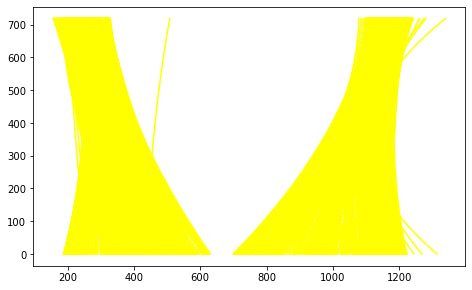

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

zFrame = globalVar()
zFrame.value = 0

zMismatchCounter = globalVar()
zMismatchCounter.value = 0

left_Line = Line()
right_Line = Line()

sample_fit = np.array([[0,0,0]])

#xlist_left = np.empty_like(sample_fit)
left_Line.best_fit_list = np.empty_like(sample_fit)
left_Line.best_fit_list = np.delete(left_Line.best_fit_list, 0, axis = 0)


right_Line.best_fit_list = np.empty_like(sample_fit)
right_Line.best_fit_list = np.delete(right_Line.best_fit_list, 0, axis = 0)

#xlist_right = np.empty_like(sample_fit)
#xlist_right = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]])
#xlist_right = np.delete(xlist_right, 0, axis = 0)
#print(xlist_left, xlist_right)
white_output = 'project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")#.subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [27]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [2]:
sample = np.array([[2.13935315e-04, -3.77507980e-01,  4.76902175e+02]])

sample = np.append(sample, sample, axis = 0)
#sample_fit.append([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
print(len(sample))
print(np.mean(sample, axis=0))

NameError: name 'np' is not defined

In [ ]:
#print([2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
sample_fit = np.array([[0,0,0]])
sample = np.empty_like(sample_fit)
sample = np.delete(sample, 0, axis = 0)
print(sample.shape)
print(sample)
sample = lineSmooth(sample, left_fit, 10)
print(sample)

In [ ]:
print(sample_fit.shape)
print(sample.shape)
print(xlist_left.shape)
print(left_fit.shape)

xlist_left = lineSmooth(xlist_left, left_fit, 10)

In [ ]:
print(xlist_left)

In [ ]:

print(xlist_left.shape)

In [ ]:
# test distort
images = glob.glob('test_images/test1.jpg')
#img = cv2.imread(images[0])
#cv2.imshow('in', img)

#outimg = undistortImg(img, mtx, dist)
#cv2.imshow('out', outimg)
#print(image.shape)
img = cv2.imread(images[0])
warped, M = warpImg(img,0.17,0.65)
cv2.imshow('orig',img)
cv2.imshow('warped',warped)
cv2.destroyAllWindows()

In [ ]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!


image = mpimg.imread('test_images/test1.jpg')

result = pipeline(image)

# Plot the result
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()

#warp preprocessed
warped, M = warpImg(result,0.17,0.65)

#ax1.imshow(result)
#ax1.set_title('Original Image', fontsize=40)

#ax2.imshow(warped)
#ax2.set_title('Pipeline Result', fontsize=40)


cv2.imshow('warped',warped)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

warped = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
out_img, left_fitx, right_fitx, left_fit, right_fit, ploty = fit_polynomial(warped)
#cv2.imshow("polynol", out_img)
#plt.imshow(out_img)

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

result, left_fitx, right_fitx, left_fit, right_fit, fLeftFound, fRightFound, ploty = search_around_poly(warped, left_fit, right_fit)
cv2.imshow("result",result)
print(left_fit, fLeftFound)

# View your output
plt.imshow(result)